# Mask R-CNN Training on Kaggle WAD Competition 2018

In [1]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = './'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist.'

# Import mrcnn libraries
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

Using TensorFlow backend.


## Set up logging and pre-trained model paths

In [3]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR,"Pretrained_Model","mask_rcnn_coco.h5")

print(COCO_MODEL_PATH)

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

./Pretrained_Model/mask_rcnn_coco.h5


## Configuration
Define configurations for training on the Kaggle WAD Dataset

In [4]:
class WADConfig(Config):
    """Configuration for training on the cigarette butts dataset.
    Derives from the base Config class and overrides values specific
    to the cigarette butts dataset.
    """
    # Give the configuration a recognizable name
    NAME = "WAD"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 5

    # Number of classes (including background)
    NUM_CLASSES = 1 + 7  # background + 1 (7 classes in our dataset)

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 640
    IMAGE_MAX_DIM = 832

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 10

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Can also use resnet101
    BACKBONE = 'resnet50'

    # Set Region Proposal Anchor Scales
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = WADConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     5
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 5
IMAGE_MAX_DIM                  832
IMAGE_META_SIZE                20
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [832 832   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES 

# Define the dataset
Generic COCO Like Dataset Loader Class

In [5]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

# Create the Training and Validation Datasets

In [6]:
dataset_train = CocoLikeDataset()
dataset_train.load_data('/home/ayush/Instance_Segmentation/all/Sample_Dataset/wad_sample_train.json', '/home/ayush/Instance_Segmentation/all/Sample_Dataset/sample_train_color')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('/home/ayush/Instance_Segmentation/all/Sample_Dataset/wad_sample_val.json', '/home/ayush/Instance_Segmentation/all/Sample_Dataset/sample_val_color')
dataset_val.prepare()

## Display a few images from the training dataset

['BG', 'car', 'motorbicycle', 'bicycle', 'truck', 'bus', 'tricycle', 'person']
[2131  507 3695 4862]


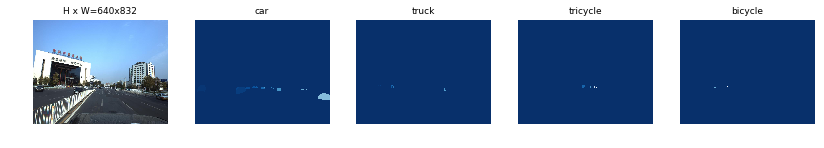

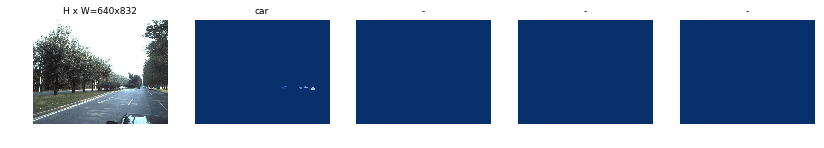

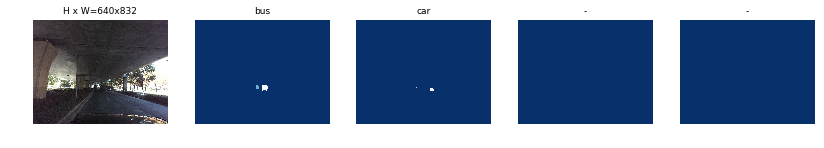

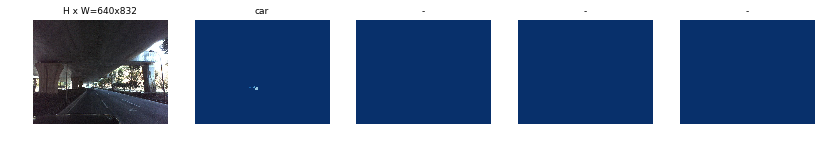

In [7]:
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
print(dataset.class_names)
print(image_ids)

for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

# Create the Training Model and Train

In [8]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [9]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:

1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.



In [10]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=100, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./logs/wad20190311T1356/mask_rcnn_wad_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistribu

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 25:06 - loss: 4.9027 - rpn_class_loss: 0.3338 - rpn_bbox_loss: 1.4064 - mrcnn_class_loss: 1.2534 - mrcnn_bbox_loss: 1.3751 - mrcnn_mask_loss: 0.5340

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 14:11 - loss: 4.6205 - rpn_class_loss: 0.3333 - rpn_bbox_loss: 1.4060 - mrcnn_class_loss: 1.0096 - mrcnn_bbox_loss: 1.3378 - mrcnn_mask_loss: 0.5338

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 10:00 - loss: 4.3155 - rpn_class_loss: 0.3324 - rpn_bbox_loss: 1.4052 - mrcnn_class_loss: 0.7725 - mrcnn_bbox_loss: 1.2724 - mrcnn_mask_loss: 0.5331

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 7:32 - loss: 4.0509 - rpn_class_loss: 0.3309 - rpn_bbox_loss: 1.4039 - mrcnn_class_loss: 0.6166 - mrcnn_bbox_loss: 1.1683 - mrcnn_mask_loss: 0.5312 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 5:45 - loss: 3.8178 - rpn_class_loss: 0.3286 - rpn_bbox_loss: 1.4018 - mrcnn_class_loss: 0.5186 - mrcnn_bbox_loss: 1.0399 - mrcnn_mask_loss: 0.5290

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 4:19 - loss: 3.6215 - rpn_class_loss: 0.3252 - rpn_bbox_loss: 1.3983 - mrcnn_class_loss: 0.4498 - mrcnn_bbox_loss: 0.9223 - mrcnn_mask_loss: 0.5259

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 3:06 - loss: 3.4493 - rpn_class_loss: 0.3208 - rpn_bbox_loss: 1.3931 - mrcnn_class_loss: 0.3957 - mrcnn_bbox_loss: 0.8171 - mrcnn_mask_loss: 0.5227

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:59 - loss: 3.3407 - rpn_class_loss: 0.3152 - rpn_bbox_loss: 1.3860 - mrcnn_class_loss: 0.3607 - mrcnn_bbox_loss: 0.7500 - mrcnn_mask_loss: 0.5287

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 58s - loss: 3.2597 - rpn_class_loss: 0.3088 - rpn_bbox_loss: 1.3773 - mrcnn_class_loss: 0.3330 - mrcnn_bbox_loss: 0.7088 - mrcnn_mask_loss: 0.5318 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 663s 66s/step - loss: 3.2213 - rpn_class_loss: 0.3018 - rpn_bbox_loss: 1.3674 - mrcnn_class_loss: 0.3203 - mrcnn_bbox_loss: 0.6948 - mrcnn_mask_loss: 0.5371 - val_loss: 2.9041 - val_rpn_class_loss: 0.0804 - val_rpn_bbox_loss: 1.1244 - val_mrcnn_class_loss: 0.1625 - val_mrcnn_bbox_loss: 0.9703 - val_mrcnn_mask_loss: 0.5664


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 2/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:31 - loss: 2.8305 - rpn_class_loss: 0.2183 - rpn_bbox_loss: 1.2451 - mrcnn_class_loss: 0.2086 - mrcnn_bbox_loss: 0.5779 - mrcnn_mask_loss: 0.5806

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:50 - loss: 2.7315 - rpn_class_loss: 0.2085 - rpn_bbox_loss: 1.2291 - mrcnn_class_loss: 0.1846 - mrcnn_bbox_loss: 0.5386 - mrcnn_mask_loss: 0.5708

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:07 - loss: 2.7681 - rpn_class_loss: 0.2043 - rpn_bbox_loss: 1.1647 - mrcnn_class_loss: 0.1619 - mrcnn_bbox_loss: 0.6546 - mrcnn_mask_loss: 0.5827

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:23 - loss: 2.7774 - rpn_class_loss: 0.1977 - rpn_bbox_loss: 1.1269 - mrcnn_class_loss: 0.1437 - mrcnn_bbox_loss: 0.6979 - mrcnn_mask_loss: 0.6112

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:39 - loss: 2.7174 - rpn_class_loss: 0.1909 - rpn_bbox_loss: 1.1005 - mrcnn_class_loss: 0.1380 - mrcnn_bbox_loss: 0.6656 - mrcnn_mask_loss: 0.6224

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:55 - loss: 2.6935 - rpn_class_loss: 0.1845 - rpn_bbox_loss: 1.0809 - mrcnn_class_loss: 0.1378 - mrcnn_bbox_loss: 0.6645 - mrcnn_mask_loss: 0.6258

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:12 - loss: 2.6725 - rpn_class_loss: 0.1789 - rpn_bbox_loss: 1.0656 - mrcnn_class_loss: 0.1365 - mrcnn_bbox_loss: 0.6648 - mrcnn_mask_loss: 0.6266

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:28 - loss: 2.7353 - rpn_class_loss: 0.1741 - rpn_bbox_loss: 1.0529 - mrcnn_class_loss: 0.1415 - mrcnn_bbox_loss: 0.7327 - mrcnn_mask_loss: 0.6342

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 2.7547 - rpn_class_loss: 0.1700 - rpn_bbox_loss: 1.0415 - mrcnn_class_loss: 0.1414 - mrcnn_bbox_loss: 0.7642 - mrcnn_mask_loss: 0.6376 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 534s 53s/step - loss: 2.7470 - rpn_class_loss: 0.1666 - rpn_bbox_loss: 1.0310 - mrcnn_class_loss: 0.1462 - mrcnn_bbox_loss: 0.7645 - mrcnn_mask_loss: 0.6387 - val_loss: 2.7308 - val_rpn_class_loss: 0.0992 - val_rpn_bbox_loss: 0.9690 - val_mrcnn_class_loss: 0.0544 - val_mrcnn_bbox_loss: 0.8870 - val_mrcnn_mask_loss: 0.7211


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 3/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:36 - loss: 2.6136 - rpn_class_loss: 0.1353 - rpn_bbox_loss: 0.9200 - mrcnn_class_loss: 0.1885 - mrcnn_bbox_loss: 0.7226 - mrcnn_mask_loss: 0.6473

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:52 - loss: 2.5285 - rpn_class_loss: 0.1349 - rpn_bbox_loss: 0.9123 - mrcnn_class_loss: 0.1807 - mrcnn_bbox_loss: 0.6642 - mrcnn_mask_loss: 0.6363

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:09 - loss: 2.4517 - rpn_class_loss: 0.1345 - rpn_bbox_loss: 0.9057 - mrcnn_class_loss: 0.1774 - mrcnn_bbox_loss: 0.6085 - mrcnn_mask_loss: 0.6256

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:25 - loss: 2.3664 - rpn_class_loss: 0.1338 - rpn_bbox_loss: 0.9001 - mrcnn_class_loss: 0.1586 - mrcnn_bbox_loss: 0.5507 - mrcnn_mask_loss: 0.6232

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:42 - loss: 2.5044 - rpn_class_loss: 0.1299 - rpn_bbox_loss: 0.9230 - mrcnn_class_loss: 0.1377 - mrcnn_bbox_loss: 0.7054 - mrcnn_mask_loss: 0.6085

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:59 - loss: 2.5777 - rpn_class_loss: 0.1268 - rpn_bbox_loss: 0.9383 - mrcnn_class_loss: 0.1237 - mrcnn_bbox_loss: 0.7903 - mrcnn_mask_loss: 0.5986

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:15 - loss: 2.5957 - rpn_class_loss: 0.1242 - rpn_bbox_loss: 0.9488 - mrcnn_class_loss: 0.1132 - mrcnn_bbox_loss: 0.8181 - mrcnn_mask_loss: 0.5914

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:30 - loss: 2.5735 - rpn_class_loss: 0.1219 - rpn_bbox_loss: 0.9557 - mrcnn_class_loss: 0.1061 - mrcnn_bbox_loss: 0.8095 - mrcnn_mask_loss: 0.5803

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 2.5351 - rpn_class_loss: 0.1197 - rpn_bbox_loss: 0.9597 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.7835 - mrcnn_mask_loss: 0.5710 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 549s 55s/step - loss: 2.4847 - rpn_class_loss: 0.1176 - rpn_bbox_loss: 0.9615 - mrcnn_class_loss: 0.0969 - mrcnn_bbox_loss: 0.7461 - mrcnn_mask_loss: 0.5626 - val_loss: 2.6664 - val_rpn_class_loss: 0.0909 - val_rpn_bbox_loss: 0.9579 - val_mrcnn_class_loss: 0.1156 - val_mrcnn_bbox_loss: 0.8790 - val_mrcnn_mask_loss: 0.6230
Epoch 4/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:50 - loss: 1.8660 - rpn_class_loss: 0.0948 - rpn_bbox_loss: 0.9601 - mrcnn_class_loss: 0.0824 - mrcnn_bbox_loss: 0.2490 - mrcnn_mask_loss: 0.4797

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:07 - loss: 1.8788 - rpn_class_loss: 0.0929 - rpn_bbox_loss: 0.9511 - mrcnn_class_loss: 0.0890 - mrcnn_bbox_loss: 0.2509 - mrcnn_mask_loss: 0.4949

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:19 - loss: 1.8711 - rpn_class_loss: 0.0909 - rpn_bbox_loss: 0.9419 - mrcnn_class_loss: 0.0923 - mrcnn_bbox_loss: 0.2497 - mrcnn_mask_loss: 0.4964

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:32 - loss: 1.8628 - rpn_class_loss: 0.0888 - rpn_bbox_loss: 0.9325 - mrcnn_class_loss: 0.0959 - mrcnn_bbox_loss: 0.2516 - mrcnn_mask_loss: 0.4940

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:47 - loss: 1.8971 - rpn_class_loss: 0.0868 - rpn_bbox_loss: 0.9232 - mrcnn_class_loss: 0.1044 - mrcnn_bbox_loss: 0.2850 - mrcnn_mask_loss: 0.4977

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:05 - loss: 2.0150 - rpn_class_loss: 0.0930 - rpn_bbox_loss: 0.9202 - mrcnn_class_loss: 0.1159 - mrcnn_bbox_loss: 0.3713 - mrcnn_mask_loss: 0.5146

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:19 - loss: 2.0008 - rpn_class_loss: 0.0900 - rpn_bbox_loss: 0.9102 - mrcnn_class_loss: 0.1184 - mrcnn_bbox_loss: 0.3702 - mrcnn_mask_loss: 0.5119

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:32 - loss: 2.0616 - rpn_class_loss: 0.0939 - rpn_bbox_loss: 0.9089 - mrcnn_class_loss: 0.1301 - mrcnn_bbox_loss: 0.4043 - mrcnn_mask_loss: 0.5243

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 2.1005 - rpn_class_loss: 0.0969 - rpn_bbox_loss: 0.9077 - mrcnn_class_loss: 0.1401 - mrcnn_bbox_loss: 0.4234 - mrcnn_mask_loss: 0.5324 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 553s 55s/step - loss: 2.1220 - rpn_class_loss: 0.0991 - rpn_bbox_loss: 0.9063 - mrcnn_class_loss: 0.1488 - mrcnn_bbox_loss: 0.4309 - mrcnn_mask_loss: 0.5369 - val_loss: 2.8763 - val_rpn_class_loss: 0.0669 - val_rpn_bbox_loss: 0.9238 - val_mrcnn_class_loss: 0.1999 - val_mrcnn_bbox_loss: 1.0257 - val_mrcnn_mask_loss: 0.6600


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 5/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:45 - loss: 2.2470 - rpn_class_loss: 0.1175 - rpn_bbox_loss: 0.8883 - mrcnn_class_loss: 0.2116 - mrcnn_bbox_loss: 0.4601 - mrcnn_mask_loss: 0.5695

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:02 - loss: 2.2573 - rpn_class_loss: 0.1166 - rpn_bbox_loss: 0.8850 - mrcnn_class_loss: 0.2361 - mrcnn_bbox_loss: 0.4423 - mrcnn_mask_loss: 0.5773

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:16 - loss: 2.2407 - rpn_class_loss: 0.1155 - rpn_bbox_loss: 0.8816 - mrcnn_class_loss: 0.2362 - mrcnn_bbox_loss: 0.4359 - mrcnn_mask_loss: 0.5714

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:30 - loss: 2.2070 - rpn_class_loss: 0.1144 - rpn_bbox_loss: 0.8781 - mrcnn_class_loss: 0.2333 - mrcnn_bbox_loss: 0.4146 - mrcnn_mask_loss: 0.5666

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:44 - loss: 2.1863 - rpn_class_loss: 0.1131 - rpn_bbox_loss: 0.8745 - mrcnn_class_loss: 0.2333 - mrcnn_bbox_loss: 0.4008 - mrcnn_mask_loss: 0.5645

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:59 - loss: 2.1638 - rpn_class_loss: 0.1119 - rpn_bbox_loss: 0.8710 - mrcnn_class_loss: 0.2307 - mrcnn_bbox_loss: 0.3895 - mrcnn_mask_loss: 0.5608

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:14 - loss: 2.1377 - rpn_class_loss: 0.1106 - rpn_bbox_loss: 0.8675 - mrcnn_class_loss: 0.2301 - mrcnn_bbox_loss: 0.3762 - mrcnn_mask_loss: 0.5534

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:29 - loss: 2.1191 - rpn_class_loss: 0.1095 - rpn_bbox_loss: 0.8641 - mrcnn_class_loss: 0.2347 - mrcnn_bbox_loss: 0.3628 - mrcnn_mask_loss: 0.5480

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 2.1018 - rpn_class_loss: 0.1032 - rpn_bbox_loss: 0.8807 - mrcnn_class_loss: 0.2110 - mrcnn_bbox_loss: 0.3871 - mrcnn_mask_loss: 0.5199 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 548s 55s/step - loss: 2.0741 - rpn_class_loss: 0.0981 - rpn_bbox_loss: 0.8932 - mrcnn_class_loss: 0.1921 - mrcnn_bbox_loss: 0.3935 - mrcnn_mask_loss: 0.4971 - val_loss: 2.9190 - val_rpn_class_loss: 0.0691 - val_rpn_bbox_loss: 0.9052 - val_mrcnn_class_loss: 0.3799 - val_mrcnn_bbox_loss: 0.8895 - val_mrcnn_mask_loss: 0.6753
Epoch 6/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 7:15 - loss: 1.5836 - rpn_class_loss: 0.0532 - rpn_bbox_loss: 0.9962 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.2310 - mrcnn_mask_loss: 0.2793

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:16 - loss: 2.0647 - rpn_class_loss: 0.0666 - rpn_bbox_loss: 0.9597 - mrcnn_class_loss: 0.1377 - mrcnn_bbox_loss: 0.4876 - mrcnn_mask_loss: 0.4132

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:24 - loss: 1.9289 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 0.9642 - mrcnn_class_loss: 0.1023 - mrcnn_bbox_loss: 0.3967 - mrcnn_mask_loss: 0.4036

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:37 - loss: 1.8582 - rpn_class_loss: 0.0597 - rpn_bbox_loss: 0.9631 - mrcnn_class_loss: 0.0841 - mrcnn_bbox_loss: 0.3539 - mrcnn_mask_loss: 0.3973

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:50 - loss: 1.8035 - rpn_class_loss: 0.0581 - rpn_bbox_loss: 0.9592 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.3225 - mrcnn_mask_loss: 0.3904

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:03 - loss: 1.7616 - rpn_class_loss: 0.0570 - rpn_bbox_loss: 0.9535 - mrcnn_class_loss: 0.0658 - mrcnn_bbox_loss: 0.3053 - mrcnn_mask_loss: 0.3801

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:17 - loss: 1.7220 - rpn_class_loss: 0.0560 - rpn_bbox_loss: 0.9464 - mrcnn_class_loss: 0.0604 - mrcnn_bbox_loss: 0.2882 - mrcnn_mask_loss: 0.3710

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:31 - loss: 1.8135 - rpn_class_loss: 0.0584 - rpn_bbox_loss: 0.9436 - mrcnn_class_loss: 0.0880 - mrcnn_bbox_loss: 0.3252 - mrcnn_mask_loss: 0.3983

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.7716 - rpn_class_loss: 0.0572 - rpn_bbox_loss: 0.9349 - mrcnn_class_loss: 0.0812 - mrcnn_bbox_loss: 0.3124 - mrcnn_mask_loss: 0.3860 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 552s 55s/step - loss: 1.7309 - rpn_class_loss: 0.0562 - rpn_bbox_loss: 0.9263 - mrcnn_class_loss: 0.0754 - mrcnn_bbox_loss: 0.2980 - mrcnn_mask_loss: 0.3751 - val_loss: 3.1272 - val_rpn_class_loss: 0.0918 - val_rpn_bbox_loss: 0.9126 - val_mrcnn_class_loss: 0.6789 - val_mrcnn_bbox_loss: 0.8214 - val_mrcnn_mask_loss: 0.6225


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 7/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:44 - loss: 2.2458 - rpn_class_loss: 0.0711 - rpn_bbox_loss: 0.9172 - mrcnn_class_loss: 0.2460 - mrcnn_bbox_loss: 0.4387 - mrcnn_mask_loss: 0.5729

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:00 - loss: 1.7294 - rpn_class_loss: 0.0581 - rpn_bbox_loss: 0.8719 - mrcnn_class_loss: 0.1371 - mrcnn_bbox_loss: 0.2438 - mrcnn_mask_loss: 0.4184

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:16 - loss: 1.5564 - rpn_class_loss: 0.0535 - rpn_bbox_loss: 0.8523 - mrcnn_class_loss: 0.0995 - mrcnn_bbox_loss: 0.1814 - mrcnn_mask_loss: 0.3697

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:30 - loss: 1.6878 - rpn_class_loss: 0.0570 - rpn_bbox_loss: 0.8648 - mrcnn_class_loss: 0.1348 - mrcnn_bbox_loss: 0.2191 - mrcnn_mask_loss: 0.4121

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:45 - loss: 1.7523 - rpn_class_loss: 0.0590 - rpn_bbox_loss: 0.8707 - mrcnn_class_loss: 0.1543 - mrcnn_bbox_loss: 0.2315 - mrcnn_mask_loss: 0.4368

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:00 - loss: 1.7789 - rpn_class_loss: 0.0602 - rpn_bbox_loss: 0.8727 - mrcnn_class_loss: 0.1634 - mrcnn_bbox_loss: 0.2357 - mrcnn_mask_loss: 0.4468

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:15 - loss: 1.8195 - rpn_class_loss: 0.0610 - rpn_bbox_loss: 0.8721 - mrcnn_class_loss: 0.1752 - mrcnn_bbox_loss: 0.2524 - mrcnn_mask_loss: 0.4587

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:30 - loss: 1.8573 - rpn_class_loss: 0.0615 - rpn_bbox_loss: 0.8699 - mrcnn_class_loss: 0.1842 - mrcnn_bbox_loss: 0.2702 - mrcnn_mask_loss: 0.4716

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.8705 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 0.8666 - mrcnn_class_loss: 0.1896 - mrcnn_bbox_loss: 0.2760 - mrcnn_mask_loss: 0.4764 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 546s 55s/step - loss: 1.8904 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 0.8627 - mrcnn_class_loss: 0.1931 - mrcnn_bbox_loss: 0.2878 - mrcnn_mask_loss: 0.4848 - val_loss: 3.2309 - val_rpn_class_loss: 0.0931 - val_rpn_bbox_loss: 0.8701 - val_mrcnn_class_loss: 0.8810 - val_mrcnn_bbox_loss: 0.7744 - val_mrcnn_mask_loss: 0.6124


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 8/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:37 - loss: 1.9383 - rpn_class_loss: 0.0631 - rpn_bbox_loss: 0.8159 - mrcnn_class_loss: 0.2136 - mrcnn_bbox_loss: 0.2972 - mrcnn_mask_loss: 0.5484

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:57 - loss: 2.4812 - rpn_class_loss: 0.1099 - rpn_bbox_loss: 0.9074 - mrcnn_class_loss: 0.3673 - mrcnn_bbox_loss: 0.5282 - mrcnn_mask_loss: 0.5685

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:12 - loss: 2.2936 - rpn_class_loss: 0.0936 - rpn_bbox_loss: 0.8694 - mrcnn_class_loss: 0.3089 - mrcnn_bbox_loss: 0.4800 - mrcnn_mask_loss: 0.5417

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:27 - loss: 2.4697 - rpn_class_loss: 0.1078 - rpn_bbox_loss: 0.9028 - mrcnn_class_loss: 0.3493 - mrcnn_bbox_loss: 0.5578 - mrcnn_mask_loss: 0.5521

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:44 - loss: 2.5776 - rpn_class_loss: 0.1152 - rpn_bbox_loss: 0.9229 - mrcnn_class_loss: 0.3704 - mrcnn_bbox_loss: 0.6037 - mrcnn_mask_loss: 0.5654

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:59 - loss: 2.6143 - rpn_class_loss: 0.1191 - rpn_bbox_loss: 0.9361 - mrcnn_class_loss: 0.3804 - mrcnn_bbox_loss: 0.6145 - mrcnn_mask_loss: 0.5642

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:14 - loss: 2.6467 - rpn_class_loss: 0.1209 - rpn_bbox_loss: 0.9450 - mrcnn_class_loss: 0.3966 - mrcnn_bbox_loss: 0.6187 - mrcnn_mask_loss: 0.5655

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:29 - loss: 2.6653 - rpn_class_loss: 0.1215 - rpn_bbox_loss: 0.9511 - mrcnn_class_loss: 0.4077 - mrcnn_bbox_loss: 0.6166 - mrcnn_mask_loss: 0.5684

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 2.6592 - rpn_class_loss: 0.1213 - rpn_bbox_loss: 0.9551 - mrcnn_class_loss: 0.4080 - mrcnn_bbox_loss: 0.6094 - mrcnn_mask_loss: 0.5655 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 552s 55s/step - loss: 2.6525 - rpn_class_loss: 0.1207 - rpn_bbox_loss: 0.9575 - mrcnn_class_loss: 0.4039 - mrcnn_bbox_loss: 0.6039 - mrcnn_mask_loss: 0.5665 - val_loss: 2.9578 - val_rpn_class_loss: 0.1020 - val_rpn_bbox_loss: 0.9512 - val_mrcnn_class_loss: 0.5508 - val_mrcnn_bbox_loss: 0.7488 - val_mrcnn_mask_loss: 0.6049


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 9/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:41 - loss: 2.4762 - rpn_class_loss: 0.1118 - rpn_bbox_loss: 0.9696 - mrcnn_class_loss: 0.3830 - mrcnn_bbox_loss: 0.4590 - mrcnn_mask_loss: 0.5527

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:01 - loss: 2.4723 - rpn_class_loss: 0.1109 - rpn_bbox_loss: 0.9641 - mrcnn_class_loss: 0.3959 - mrcnn_bbox_loss: 0.4502 - mrcnn_mask_loss: 0.5513

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:17 - loss: 2.4282 - rpn_class_loss: 0.1103 - rpn_bbox_loss: 0.9584 - mrcnn_class_loss: 0.3780 - mrcnn_bbox_loss: 0.4406 - mrcnn_mask_loss: 0.5409

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:33 - loss: 2.4035 - rpn_class_loss: 0.1099 - rpn_bbox_loss: 0.9524 - mrcnn_class_loss: 0.3591 - mrcnn_bbox_loss: 0.4413 - mrcnn_mask_loss: 0.5407

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:48 - loss: 2.4815 - rpn_class_loss: 0.1089 - rpn_bbox_loss: 0.9548 - mrcnn_class_loss: 0.3794 - mrcnn_bbox_loss: 0.4949 - mrcnn_mask_loss: 0.5436

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:02 - loss: 2.5399 - rpn_class_loss: 0.1083 - rpn_bbox_loss: 0.9557 - mrcnn_class_loss: 0.3979 - mrcnn_bbox_loss: 0.5283 - mrcnn_mask_loss: 0.5496

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:16 - loss: 2.5816 - rpn_class_loss: 0.1080 - rpn_bbox_loss: 0.9558 - mrcnn_class_loss: 0.4109 - mrcnn_bbox_loss: 0.5461 - mrcnn_mask_loss: 0.5608

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:30 - loss: 2.6043 - rpn_class_loss: 0.1078 - rpn_bbox_loss: 0.9553 - mrcnn_class_loss: 0.4130 - mrcnn_bbox_loss: 0.5588 - mrcnn_mask_loss: 0.5693

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 2.5843 - rpn_class_loss: 0.1077 - rpn_bbox_loss: 0.9542 - mrcnn_class_loss: 0.4087 - mrcnn_bbox_loss: 0.5491 - mrcnn_mask_loss: 0.5645 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 547s 55s/step - loss: 2.5653 - rpn_class_loss: 0.1076 - rpn_bbox_loss: 0.9527 - mrcnn_class_loss: 0.4002 - mrcnn_bbox_loss: 0.5387 - mrcnn_mask_loss: 0.5662 - val_loss: 2.9988 - val_rpn_class_loss: 0.1264 - val_rpn_bbox_loss: 0.9180 - val_mrcnn_class_loss: 0.5757 - val_mrcnn_bbox_loss: 0.7328 - val_mrcnn_mask_loss: 0.6460
Epoch 10/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:47 - loss: 2.3298 - rpn_class_loss: 0.1055 - rpn_bbox_loss: 0.9305 - mrcnn_class_loss: 0.3251 - mrcnn_bbox_loss: 0.3604 - mrcnn_mask_loss: 0.6083

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:05 - loss: 2.2898 - rpn_class_loss: 0.1048 - rpn_bbox_loss: 0.9267 - mrcnn_class_loss: 0.3306 - mrcnn_bbox_loss: 0.3436 - mrcnn_mask_loss: 0.5841

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:21 - loss: 2.2535 - rpn_class_loss: 0.1040 - rpn_bbox_loss: 0.9232 - mrcnn_class_loss: 0.3300 - mrcnn_bbox_loss: 0.3235 - mrcnn_mask_loss: 0.5728

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:34 - loss: 2.2205 - rpn_class_loss: 0.1030 - rpn_bbox_loss: 0.9200 - mrcnn_class_loss: 0.3215 - mrcnn_bbox_loss: 0.3105 - mrcnn_mask_loss: 0.5655

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:48 - loss: 2.1670 - rpn_class_loss: 0.1019 - rpn_bbox_loss: 0.9170 - mrcnn_class_loss: 0.3067 - mrcnn_bbox_loss: 0.2907 - mrcnn_mask_loss: 0.5507

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:02 - loss: 2.1303 - rpn_class_loss: 0.1007 - rpn_bbox_loss: 0.9139 - mrcnn_class_loss: 0.2909 - mrcnn_bbox_loss: 0.2870 - mrcnn_mask_loss: 0.5378

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:16 - loss: 2.1740 - rpn_class_loss: 0.0917 - rpn_bbox_loss: 0.9223 - mrcnn_class_loss: 0.2757 - mrcnn_bbox_loss: 0.3613 - mrcnn_mask_loss: 0.5230

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:30 - loss: 2.1963 - rpn_class_loss: 0.0847 - rpn_bbox_loss: 0.9263 - mrcnn_class_loss: 0.2624 - mrcnn_bbox_loss: 0.4114 - mrcnn_mask_loss: 0.5116

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 2.2177 - rpn_class_loss: 0.0799 - rpn_bbox_loss: 0.9249 - mrcnn_class_loss: 0.2626 - mrcnn_bbox_loss: 0.4277 - mrcnn_mask_loss: 0.5226 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 546s 55s/step - loss: 2.1967 - rpn_class_loss: 0.0753 - rpn_bbox_loss: 0.9227 - mrcnn_class_loss: 0.2496 - mrcnn_bbox_loss: 0.4376 - mrcnn_mask_loss: 0.5116 - val_loss: 2.6871 - val_rpn_class_loss: 0.0871 - val_rpn_bbox_loss: 0.8445 - val_mrcnn_class_loss: 0.4663 - val_mrcnn_bbox_loss: 0.7124 - val_mrcnn_mask_loss: 0.5768
Epoch 11/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:44 - loss: 2.3104 - rpn_class_loss: 0.0404 - rpn_bbox_loss: 0.9151 - mrcnn_class_loss: 0.2377 - mrcnn_bbox_loss: 0.5023 - mrcnn_mask_loss: 0.6150

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:56 - loss: 2.1082 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.8889 - mrcnn_class_loss: 0.1931 - mrcnn_bbox_loss: 0.4690 - mrcnn_mask_loss: 0.5209

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:11 - loss: 2.0082 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.8751 - mrcnn_class_loss: 0.1697 - mrcnn_bbox_loss: 0.4448 - mrcnn_mask_loss: 0.4839

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:30 - loss: 1.9503 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.8646 - mrcnn_class_loss: 0.1555 - mrcnn_bbox_loss: 0.4295 - mrcnn_mask_loss: 0.4668

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:45 - loss: 1.8992 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.8556 - mrcnn_class_loss: 0.1482 - mrcnn_bbox_loss: 0.4053 - mrcnn_mask_loss: 0.4568

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:00 - loss: 1.9507 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.8631 - mrcnn_class_loss: 0.1671 - mrcnn_bbox_loss: 0.4168 - mrcnn_mask_loss: 0.4693

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:15 - loss: 1.9155 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.8532 - mrcnn_class_loss: 0.1579 - mrcnn_bbox_loss: 0.4099 - mrcnn_mask_loss: 0.4606

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:30 - loss: 1.9710 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 0.8563 - mrcnn_class_loss: 0.1776 - mrcnn_bbox_loss: 0.4265 - mrcnn_mask_loss: 0.4692

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 2.0098 - rpn_class_loss: 0.0473 - rpn_bbox_loss: 0.8587 - mrcnn_class_loss: 0.1920 - mrcnn_bbox_loss: 0.4386 - mrcnn_mask_loss: 0.4731 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 551s 55s/step - loss: 1.9824 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 0.8497 - mrcnn_class_loss: 0.1834 - mrcnn_bbox_loss: 0.4366 - mrcnn_mask_loss: 0.4672 - val_loss: 2.5566 - val_rpn_class_loss: 0.0555 - val_rpn_bbox_loss: 0.8036 - val_mrcnn_class_loss: 0.4576 - val_mrcnn_bbox_loss: 0.6606 - val_mrcnn_mask_loss: 0.5794
Epoch 12/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:42 - loss: 1.7005 - rpn_class_loss: 0.0297 - rpn_bbox_loss: 0.7600 - mrcnn_class_loss: 0.1248 - mrcnn_bbox_loss: 0.3749 - mrcnn_mask_loss: 0.4110

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:13 - loss: 1.8167 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.8125 - mrcnn_class_loss: 0.1822 - mrcnn_bbox_loss: 0.3676 - mrcnn_mask_loss: 0.4194

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:29 - loss: 1.7715 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.7877 - mrcnn_class_loss: 0.1644 - mrcnn_bbox_loss: 0.3708 - mrcnn_mask_loss: 0.4156

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:41 - loss: 1.7306 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.7727 - mrcnn_class_loss: 0.1508 - mrcnn_bbox_loss: 0.3596 - mrcnn_mask_loss: 0.4154

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:54 - loss: 1.7480 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.7865 - mrcnn_class_loss: 0.1645 - mrcnn_bbox_loss: 0.3488 - mrcnn_mask_loss: 0.4146

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:06 - loss: 1.7395 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.7940 - mrcnn_class_loss: 0.1662 - mrcnn_bbox_loss: 0.3322 - mrcnn_mask_loss: 0.4123

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:19 - loss: 1.7179 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.7974 - mrcnn_class_loss: 0.1654 - mrcnn_bbox_loss: 0.3109 - mrcnn_mask_loss: 0.4087

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:32 - loss: 1.7712 - rpn_class_loss: 0.0429 - rpn_bbox_loss: 0.8064 - mrcnn_class_loss: 0.1843 - mrcnn_bbox_loss: 0.3256 - mrcnn_mask_loss: 0.4120

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 46s - loss: 1.7584 - rpn_class_loss: 0.0424 - rpn_bbox_loss: 0.8046 - mrcnn_class_loss: 0.1853 - mrcnn_bbox_loss: 0.3160 - mrcnn_mask_loss: 0.4101 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 567s 57s/step - loss: 1.8495 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 0.8137 - mrcnn_class_loss: 0.2112 - mrcnn_bbox_loss: 0.3518 - mrcnn_mask_loss: 0.4303 - val_loss: 2.6273 - val_rpn_class_loss: 0.0550 - val_rpn_bbox_loss: 0.8536 - val_mrcnn_class_loss: 0.4952 - val_mrcnn_bbox_loss: 0.6421 - val_mrcnn_mask_loss: 0.5814
Epoch 13/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 7:00 - loss: 2.5231 - rpn_class_loss: 0.0435 - rpn_bbox_loss: 0.8966 - mrcnn_class_loss: 0.3804 - mrcnn_bbox_loss: 0.6302 - mrcnn_mask_loss: 0.5724

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:22 - loss: 2.1150 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 0.8210 - mrcnn_class_loss: 0.3146 - mrcnn_bbox_loss: 0.4418 - mrcnn_mask_loss: 0.4969

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:31 - loss: 1.9478 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 0.7903 - mrcnn_class_loss: 0.2816 - mrcnn_bbox_loss: 0.3670 - mrcnn_mask_loss: 0.4695

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:42 - loss: 1.9953 - rpn_class_loss: 0.0528 - rpn_bbox_loss: 0.8105 - mrcnn_class_loss: 0.2768 - mrcnn_bbox_loss: 0.3986 - mrcnn_mask_loss: 0.4566

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:53 - loss: 1.8930 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 0.7877 - mrcnn_class_loss: 0.2607 - mrcnn_bbox_loss: 0.3512 - mrcnn_mask_loss: 0.4438

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:05 - loss: 1.8277 - rpn_class_loss: 0.0475 - rpn_bbox_loss: 0.7700 - mrcnn_class_loss: 0.2480 - mrcnn_bbox_loss: 0.3253 - mrcnn_mask_loss: 0.4371

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:18 - loss: 1.8787 - rpn_class_loss: 0.0539 - rpn_bbox_loss: 0.7845 - mrcnn_class_loss: 0.2557 - mrcnn_bbox_loss: 0.3472 - mrcnn_mask_loss: 0.4374

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:33 - loss: 1.9070 - rpn_class_loss: 0.0587 - rpn_bbox_loss: 0.7956 - mrcnn_class_loss: 0.2596 - mrcnn_bbox_loss: 0.3533 - mrcnn_mask_loss: 0.4398

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 46s - loss: 1.9107 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 0.8040 - mrcnn_class_loss: 0.2580 - mrcnn_bbox_loss: 0.3495 - mrcnn_mask_loss: 0.4370 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 565s 57s/step - loss: 1.9231 - rpn_class_loss: 0.0602 - rpn_bbox_loss: 0.8104 - mrcnn_class_loss: 0.2477 - mrcnn_bbox_loss: 0.3630 - mrcnn_mask_loss: 0.4417 - val_loss: 2.4415 - val_rpn_class_loss: 0.0415 - val_rpn_bbox_loss: 0.9245 - val_mrcnn_class_loss: 0.3257 - val_mrcnn_bbox_loss: 0.7112 - val_mrcnn_mask_loss: 0.4385


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 14/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:57 - loss: 1.8990 - rpn_class_loss: 0.0898 - rpn_bbox_loss: 0.8584 - mrcnn_class_loss: 0.2190 - mrcnn_bbox_loss: 0.3351 - mrcnn_mask_loss: 0.3967

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:11 - loss: 2.0747 - rpn_class_loss: 0.0712 - rpn_bbox_loss: 0.8781 - mrcnn_class_loss: 0.1978 - mrcnn_bbox_loss: 0.4781 - mrcnn_mask_loss: 0.4494

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:22 - loss: 2.1164 - rpn_class_loss: 0.0649 - rpn_bbox_loss: 0.8800 - mrcnn_class_loss: 0.2031 - mrcnn_bbox_loss: 0.5063 - mrcnn_mask_loss: 0.4621

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:35 - loss: 2.0496 - rpn_class_loss: 0.0706 - rpn_bbox_loss: 0.8685 - mrcnn_class_loss: 0.2093 - mrcnn_bbox_loss: 0.4520 - mrcnn_mask_loss: 0.4492

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:51 - loss: 2.0086 - rpn_class_loss: 0.0739 - rpn_bbox_loss: 0.8604 - mrcnn_class_loss: 0.2127 - mrcnn_bbox_loss: 0.4196 - mrcnn_mask_loss: 0.4419

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:07 - loss: 2.0176 - rpn_class_loss: 0.0683 - rpn_bbox_loss: 0.8517 - mrcnn_class_loss: 0.2190 - mrcnn_bbox_loss: 0.4295 - mrcnn_mask_loss: 0.4490

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:20 - loss: 1.9937 - rpn_class_loss: 0.0707 - rpn_bbox_loss: 0.8467 - mrcnn_class_loss: 0.2233 - mrcnn_bbox_loss: 0.4108 - mrcnn_mask_loss: 0.4421

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:33 - loss: 1.9741 - rpn_class_loss: 0.0724 - rpn_bbox_loss: 0.8420 - mrcnn_class_loss: 0.2260 - mrcnn_bbox_loss: 0.3945 - mrcnn_mask_loss: 0.4392

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 46s - loss: 1.9792 - rpn_class_loss: 0.0689 - rpn_bbox_loss: 0.8365 - mrcnn_class_loss: 0.2324 - mrcnn_bbox_loss: 0.3974 - mrcnn_mask_loss: 0.4440 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 562s 56s/step - loss: 1.9804 - rpn_class_loss: 0.0661 - rpn_bbox_loss: 0.8315 - mrcnn_class_loss: 0.2352 - mrcnn_bbox_loss: 0.3990 - mrcnn_mask_loss: 0.4487 - val_loss: 2.3036 - val_rpn_class_loss: 0.0453 - val_rpn_bbox_loss: 0.8924 - val_mrcnn_class_loss: 0.3245 - val_mrcnn_bbox_loss: 0.5700 - val_mrcnn_mask_loss: 0.4713


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 15/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:52 - loss: 2.0554 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 0.7773 - mrcnn_class_loss: 0.3318 - mrcnn_bbox_loss: 0.4119 - mrcnn_mask_loss: 0.4938

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:11 - loss: 2.1176 - rpn_class_loss: 0.0471 - rpn_bbox_loss: 0.7989 - mrcnn_class_loss: 0.2917 - mrcnn_bbox_loss: 0.5005 - mrcnn_mask_loss: 0.4795

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:23 - loss: 2.0297 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 0.7855 - mrcnn_class_loss: 0.2815 - mrcnn_bbox_loss: 0.4447 - mrcnn_mask_loss: 0.4734

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:36 - loss: 2.0561 - rpn_class_loss: 0.0475 - rpn_bbox_loss: 0.8252 - mrcnn_class_loss: 0.2526 - mrcnn_bbox_loss: 0.4759 - mrcnn_mask_loss: 0.4549

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:49 - loss: 2.0561 - rpn_class_loss: 0.0491 - rpn_bbox_loss: 0.8487 - mrcnn_class_loss: 0.2370 - mrcnn_bbox_loss: 0.4763 - mrcnn_mask_loss: 0.4450

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:04 - loss: 2.0185 - rpn_class_loss: 0.0474 - rpn_bbox_loss: 0.8307 - mrcnn_class_loss: 0.2265 - mrcnn_bbox_loss: 0.4666 - mrcnn_mask_loss: 0.4474

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:18 - loss: 1.9991 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 0.8170 - mrcnn_class_loss: 0.2241 - mrcnn_bbox_loss: 0.4632 - mrcnn_mask_loss: 0.4488

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:32 - loss: 1.9942 - rpn_class_loss: 0.0468 - rpn_bbox_loss: 0.8145 - mrcnn_class_loss: 0.2270 - mrcnn_bbox_loss: 0.4580 - mrcnn_mask_loss: 0.4479

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 46s - loss: 1.9572 - rpn_class_loss: 0.0457 - rpn_bbox_loss: 0.8042 - mrcnn_class_loss: 0.2189 - mrcnn_bbox_loss: 0.4406 - mrcnn_mask_loss: 0.4477 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 563s 56s/step - loss: 1.9298 - rpn_class_loss: 0.0448 - rpn_bbox_loss: 0.7953 - mrcnn_class_loss: 0.2172 - mrcnn_bbox_loss: 0.4255 - mrcnn_mask_loss: 0.4471 - val_loss: 2.2729 - val_rpn_class_loss: 0.0408 - val_rpn_bbox_loss: 0.9758 - val_mrcnn_class_loss: 0.2664 - val_mrcnn_bbox_loss: 0.5367 - val_mrcnn_mask_loss: 0.4532
Epoch 16/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 7:01 - loss: 1.9584 - rpn_class_loss: 0.0502 - rpn_bbox_loss: 0.7808 - mrcnn_class_loss: 0.2658 - mrcnn_bbox_loss: 0.4223 - mrcnn_mask_loss: 0.4394

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:11 - loss: 1.9557 - rpn_class_loss: 0.0500 - rpn_bbox_loss: 0.7785 - mrcnn_class_loss: 0.2561 - mrcnn_bbox_loss: 0.4345 - mrcnn_mask_loss: 0.4366

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:20 - loss: 1.9182 - rpn_class_loss: 0.0498 - rpn_bbox_loss: 0.7759 - mrcnn_class_loss: 0.2556 - mrcnn_bbox_loss: 0.4097 - mrcnn_mask_loss: 0.4273

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:33 - loss: 1.9896 - rpn_class_loss: 0.0505 - rpn_bbox_loss: 0.8127 - mrcnn_class_loss: 0.2650 - mrcnn_bbox_loss: 0.4406 - mrcnn_mask_loss: 0.4208

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:47 - loss: 1.9485 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 0.8023 - mrcnn_class_loss: 0.2526 - mrcnn_bbox_loss: 0.4187 - mrcnn_mask_loss: 0.4248

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:02 - loss: 1.9994 - rpn_class_loss: 0.0458 - rpn_bbox_loss: 0.8375 - mrcnn_class_loss: 0.2578 - mrcnn_bbox_loss: 0.4295 - mrcnn_mask_loss: 0.4288

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:16 - loss: 2.0462 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 0.8615 - mrcnn_class_loss: 0.2712 - mrcnn_bbox_loss: 0.4385 - mrcnn_mask_loss: 0.4322

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:31 - loss: 2.0069 - rpn_class_loss: 0.0434 - rpn_bbox_loss: 0.8503 - mrcnn_class_loss: 0.2600 - mrcnn_bbox_loss: 0.4251 - mrcnn_mask_loss: 0.4280

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.9835 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 0.8416 - mrcnn_class_loss: 0.2565 - mrcnn_bbox_loss: 0.4166 - mrcnn_mask_loss: 0.4250 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 554s 55s/step - loss: 1.9730 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 0.8515 - mrcnn_class_loss: 0.2553 - mrcnn_bbox_loss: 0.4048 - mrcnn_mask_loss: 0.4168 - val_loss: 2.4307 - val_rpn_class_loss: 0.0386 - val_rpn_bbox_loss: 1.0273 - val_mrcnn_class_loss: 0.3533 - val_mrcnn_bbox_loss: 0.5404 - val_mrcnn_mask_loss: 0.4712
Epoch 17/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:59 - loss: 1.6873 - rpn_class_loss: 0.0470 - rpn_bbox_loss: 0.7397 - mrcnn_class_loss: 0.2283 - mrcnn_bbox_loss: 0.2642 - mrcnn_mask_loss: 0.4081

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:04 - loss: 1.6481 - rpn_class_loss: 0.0469 - rpn_bbox_loss: 0.7285 - mrcnn_class_loss: 0.2224 - mrcnn_bbox_loss: 0.2531 - mrcnn_mask_loss: 0.3972

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:18 - loss: 1.7486 - rpn_class_loss: 0.0486 - rpn_bbox_loss: 0.7880 - mrcnn_class_loss: 0.2352 - mrcnn_bbox_loss: 0.2941 - mrcnn_mask_loss: 0.3827

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:31 - loss: 1.7950 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 0.8166 - mrcnn_class_loss: 0.2346 - mrcnn_bbox_loss: 0.3226 - mrcnn_mask_loss: 0.3717

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:46 - loss: 1.8021 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 0.8329 - mrcnn_class_loss: 0.2364 - mrcnn_bbox_loss: 0.3226 - mrcnn_mask_loss: 0.3601

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:01 - loss: 1.8397 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 0.8576 - mrcnn_class_loss: 0.2491 - mrcnn_bbox_loss: 0.3240 - mrcnn_mask_loss: 0.3632

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:16 - loss: 1.8232 - rpn_class_loss: 0.0467 - rpn_bbox_loss: 0.8620 - mrcnn_class_loss: 0.2473 - mrcnn_bbox_loss: 0.3081 - mrcnn_mask_loss: 0.3591

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:31 - loss: 1.9178 - rpn_class_loss: 0.0502 - rpn_bbox_loss: 0.8707 - mrcnn_class_loss: 0.2609 - mrcnn_bbox_loss: 0.3453 - mrcnn_mask_loss: 0.3907

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.9890 - rpn_class_loss: 0.0526 - rpn_bbox_loss: 0.8772 - mrcnn_class_loss: 0.2724 - mrcnn_bbox_loss: 0.3734 - mrcnn_mask_loss: 0.4134 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 553s 55s/step - loss: 1.9633 - rpn_class_loss: 0.0523 - rpn_bbox_loss: 0.8778 - mrcnn_class_loss: 0.2645 - mrcnn_bbox_loss: 0.3619 - mrcnn_mask_loss: 0.4068 - val_loss: 2.3780 - val_rpn_class_loss: 0.0409 - val_rpn_bbox_loss: 0.9956 - val_mrcnn_class_loss: 0.3992 - val_mrcnn_bbox_loss: 0.5117 - val_mrcnn_mask_loss: 0.4307


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 18/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:41 - loss: 1.7319 - rpn_class_loss: 0.0487 - rpn_bbox_loss: 0.8772 - mrcnn_class_loss: 0.1997 - mrcnn_bbox_loss: 0.2639 - mrcnn_mask_loss: 0.3424

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:59 - loss: 1.8082 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.9091 - mrcnn_class_loss: 0.2339 - mrcnn_bbox_loss: 0.2710 - mrcnn_mask_loss: 0.3582

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:14 - loss: 1.7921 - rpn_class_loss: 0.0400 - rpn_bbox_loss: 0.8919 - mrcnn_class_loss: 0.2279 - mrcnn_bbox_loss: 0.2724 - mrcnn_mask_loss: 0.3600

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:29 - loss: 1.7545 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 0.8809 - mrcnn_class_loss: 0.2312 - mrcnn_bbox_loss: 0.2462 - mrcnn_mask_loss: 0.3543

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:45 - loss: 1.7797 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.8896 - mrcnn_class_loss: 0.2387 - mrcnn_bbox_loss: 0.2528 - mrcnn_mask_loss: 0.3605

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:02 - loss: 1.7976 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.8937 - mrcnn_class_loss: 0.2448 - mrcnn_bbox_loss: 0.2559 - mrcnn_mask_loss: 0.3677

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:17 - loss: 1.8220 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.8946 - mrcnn_class_loss: 0.2545 - mrcnn_bbox_loss: 0.2588 - mrcnn_mask_loss: 0.3803

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:31 - loss: 1.8609 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 0.8966 - mrcnn_class_loss: 0.2568 - mrcnn_bbox_loss: 0.2721 - mrcnn_mask_loss: 0.3977

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.8515 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.8949 - mrcnn_class_loss: 0.2540 - mrcnn_bbox_loss: 0.2686 - mrcnn_mask_loss: 0.3981 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 550s 55s/step - loss: 1.9001 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 0.8996 - mrcnn_class_loss: 0.2656 - mrcnn_bbox_loss: 0.2883 - mrcnn_mask_loss: 0.4068 - val_loss: 2.5151 - val_rpn_class_loss: 0.0538 - val_rpn_bbox_loss: 0.9545 - val_mrcnn_class_loss: 0.5581 - val_mrcnn_bbox_loss: 0.5123 - val_mrcnn_mask_loss: 0.4364


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 19/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:38 - loss: 2.3722 - rpn_class_loss: 0.0733 - rpn_bbox_loss: 0.9348 - mrcnn_class_loss: 0.3706 - mrcnn_bbox_loss: 0.4762 - mrcnn_mask_loss: 0.5173

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:54 - loss: 1.9922 - rpn_class_loss: 0.0477 - rpn_bbox_loss: 0.8942 - mrcnn_class_loss: 0.2686 - mrcnn_bbox_loss: 0.3392 - mrcnn_mask_loss: 0.4425

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:09 - loss: 1.8502 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 0.8748 - mrcnn_class_loss: 0.2345 - mrcnn_bbox_loss: 0.2840 - mrcnn_mask_loss: 0.4177

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:25 - loss: 1.9337 - rpn_class_loss: 0.0457 - rpn_bbox_loss: 0.8758 - mrcnn_class_loss: 0.2496 - mrcnn_bbox_loss: 0.3146 - mrcnn_mask_loss: 0.4480

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:41 - loss: 1.8635 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 0.8607 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.2879 - mrcnn_mask_loss: 0.4361

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:57 - loss: 1.8106 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.8487 - mrcnn_class_loss: 0.2344 - mrcnn_bbox_loss: 0.2642 - mrcnn_mask_loss: 0.4256

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:12 - loss: 1.8543 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 0.8512 - mrcnn_class_loss: 0.2489 - mrcnn_bbox_loss: 0.2770 - mrcnn_mask_loss: 0.4358

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:28 - loss: 1.8784 - rpn_class_loss: 0.0444 - rpn_bbox_loss: 0.8526 - mrcnn_class_loss: 0.2558 - mrcnn_bbox_loss: 0.2849 - mrcnn_mask_loss: 0.4407

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.8887 - rpn_class_loss: 0.0466 - rpn_bbox_loss: 0.8534 - mrcnn_class_loss: 0.2557 - mrcnn_bbox_loss: 0.2883 - mrcnn_mask_loss: 0.4446 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 541s 54s/step - loss: 1.9112 - rpn_class_loss: 0.0491 - rpn_bbox_loss: 0.8577 - mrcnn_class_loss: 0.2570 - mrcnn_bbox_loss: 0.2970 - mrcnn_mask_loss: 0.4503 - val_loss: 2.5794 - val_rpn_class_loss: 0.0532 - val_rpn_bbox_loss: 0.9440 - val_mrcnn_class_loss: 0.5946 - val_mrcnn_bbox_loss: 0.5237 - val_mrcnn_mask_loss: 0.4639


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 20/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:45 - loss: 1.9907 - rpn_class_loss: 0.0632 - rpn_bbox_loss: 0.8488 - mrcnn_class_loss: 0.2846 - mrcnn_bbox_loss: 0.3002 - mrcnn_mask_loss: 0.4939

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:03 - loss: 2.2231 - rpn_class_loss: 0.0687 - rpn_bbox_loss: 0.9408 - mrcnn_class_loss: 0.3458 - mrcnn_bbox_loss: 0.4238 - mrcnn_mask_loss: 0.4439

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:16 - loss: 2.3114 - rpn_class_loss: 0.0704 - rpn_bbox_loss: 0.9699 - mrcnn_class_loss: 0.3744 - mrcnn_bbox_loss: 0.4628 - mrcnn_mask_loss: 0.4338

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:32 - loss: 2.2016 - rpn_class_loss: 0.0680 - rpn_bbox_loss: 0.9347 - mrcnn_class_loss: 0.3384 - mrcnn_bbox_loss: 0.4179 - mrcnn_mask_loss: 0.4426

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:46 - loss: 2.1085 - rpn_class_loss: 0.0664 - rpn_bbox_loss: 0.9125 - mrcnn_class_loss: 0.3031 - mrcnn_bbox_loss: 0.3860 - mrcnn_mask_loss: 0.4406

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:00 - loss: 2.0893 - rpn_class_loss: 0.0671 - rpn_bbox_loss: 0.9060 - mrcnn_class_loss: 0.3027 - mrcnn_bbox_loss: 0.3710 - mrcnn_mask_loss: 0.4426

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:15 - loss: 2.0345 - rpn_class_loss: 0.0658 - rpn_bbox_loss: 0.8922 - mrcnn_class_loss: 0.2874 - mrcnn_bbox_loss: 0.3476 - mrcnn_mask_loss: 0.4415

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:30 - loss: 1.9881 - rpn_class_loss: 0.0648 - rpn_bbox_loss: 0.8811 - mrcnn_class_loss: 0.2719 - mrcnn_bbox_loss: 0.3299 - mrcnn_mask_loss: 0.4404

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.9810 - rpn_class_loss: 0.0653 - rpn_bbox_loss: 0.8786 - mrcnn_class_loss: 0.2767 - mrcnn_bbox_loss: 0.3194 - mrcnn_mask_loss: 0.4409 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 551s 55s/step - loss: 1.9662 - rpn_class_loss: 0.0657 - rpn_bbox_loss: 0.8761 - mrcnn_class_loss: 0.2718 - mrcnn_bbox_loss: 0.3103 - mrcnn_mask_loss: 0.4422 - val_loss: 2.4202 - val_rpn_class_loss: 0.0436 - val_rpn_bbox_loss: 0.8668 - val_mrcnn_class_loss: 0.4077 - val_mrcnn_bbox_loss: 0.6049 - val_mrcnn_mask_loss: 0.4973


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 21/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:38 - loss: 1.8422 - rpn_class_loss: 0.0681 - rpn_bbox_loss: 0.8441 - mrcnn_class_loss: 0.2938 - mrcnn_bbox_loss: 0.1845 - mrcnn_mask_loss: 0.4517

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:56 - loss: 2.0938 - rpn_class_loss: 0.0700 - rpn_bbox_loss: 0.9258 - mrcnn_class_loss: 0.3469 - mrcnn_bbox_loss: 0.3137 - mrcnn_mask_loss: 0.4375

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:14 - loss: 2.0186 - rpn_class_loss: 0.0688 - rpn_bbox_loss: 0.8910 - mrcnn_class_loss: 0.3263 - mrcnn_bbox_loss: 0.2938 - mrcnn_mask_loss: 0.4387

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:28 - loss: 2.0358 - rpn_class_loss: 0.0599 - rpn_bbox_loss: 0.8677 - mrcnn_class_loss: 0.2854 - mrcnn_bbox_loss: 0.3637 - mrcnn_mask_loss: 0.4591

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:44 - loss: 2.0167 - rpn_class_loss: 0.0545 - rpn_bbox_loss: 0.8517 - mrcnn_class_loss: 0.2629 - mrcnn_bbox_loss: 0.3913 - mrcnn_mask_loss: 0.4562

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:00 - loss: 1.9693 - rpn_class_loss: 0.0561 - rpn_bbox_loss: 0.8404 - mrcnn_class_loss: 0.2541 - mrcnn_bbox_loss: 0.3667 - mrcnn_mask_loss: 0.4520

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:16 - loss: 1.9363 - rpn_class_loss: 0.0571 - rpn_bbox_loss: 0.8306 - mrcnn_class_loss: 0.2492 - mrcnn_bbox_loss: 0.3557 - mrcnn_mask_loss: 0.4436

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:30 - loss: 1.9676 - rpn_class_loss: 0.0590 - rpn_bbox_loss: 0.8505 - mrcnn_class_loss: 0.2604 - mrcnn_bbox_loss: 0.3607 - mrcnn_mask_loss: 0.4370

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.9288 - rpn_class_loss: 0.0593 - rpn_bbox_loss: 0.8396 - mrcnn_class_loss: 0.2574 - mrcnn_bbox_loss: 0.3400 - mrcnn_mask_loss: 0.4325 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 552s 55s/step - loss: 1.8869 - rpn_class_loss: 0.0595 - rpn_bbox_loss: 0.8300 - mrcnn_class_loss: 0.2498 - mrcnn_bbox_loss: 0.3198 - mrcnn_mask_loss: 0.4279 - val_loss: 2.5354 - val_rpn_class_loss: 0.0419 - val_rpn_bbox_loss: 0.8230 - val_mrcnn_class_loss: 0.4611 - val_mrcnn_bbox_loss: 0.7073 - val_mrcnn_mask_loss: 0.5021
Epoch 22/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:40 - loss: 2.2125 - rpn_class_loss: 0.0727 - rpn_bbox_loss: 0.9831 - mrcnn_class_loss: 0.3217 - mrcnn_bbox_loss: 0.4155 - mrcnn_mask_loss: 0.4194

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:00 - loss: 2.2063 - rpn_class_loss: 0.0727 - rpn_bbox_loss: 0.9810 - mrcnn_class_loss: 0.3585 - mrcnn_bbox_loss: 0.3852 - mrcnn_mask_loss: 0.4088

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:18 - loss: 2.1712 - rpn_class_loss: 0.0726 - rpn_bbox_loss: 0.9781 - mrcnn_class_loss: 0.3445 - mrcnn_bbox_loss: 0.3667 - mrcnn_mask_loss: 0.4093

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:32 - loss: 2.0851 - rpn_class_loss: 0.0621 - rpn_bbox_loss: 0.9143 - mrcnn_class_loss: 0.2933 - mrcnn_bbox_loss: 0.3873 - mrcnn_mask_loss: 0.4282

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:46 - loss: 2.0550 - rpn_class_loss: 0.0638 - rpn_bbox_loss: 0.9233 - mrcnn_class_loss: 0.2836 - mrcnn_bbox_loss: 0.3665 - mrcnn_mask_loss: 0.4179

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:01 - loss: 2.1274 - rpn_class_loss: 0.0653 - rpn_bbox_loss: 0.9184 - mrcnn_class_loss: 0.3163 - mrcnn_bbox_loss: 0.4019 - mrcnn_mask_loss: 0.4255

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:15 - loss: 2.1826 - rpn_class_loss: 0.0661 - rpn_bbox_loss: 0.9141 - mrcnn_class_loss: 0.3482 - mrcnn_bbox_loss: 0.4237 - mrcnn_mask_loss: 0.4306

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:30 - loss: 2.1463 - rpn_class_loss: 0.0665 - rpn_bbox_loss: 0.9173 - mrcnn_class_loss: 0.3350 - mrcnn_bbox_loss: 0.4021 - mrcnn_mask_loss: 0.4255

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 2.1226 - rpn_class_loss: 0.0667 - rpn_bbox_loss: 0.9190 - mrcnn_class_loss: 0.3350 - mrcnn_bbox_loss: 0.3837 - mrcnn_mask_loss: 0.4182 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 554s 55s/step - loss: 2.0809 - rpn_class_loss: 0.0633 - rpn_bbox_loss: 0.8976 - mrcnn_class_loss: 0.3161 - mrcnn_bbox_loss: 0.3818 - mrcnn_mask_loss: 0.4222 - val_loss: 2.2772 - val_rpn_class_loss: 0.0387 - val_rpn_bbox_loss: 0.9084 - val_mrcnn_class_loss: 0.3138 - val_mrcnn_bbox_loss: 0.5273 - val_mrcnn_mask_loss: 0.4890
Epoch 23/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:52 - loss: 1.8334 - rpn_class_loss: 0.0674 - rpn_bbox_loss: 0.9183 - mrcnn_class_loss: 0.2821 - mrcnn_bbox_loss: 0.1982 - mrcnn_mask_loss: 0.3674

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:08 - loss: 1.8108 - rpn_class_loss: 0.0671 - rpn_bbox_loss: 0.9143 - mrcnn_class_loss: 0.2644 - mrcnn_bbox_loss: 0.2099 - mrcnn_mask_loss: 0.3550

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:22 - loss: 1.7589 - rpn_class_loss: 0.0551 - rpn_bbox_loss: 0.8322 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.2526 - mrcnn_mask_loss: 0.3772

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:37 - loss: 1.7134 - rpn_class_loss: 0.0491 - rpn_bbox_loss: 0.7879 - mrcnn_class_loss: 0.2296 - mrcnn_bbox_loss: 0.2639 - mrcnn_mask_loss: 0.3829

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:51 - loss: 1.6806 - rpn_class_loss: 0.0454 - rpn_bbox_loss: 0.7586 - mrcnn_class_loss: 0.2208 - mrcnn_bbox_loss: 0.2709 - mrcnn_mask_loss: 0.3849

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:04 - loss: 1.7773 - rpn_class_loss: 0.0491 - rpn_bbox_loss: 0.7682 - mrcnn_class_loss: 0.2682 - mrcnn_bbox_loss: 0.3013 - mrcnn_mask_loss: 0.3906

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:17 - loss: 1.7481 - rpn_class_loss: 0.0465 - rpn_bbox_loss: 0.7461 - mrcnn_class_loss: 0.2591 - mrcnn_bbox_loss: 0.3053 - mrcnn_mask_loss: 0.3911

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:31 - loss: 1.7831 - rpn_class_loss: 0.0464 - rpn_bbox_loss: 0.7552 - mrcnn_class_loss: 0.2655 - mrcnn_bbox_loss: 0.3204 - mrcnn_mask_loss: 0.3956

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.8155 - rpn_class_loss: 0.0462 - rpn_bbox_loss: 0.7618 - mrcnn_class_loss: 0.2750 - mrcnn_bbox_loss: 0.3333 - mrcnn_mask_loss: 0.3990 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 552s 55s/step - loss: 1.7790 - rpn_class_loss: 0.0447 - rpn_bbox_loss: 0.7431 - mrcnn_class_loss: 0.2697 - mrcnn_bbox_loss: 0.3258 - mrcnn_mask_loss: 0.3958 - val_loss: 2.2681 - val_rpn_class_loss: 0.0332 - val_rpn_bbox_loss: 1.0118 - val_mrcnn_class_loss: 0.2598 - val_mrcnn_bbox_loss: 0.4561 - val_mrcnn_mask_loss: 0.5072
Epoch 24/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:39 - loss: 1.3953 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.5633 - mrcnn_class_loss: 0.2323 - mrcnn_bbox_loss: 0.2253 - mrcnn_mask_loss: 0.3446

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:02 - loss: 1.7056 - rpn_class_loss: 0.0487 - rpn_bbox_loss: 0.6851 - mrcnn_class_loss: 0.3060 - mrcnn_bbox_loss: 0.2842 - mrcnn_mask_loss: 0.3816

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:18 - loss: 1.5650 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 0.6372 - mrcnn_class_loss: 0.2465 - mrcnn_bbox_loss: 0.2665 - mrcnn_mask_loss: 0.3728

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:31 - loss: 1.4827 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 0.6102 - mrcnn_class_loss: 0.2230 - mrcnn_bbox_loss: 0.2450 - mrcnn_mask_loss: 0.3658

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:47 - loss: 1.5938 - rpn_class_loss: 0.0447 - rpn_bbox_loss: 0.6483 - mrcnn_class_loss: 0.2562 - mrcnn_bbox_loss: 0.2627 - mrcnn_mask_loss: 0.3818

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:01 - loss: 1.6674 - rpn_class_loss: 0.0487 - rpn_bbox_loss: 0.6732 - mrcnn_class_loss: 0.2779 - mrcnn_bbox_loss: 0.2750 - mrcnn_mask_loss: 0.3926

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:16 - loss: 1.6854 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 0.6901 - mrcnn_class_loss: 0.2793 - mrcnn_bbox_loss: 0.2702 - mrcnn_mask_loss: 0.3945

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:30 - loss: 1.6959 - rpn_class_loss: 0.0504 - rpn_bbox_loss: 0.7017 - mrcnn_class_loss: 0.2765 - mrcnn_bbox_loss: 0.2755 - mrcnn_mask_loss: 0.3919

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.6973 - rpn_class_loss: 0.0519 - rpn_bbox_loss: 0.7095 - mrcnn_class_loss: 0.2768 - mrcnn_bbox_loss: 0.2649 - mrcnn_mask_loss: 0.3942 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 548s 55s/step - loss: 1.7711 - rpn_class_loss: 0.0520 - rpn_bbox_loss: 0.7201 - mrcnn_class_loss: 0.2899 - mrcnn_bbox_loss: 0.3040 - mrcnn_mask_loss: 0.4051 - val_loss: 2.3507 - val_rpn_class_loss: 0.0343 - val_rpn_bbox_loss: 0.9852 - val_mrcnn_class_loss: 0.2921 - val_mrcnn_bbox_loss: 0.4930 - val_mrcnn_mask_loss: 0.5462
Epoch 25/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:43 - loss: 2.3723 - rpn_class_loss: 0.0519 - rpn_bbox_loss: 0.8126 - mrcnn_class_loss: 0.3580 - mrcnn_bbox_loss: 0.6274 - mrcnn_mask_loss: 0.5224

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:01 - loss: 2.0070 - rpn_class_loss: 0.0558 - rpn_bbox_loss: 0.7821 - mrcnn_class_loss: 0.3202 - mrcnn_bbox_loss: 0.3872 - mrcnn_mask_loss: 0.4617

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:16 - loss: 1.9116 - rpn_class_loss: 0.0567 - rpn_bbox_loss: 0.7709 - mrcnn_class_loss: 0.3174 - mrcnn_bbox_loss: 0.3221 - mrcnn_mask_loss: 0.4445

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:31 - loss: 1.8661 - rpn_class_loss: 0.0540 - rpn_bbox_loss: 0.7710 - mrcnn_class_loss: 0.3068 - mrcnn_bbox_loss: 0.3089 - mrcnn_mask_loss: 0.4255

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:45 - loss: 1.8268 - rpn_class_loss: 0.0546 - rpn_bbox_loss: 0.7646 - mrcnn_class_loss: 0.2980 - mrcnn_bbox_loss: 0.2846 - mrcnn_mask_loss: 0.4249

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:00 - loss: 1.7902 - rpn_class_loss: 0.0549 - rpn_bbox_loss: 0.7590 - mrcnn_class_loss: 0.2899 - mrcnn_bbox_loss: 0.2620 - mrcnn_mask_loss: 0.4245

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:15 - loss: 1.8004 - rpn_class_loss: 0.0536 - rpn_bbox_loss: 0.7593 - mrcnn_class_loss: 0.2936 - mrcnn_bbox_loss: 0.2712 - mrcnn_mask_loss: 0.4228

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:30 - loss: 1.7799 - rpn_class_loss: 0.0526 - rpn_bbox_loss: 0.7583 - mrcnn_class_loss: 0.2850 - mrcnn_bbox_loss: 0.2701 - mrcnn_mask_loss: 0.4140

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.7669 - rpn_class_loss: 0.0517 - rpn_bbox_loss: 0.7560 - mrcnn_class_loss: 0.2829 - mrcnn_bbox_loss: 0.2641 - mrcnn_mask_loss: 0.4122 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 550s 55s/step - loss: 1.8007 - rpn_class_loss: 0.0515 - rpn_bbox_loss: 0.7591 - mrcnn_class_loss: 0.2884 - mrcnn_bbox_loss: 0.2806 - mrcnn_mask_loss: 0.4210 - val_loss: 2.0944 - val_rpn_class_loss: 0.0571 - val_rpn_bbox_loss: 0.8324 - val_mrcnn_class_loss: 0.3138 - val_mrcnn_bbox_loss: 0.4810 - val_mrcnn_mask_loss: 0.4100
Epoch 26/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:46 - loss: 1.4195 - rpn_class_loss: 0.0432 - rpn_bbox_loss: 0.7142 - mrcnn_class_loss: 0.1541 - mrcnn_bbox_loss: 0.1713 - mrcnn_mask_loss: 0.3367

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:00 - loss: 1.6470 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 0.7449 - mrcnn_class_loss: 0.1819 - mrcnn_bbox_loss: 0.3221 - mrcnn_mask_loss: 0.3579

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:15 - loss: 1.7774 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 0.7539 - mrcnn_class_loss: 0.2259 - mrcnn_bbox_loss: 0.3850 - mrcnn_mask_loss: 0.3734

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:31 - loss: 1.6974 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 0.7370 - mrcnn_class_loss: 0.2197 - mrcnn_bbox_loss: 0.3311 - mrcnn_mask_loss: 0.3698

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:46 - loss: 1.6516 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 0.7253 - mrcnn_class_loss: 0.2213 - mrcnn_bbox_loss: 0.3007 - mrcnn_mask_loss: 0.3640

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:01 - loss: 1.7071 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 0.7306 - mrcnn_class_loss: 0.2451 - mrcnn_bbox_loss: 0.3105 - mrcnn_mask_loss: 0.3790

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:16 - loss: 1.6652 - rpn_class_loss: 0.0417 - rpn_bbox_loss: 0.7220 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.2887 - mrcnn_mask_loss: 0.3727

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:30 - loss: 1.6270 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 0.7149 - mrcnn_class_loss: 0.2339 - mrcnn_bbox_loss: 0.2698 - mrcnn_mask_loss: 0.3669

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.6583 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 0.7184 - mrcnn_class_loss: 0.2405 - mrcnn_bbox_loss: 0.2762 - mrcnn_mask_loss: 0.3807 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 550s 55s/step - loss: 1.6920 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 0.7206 - mrcnn_class_loss: 0.2493 - mrcnn_bbox_loss: 0.2865 - mrcnn_mask_loss: 0.3923 - val_loss: 2.0837 - val_rpn_class_loss: 0.0553 - val_rpn_bbox_loss: 0.8374 - val_mrcnn_class_loss: 0.3585 - val_mrcnn_bbox_loss: 0.4555 - val_mrcnn_mask_loss: 0.3769
Epoch 27/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:56 - loss: 1.8512 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 0.7332 - mrcnn_class_loss: 0.2768 - mrcnn_bbox_loss: 0.3240 - mrcnn_mask_loss: 0.4672

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:07 - loss: 1.7693 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 0.7397 - mrcnn_class_loss: 0.2256 - mrcnn_bbox_loss: 0.3445 - mrcnn_mask_loss: 0.4165

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:19 - loss: 1.8318 - rpn_class_loss: 0.0449 - rpn_bbox_loss: 0.7311 - mrcnn_class_loss: 0.2525 - mrcnn_bbox_loss: 0.3580 - mrcnn_mask_loss: 0.4453

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:33 - loss: 2.0056 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 0.8069 - mrcnn_class_loss: 0.2708 - mrcnn_bbox_loss: 0.4250 - mrcnn_mask_loss: 0.4609

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:47 - loss: 2.0667 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 0.8528 - mrcnn_class_loss: 0.2761 - mrcnn_bbox_loss: 0.4414 - mrcnn_mask_loss: 0.4561

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:01 - loss: 2.0056 - rpn_class_loss: 0.0413 - rpn_bbox_loss: 0.8260 - mrcnn_class_loss: 0.2714 - mrcnn_bbox_loss: 0.4170 - mrcnn_mask_loss: 0.4499

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:15 - loss: 1.9664 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 0.8062 - mrcnn_class_loss: 0.2630 - mrcnn_bbox_loss: 0.4017 - mrcnn_mask_loss: 0.4535

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:30 - loss: 1.9435 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 0.7984 - mrcnn_class_loss: 0.2465 - mrcnn_bbox_loss: 0.4111 - mrcnn_mask_loss: 0.4462

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.9292 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 0.7850 - mrcnn_class_loss: 0.2487 - mrcnn_bbox_loss: 0.4044 - mrcnn_mask_loss: 0.4493 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 548s 55s/step - loss: 1.8924 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 0.7736 - mrcnn_class_loss: 0.2410 - mrcnn_bbox_loss: 0.3911 - mrcnn_mask_loss: 0.4445 - val_loss: 2.4226 - val_rpn_class_loss: 0.0488 - val_rpn_bbox_loss: 0.8843 - val_mrcnn_class_loss: 0.4889 - val_mrcnn_bbox_loss: 0.5552 - val_mrcnn_mask_loss: 0.4455
Epoch 28/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:41 - loss: 1.6733 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.7385 - mrcnn_class_loss: 0.1522 - mrcnn_bbox_loss: 0.3640 - mrcnn_mask_loss: 0.3829

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:58 - loss: 1.6605 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.7359 - mrcnn_class_loss: 0.1496 - mrcnn_bbox_loss: 0.3629 - mrcnn_mask_loss: 0.3766

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:17 - loss: 1.6115 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.7309 - mrcnn_class_loss: 0.1475 - mrcnn_bbox_loss: 0.3397 - mrcnn_mask_loss: 0.3580

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:34 - loss: 1.7679 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.8045 - mrcnn_class_loss: 0.1885 - mrcnn_bbox_loss: 0.3637 - mrcnn_mask_loss: 0.3768

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:48 - loss: 1.7081 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.7811 - mrcnn_class_loss: 0.1800 - mrcnn_bbox_loss: 0.3441 - mrcnn_mask_loss: 0.3685

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:02 - loss: 1.7354 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.7904 - mrcnn_class_loss: 0.1903 - mrcnn_bbox_loss: 0.3518 - mrcnn_mask_loss: 0.3677

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:16 - loss: 1.7328 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.7958 - mrcnn_class_loss: 0.1888 - mrcnn_bbox_loss: 0.3472 - mrcnn_mask_loss: 0.3652

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:31 - loss: 1.6876 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.7784 - mrcnn_class_loss: 0.1788 - mrcnn_bbox_loss: 0.3357 - mrcnn_mask_loss: 0.3593

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.6492 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.7641 - mrcnn_class_loss: 0.1764 - mrcnn_bbox_loss: 0.3191 - mrcnn_mask_loss: 0.3545 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 551s 55s/step - loss: 1.6828 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.7863 - mrcnn_class_loss: 0.1800 - mrcnn_bbox_loss: 0.3214 - mrcnn_mask_loss: 0.3605 - val_loss: 2.4673 - val_rpn_class_loss: 0.0443 - val_rpn_bbox_loss: 0.8608 - val_mrcnn_class_loss: 0.5954 - val_mrcnn_bbox_loss: 0.4998 - val_mrcnn_mask_loss: 0.4670
Epoch 29/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:52 - loss: 1.3775 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.6339 - mrcnn_class_loss: 0.1732 - mrcnn_bbox_loss: 0.2115 - mrcnn_mask_loss: 0.3270

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:05 - loss: 1.3057 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 0.6299 - mrcnn_class_loss: 0.1377 - mrcnn_bbox_loss: 0.1911 - mrcnn_mask_loss: 0.3153

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:17 - loss: 1.5186 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.7413 - mrcnn_class_loss: 0.1681 - mrcnn_bbox_loss: 0.2364 - mrcnn_mask_loss: 0.3417

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:30 - loss: 1.6367 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.7940 - mrcnn_class_loss: 0.1925 - mrcnn_bbox_loss: 0.2633 - mrcnn_mask_loss: 0.3561

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:45 - loss: 1.6957 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.8226 - mrcnn_class_loss: 0.1931 - mrcnn_bbox_loss: 0.2789 - mrcnn_mask_loss: 0.3706

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:00 - loss: 1.6950 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.8140 - mrcnn_class_loss: 0.1944 - mrcnn_bbox_loss: 0.2850 - mrcnn_mask_loss: 0.3697

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:15 - loss: 1.7257 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.8270 - mrcnn_class_loss: 0.1981 - mrcnn_bbox_loss: 0.2888 - mrcnn_mask_loss: 0.3804

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:30 - loss: 1.8156 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 0.8363 - mrcnn_class_loss: 0.2231 - mrcnn_bbox_loss: 0.3259 - mrcnn_mask_loss: 0.3911

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.8777 - rpn_class_loss: 0.0452 - rpn_bbox_loss: 0.8430 - mrcnn_class_loss: 0.2370 - mrcnn_bbox_loss: 0.3555 - mrcnn_mask_loss: 0.3970 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 547s 55s/step - loss: 1.8702 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 0.8454 - mrcnn_class_loss: 0.2331 - mrcnn_bbox_loss: 0.3494 - mrcnn_mask_loss: 0.3988 - val_loss: 2.6027 - val_rpn_class_loss: 0.0438 - val_rpn_bbox_loss: 0.8932 - val_mrcnn_class_loss: 0.6455 - val_mrcnn_bbox_loss: 0.5440 - val_mrcnn_mask_loss: 0.4763


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 30/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:46 - loss: 1.7780 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 0.8565 - mrcnn_class_loss: 0.1875 - mrcnn_bbox_loss: 0.3018 - mrcnn_mask_loss: 0.4029

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:00 - loss: 1.6338 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.7980 - mrcnn_class_loss: 0.1719 - mrcnn_bbox_loss: 0.2631 - mrcnn_mask_loss: 0.3672

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:16 - loss: 1.6475 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.8115 - mrcnn_class_loss: 0.1689 - mrcnn_bbox_loss: 0.2588 - mrcnn_mask_loss: 0.3762

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:31 - loss: 1.6592 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 0.8149 - mrcnn_class_loss: 0.1700 - mrcnn_bbox_loss: 0.2576 - mrcnn_mask_loss: 0.3853

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:46 - loss: 1.6310 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.7963 - mrcnn_class_loss: 0.1771 - mrcnn_bbox_loss: 0.2455 - mrcnn_mask_loss: 0.3797

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:01 - loss: 1.6302 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.7824 - mrcnn_class_loss: 0.1843 - mrcnn_bbox_loss: 0.2467 - mrcnn_mask_loss: 0.3836

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:16 - loss: 1.6070 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.7709 - mrcnn_class_loss: 0.1830 - mrcnn_bbox_loss: 0.2396 - mrcnn_mask_loss: 0.3799

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:30 - loss: 1.7030 - rpn_class_loss: 0.0410 - rpn_bbox_loss: 0.7813 - mrcnn_class_loss: 0.2204 - mrcnn_bbox_loss: 0.2694 - mrcnn_mask_loss: 0.3909

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.6681 - rpn_class_loss: 0.0405 - rpn_bbox_loss: 0.7698 - mrcnn_class_loss: 0.2125 - mrcnn_bbox_loss: 0.2579 - mrcnn_mask_loss: 0.3875 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 550s 55s/step - loss: 1.7613 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 0.7856 - mrcnn_class_loss: 0.2340 - mrcnn_bbox_loss: 0.2885 - mrcnn_mask_loss: 0.4088 - val_loss: 2.4529 - val_rpn_class_loss: 0.0412 - val_rpn_bbox_loss: 1.0622 - val_mrcnn_class_loss: 0.5160 - val_mrcnn_bbox_loss: 0.4857 - val_mrcnn_mask_loss: 0.3477


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 31/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:52 - loss: 2.4554 - rpn_class_loss: 0.0787 - rpn_bbox_loss: 0.9305 - mrcnn_class_loss: 0.4409 - mrcnn_bbox_loss: 0.5072 - mrcnn_mask_loss: 0.4981

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:04 - loss: 1.9263 - rpn_class_loss: 0.0573 - rpn_bbox_loss: 0.7905 - mrcnn_class_loss: 0.3127 - mrcnn_bbox_loss: 0.3326 - mrcnn_mask_loss: 0.4332

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:18 - loss: 1.7291 - rpn_class_loss: 0.0500 - rpn_bbox_loss: 0.7400 - mrcnn_class_loss: 0.2717 - mrcnn_bbox_loss: 0.2709 - mrcnn_mask_loss: 0.3966

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:32 - loss: 1.9083 - rpn_class_loss: 0.0605 - rpn_bbox_loss: 0.7636 - mrcnn_class_loss: 0.3458 - mrcnn_bbox_loss: 0.3292 - mrcnn_mask_loss: 0.4092

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:47 - loss: 1.7867 - rpn_class_loss: 0.0554 - rpn_bbox_loss: 0.7330 - mrcnn_class_loss: 0.3164 - mrcnn_bbox_loss: 0.2911 - mrcnn_mask_loss: 0.3908

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:01 - loss: 1.7129 - rpn_class_loss: 0.0519 - rpn_bbox_loss: 0.7102 - mrcnn_class_loss: 0.3048 - mrcnn_bbox_loss: 0.2657 - mrcnn_mask_loss: 0.3803

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:15 - loss: 1.8002 - rpn_class_loss: 0.0576 - rpn_bbox_loss: 0.7251 - mrcnn_class_loss: 0.3332 - mrcnn_bbox_loss: 0.2993 - mrcnn_mask_loss: 0.3850

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:30 - loss: 1.8733 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 0.7357 - mrcnn_class_loss: 0.3636 - mrcnn_bbox_loss: 0.3212 - mrcnn_mask_loss: 0.3909

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.9105 - rpn_class_loss: 0.0650 - rpn_bbox_loss: 0.7434 - mrcnn_class_loss: 0.3793 - mrcnn_bbox_loss: 0.3281 - mrcnn_mask_loss: 0.3947 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 547s 55s/step - loss: 1.9635 - rpn_class_loss: 0.0661 - rpn_bbox_loss: 0.7598 - mrcnn_class_loss: 0.3828 - mrcnn_bbox_loss: 0.3424 - mrcnn_mask_loss: 0.4124 - val_loss: 2.3323 - val_rpn_class_loss: 0.0414 - val_rpn_bbox_loss: 1.0331 - val_mrcnn_class_loss: 0.4662 - val_mrcnn_bbox_loss: 0.4523 - val_mrcnn_mask_loss: 0.3393
Epoch 32/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:49 - loss: 1.9738 - rpn_class_loss: 0.0877 - rpn_bbox_loss: 0.7948 - mrcnn_class_loss: 0.3804 - mrcnn_bbox_loss: 0.3140 - mrcnn_mask_loss: 0.3969

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:04 - loss: 2.0917 - rpn_class_loss: 0.0617 - rpn_bbox_loss: 0.9027 - mrcnn_class_loss: 0.3546 - mrcnn_bbox_loss: 0.3891 - mrcnn_mask_loss: 0.3835

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:18 - loss: 2.1770 - rpn_class_loss: 0.0530 - rpn_bbox_loss: 0.9366 - mrcnn_class_loss: 0.3732 - mrcnn_bbox_loss: 0.4246 - mrcnn_mask_loss: 0.3896

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:32 - loss: 2.1239 - rpn_class_loss: 0.0612 - rpn_bbox_loss: 0.8963 - mrcnn_class_loss: 0.3751 - mrcnn_bbox_loss: 0.3944 - mrcnn_mask_loss: 0.3969

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:46 - loss: 2.1155 - rpn_class_loss: 0.0660 - rpn_bbox_loss: 0.8707 - mrcnn_class_loss: 0.3900 - mrcnn_bbox_loss: 0.3835 - mrcnn_mask_loss: 0.4054

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:01 - loss: 2.1417 - rpn_class_loss: 0.0674 - rpn_bbox_loss: 0.8726 - mrcnn_class_loss: 0.3882 - mrcnn_bbox_loss: 0.3933 - mrcnn_mask_loss: 0.4201

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:15 - loss: 2.1301 - rpn_class_loss: 0.0698 - rpn_bbox_loss: 0.8554 - mrcnn_class_loss: 0.3944 - mrcnn_bbox_loss: 0.3862 - mrcnn_mask_loss: 0.4242

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:30 - loss: 2.1094 - rpn_class_loss: 0.0715 - rpn_bbox_loss: 0.8417 - mrcnn_class_loss: 0.4000 - mrcnn_bbox_loss: 0.3759 - mrcnn_mask_loss: 0.4202

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 2.1260 - rpn_class_loss: 0.0718 - rpn_bbox_loss: 0.8450 - mrcnn_class_loss: 0.3958 - mrcnn_bbox_loss: 0.3822 - mrcnn_mask_loss: 0.4312 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 546s 55s/step - loss: 2.1472 - rpn_class_loss: 0.0719 - rpn_bbox_loss: 0.8475 - mrcnn_class_loss: 0.3983 - mrcnn_bbox_loss: 0.3868 - mrcnn_mask_loss: 0.4426 - val_loss: 2.5640 - val_rpn_class_loss: 0.0681 - val_rpn_bbox_loss: 0.9722 - val_mrcnn_class_loss: 0.5583 - val_mrcnn_bbox_loss: 0.5222 - val_mrcnn_mask_loss: 0.4432
Epoch 33/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:40 - loss: 2.1330 - rpn_class_loss: 0.0726 - rpn_bbox_loss: 0.8672 - mrcnn_class_loss: 0.3192 - mrcnn_bbox_loss: 0.3875 - mrcnn_mask_loss: 0.4866

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:55 - loss: 2.0738 - rpn_class_loss: 0.0545 - rpn_bbox_loss: 0.9117 - mrcnn_class_loss: 0.3247 - mrcnn_bbox_loss: 0.3538 - mrcnn_mask_loss: 0.4291

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:11 - loss: 2.0520 - rpn_class_loss: 0.0602 - rpn_bbox_loss: 0.8937 - mrcnn_class_loss: 0.3051 - mrcnn_bbox_loss: 0.3440 - mrcnn_mask_loss: 0.4490

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:26 - loss: 2.1081 - rpn_class_loss: 0.0527 - rpn_bbox_loss: 0.8670 - mrcnn_class_loss: 0.3612 - mrcnn_bbox_loss: 0.3809 - mrcnn_mask_loss: 0.4464

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:43 - loss: 2.1006 - rpn_class_loss: 0.0482 - rpn_bbox_loss: 0.8499 - mrcnn_class_loss: 0.3513 - mrcnn_bbox_loss: 0.4019 - mrcnn_mask_loss: 0.4493

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:58 - loss: 2.0978 - rpn_class_loss: 0.0519 - rpn_bbox_loss: 0.8479 - mrcnn_class_loss: 0.3507 - mrcnn_bbox_loss: 0.3985 - mrcnn_mask_loss: 0.4489

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:13 - loss: 2.0913 - rpn_class_loss: 0.0544 - rpn_bbox_loss: 0.8457 - mrcnn_class_loss: 0.3443 - mrcnn_bbox_loss: 0.3911 - mrcnn_mask_loss: 0.4559

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:29 - loss: 2.0468 - rpn_class_loss: 0.0523 - rpn_bbox_loss: 0.8558 - mrcnn_class_loss: 0.3242 - mrcnn_bbox_loss: 0.3737 - mrcnn_mask_loss: 0.4408

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 2.0536 - rpn_class_loss: 0.0542 - rpn_bbox_loss: 0.8523 - mrcnn_class_loss: 0.3254 - mrcnn_bbox_loss: 0.3747 - mrcnn_mask_loss: 0.4470 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 543s 54s/step - loss: 2.0519 - rpn_class_loss: 0.0557 - rpn_bbox_loss: 0.8492 - mrcnn_class_loss: 0.3218 - mrcnn_bbox_loss: 0.3741 - mrcnn_mask_loss: 0.4512 - val_loss: 2.6040 - val_rpn_class_loss: 0.0771 - val_rpn_bbox_loss: 1.0328 - val_mrcnn_class_loss: 0.5365 - val_mrcnn_bbox_loss: 0.4950 - val_mrcnn_mask_loss: 0.4626
Epoch 34/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:41 - loss: 1.6489 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.9375 - mrcnn_class_loss: 0.1801 - mrcnn_bbox_loss: 0.1884 - mrcnn_mask_loss: 0.3053

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:58 - loss: 1.7325 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.9361 - mrcnn_class_loss: 0.2035 - mrcnn_bbox_loss: 0.2248 - mrcnn_mask_loss: 0.3307

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:12 - loss: 1.7471 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.9311 - mrcnn_class_loss: 0.2230 - mrcnn_bbox_loss: 0.2234 - mrcnn_mask_loss: 0.3325

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:27 - loss: 1.8044 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.8941 - mrcnn_class_loss: 0.2497 - mrcnn_bbox_loss: 0.2694 - mrcnn_mask_loss: 0.3558

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:42 - loss: 1.7663 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.8899 - mrcnn_class_loss: 0.2367 - mrcnn_bbox_loss: 0.2528 - mrcnn_mask_loss: 0.3517

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:57 - loss: 1.8972 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 0.8873 - mrcnn_class_loss: 0.2896 - mrcnn_bbox_loss: 0.3073 - mrcnn_mask_loss: 0.3744

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:13 - loss: 1.9986 - rpn_class_loss: 0.0410 - rpn_bbox_loss: 0.8837 - mrcnn_class_loss: 0.3331 - mrcnn_bbox_loss: 0.3543 - mrcnn_mask_loss: 0.3865

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:28 - loss: 1.9476 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 0.8757 - mrcnn_class_loss: 0.3136 - mrcnn_bbox_loss: 0.3394 - mrcnn_mask_loss: 0.3792

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.8962 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 0.8681 - mrcnn_class_loss: 0.2952 - mrcnn_bbox_loss: 0.3238 - mrcnn_mask_loss: 0.3701 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 539s 54s/step - loss: 1.8967 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.8558 - mrcnn_class_loss: 0.2935 - mrcnn_bbox_loss: 0.3320 - mrcnn_mask_loss: 0.3771 - val_loss: 2.3152 - val_rpn_class_loss: 0.0547 - val_rpn_bbox_loss: 0.8620 - val_mrcnn_class_loss: 0.4260 - val_mrcnn_bbox_loss: 0.5133 - val_mrcnn_mask_loss: 0.4592


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 35/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:39 - loss: 1.4219 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.7899 - mrcnn_class_loss: 0.1161 - mrcnn_bbox_loss: 0.1600 - mrcnn_mask_loss: 0.3249

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:55 - loss: 1.4316 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.7856 - mrcnn_class_loss: 0.1482 - mrcnn_bbox_loss: 0.1432 - mrcnn_mask_loss: 0.3236

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:09 - loss: 1.6202 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 0.7717 - mrcnn_class_loss: 0.2180 - mrcnn_bbox_loss: 0.2238 - mrcnn_mask_loss: 0.3754

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:25 - loss: 1.6495 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 0.7637 - mrcnn_class_loss: 0.2171 - mrcnn_bbox_loss: 0.2491 - mrcnn_mask_loss: 0.3883

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:41 - loss: 1.6788 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.7577 - mrcnn_class_loss: 0.2248 - mrcnn_bbox_loss: 0.2663 - mrcnn_mask_loss: 0.3988

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:56 - loss: 1.7948 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.7727 - mrcnn_class_loss: 0.2717 - mrcnn_bbox_loss: 0.3034 - mrcnn_mask_loss: 0.4119

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:12 - loss: 1.8003 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.7658 - mrcnn_class_loss: 0.2808 - mrcnn_bbox_loss: 0.3044 - mrcnn_mask_loss: 0.4149

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:28 - loss: 1.8449 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.7758 - mrcnn_class_loss: 0.2862 - mrcnn_bbox_loss: 0.3343 - mrcnn_mask_loss: 0.4137

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.8653 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.7831 - mrcnn_class_loss: 0.2908 - mrcnn_bbox_loss: 0.3455 - mrcnn_mask_loss: 0.4105 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 538s 54s/step - loss: 1.8500 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.7773 - mrcnn_class_loss: 0.2903 - mrcnn_bbox_loss: 0.3389 - mrcnn_mask_loss: 0.4087 - val_loss: 2.0566 - val_rpn_class_loss: 0.0203 - val_rpn_bbox_loss: 0.7476 - val_mrcnn_class_loss: 0.3709 - val_mrcnn_bbox_loss: 0.4724 - val_mrcnn_mask_loss: 0.4453


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 36/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:39 - loss: 1.7756 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.7242 - mrcnn_class_loss: 0.3224 - mrcnn_bbox_loss: 0.2957 - mrcnn_mask_loss: 0.4056

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:55 - loss: 2.0320 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 0.7922 - mrcnn_class_loss: 0.3849 - mrcnn_bbox_loss: 0.3799 - mrcnn_mask_loss: 0.4334

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:10 - loss: 1.8770 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.7651 - mrcnn_class_loss: 0.3288 - mrcnn_bbox_loss: 0.3269 - mrcnn_mask_loss: 0.4194

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:26 - loss: 1.8141 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.7491 - mrcnn_class_loss: 0.3004 - mrcnn_bbox_loss: 0.3151 - mrcnn_mask_loss: 0.4150

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:41 - loss: 1.8896 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 0.7683 - mrcnn_class_loss: 0.3342 - mrcnn_bbox_loss: 0.3252 - mrcnn_mask_loss: 0.4233

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:57 - loss: 1.9260 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 0.7804 - mrcnn_class_loss: 0.3504 - mrcnn_bbox_loss: 0.3302 - mrcnn_mask_loss: 0.4239

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:12 - loss: 1.9453 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 0.7881 - mrcnn_class_loss: 0.3575 - mrcnn_bbox_loss: 0.3316 - mrcnn_mask_loss: 0.4250

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:28 - loss: 1.9401 - rpn_class_loss: 0.0424 - rpn_bbox_loss: 0.7896 - mrcnn_class_loss: 0.3480 - mrcnn_bbox_loss: 0.3379 - mrcnn_mask_loss: 0.4220

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.9494 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 0.7935 - mrcnn_class_loss: 0.3456 - mrcnn_bbox_loss: 0.3428 - mrcnn_mask_loss: 0.4239 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 536s 54s/step - loss: 1.9942 - rpn_class_loss: 0.0435 - rpn_bbox_loss: 0.7989 - mrcnn_class_loss: 0.3601 - mrcnn_bbox_loss: 0.3626 - mrcnn_mask_loss: 0.4290 - val_loss: 1.9337 - val_rpn_class_loss: 0.0201 - val_rpn_bbox_loss: 0.7039 - val_mrcnn_class_loss: 0.3074 - val_mrcnn_bbox_loss: 0.4729 - val_mrcnn_mask_loss: 0.4294


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 37/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:39 - loss: 2.3723 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 0.8433 - mrcnn_class_loss: 0.4416 - mrcnn_bbox_loss: 0.5112 - mrcnn_mask_loss: 0.5345

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:54 - loss: 2.1302 - rpn_class_loss: 0.0473 - rpn_bbox_loss: 0.8219 - mrcnn_class_loss: 0.3925 - mrcnn_bbox_loss: 0.3984 - mrcnn_mask_loss: 0.4701

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:09 - loss: 2.0317 - rpn_class_loss: 0.0491 - rpn_bbox_loss: 0.8100 - mrcnn_class_loss: 0.3624 - mrcnn_bbox_loss: 0.3573 - mrcnn_mask_loss: 0.4529

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:25 - loss: 1.9913 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 0.8006 - mrcnn_class_loss: 0.3486 - mrcnn_bbox_loss: 0.3555 - mrcnn_mask_loss: 0.4406

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:41 - loss: 1.9448 - rpn_class_loss: 0.0473 - rpn_bbox_loss: 0.7932 - mrcnn_class_loss: 0.3305 - mrcnn_bbox_loss: 0.3355 - mrcnn_mask_loss: 0.4383

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:56 - loss: 1.9119 - rpn_class_loss: 0.0481 - rpn_bbox_loss: 0.7873 - mrcnn_class_loss: 0.3195 - mrcnn_bbox_loss: 0.3220 - mrcnn_mask_loss: 0.4350

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:12 - loss: 1.9170 - rpn_class_loss: 0.0464 - rpn_bbox_loss: 0.7830 - mrcnn_class_loss: 0.3196 - mrcnn_bbox_loss: 0.3316 - mrcnn_mask_loss: 0.4365

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:28 - loss: 1.9131 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 0.7788 - mrcnn_class_loss: 0.3196 - mrcnn_bbox_loss: 0.3338 - mrcnn_mask_loss: 0.4358

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.8922 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 0.7747 - mrcnn_class_loss: 0.3128 - mrcnn_bbox_loss: 0.3275 - mrcnn_mask_loss: 0.4332 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 535s 54s/step - loss: 1.9380 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 0.7799 - mrcnn_class_loss: 0.3323 - mrcnn_bbox_loss: 0.3416 - mrcnn_mask_loss: 0.4405 - val_loss: 2.3452 - val_rpn_class_loss: 0.0464 - val_rpn_bbox_loss: 0.9520 - val_mrcnn_class_loss: 0.4075 - val_mrcnn_bbox_loss: 0.4766 - val_mrcnn_mask_loss: 0.4626
Epoch 38/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:36 - loss: 1.5799 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.7332 - mrcnn_class_loss: 0.1983 - mrcnn_bbox_loss: 0.2242 - mrcnn_mask_loss: 0.3880

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:51 - loss: 1.6974 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.7416 - mrcnn_class_loss: 0.2277 - mrcnn_bbox_loss: 0.3267 - mrcnn_mask_loss: 0.3665

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:08 - loss: 1.7461 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.7434 - mrcnn_class_loss: 0.2283 - mrcnn_bbox_loss: 0.3651 - mrcnn_mask_loss: 0.3749

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:24 - loss: 1.7271 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.7347 - mrcnn_class_loss: 0.2387 - mrcnn_bbox_loss: 0.3363 - mrcnn_mask_loss: 0.3827

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:40 - loss: 1.6787 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.7269 - mrcnn_class_loss: 0.2331 - mrcnn_bbox_loss: 0.3069 - mrcnn_mask_loss: 0.3771

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:56 - loss: 1.7535 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.7430 - mrcnn_class_loss: 0.2672 - mrcnn_bbox_loss: 0.3212 - mrcnn_mask_loss: 0.3863

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:12 - loss: 1.7384 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.7322 - mrcnn_class_loss: 0.2631 - mrcnn_bbox_loss: 0.3137 - mrcnn_mask_loss: 0.3939

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:28 - loss: 1.7053 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.7222 - mrcnn_class_loss: 0.2574 - mrcnn_bbox_loss: 0.2997 - mrcnn_mask_loss: 0.3908

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.7407 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.7303 - mrcnn_class_loss: 0.2679 - mrcnn_bbox_loss: 0.3104 - mrcnn_mask_loss: 0.3963 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 541s 54s/step - loss: 1.7773 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.7358 - mrcnn_class_loss: 0.2852 - mrcnn_bbox_loss: 0.3181 - mrcnn_mask_loss: 0.4018 - val_loss: 2.4292 - val_rpn_class_loss: 0.0512 - val_rpn_bbox_loss: 0.9148 - val_mrcnn_class_loss: 0.4946 - val_mrcnn_bbox_loss: 0.5301 - val_mrcnn_mask_loss: 0.4385
Epoch 39/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 7:14 - loss: 1.9891 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 0.7711 - mrcnn_class_loss: 0.3914 - mrcnn_bbox_loss: 0.3770 - mrcnn_mask_loss: 0.4081

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:23 - loss: 1.7819 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.7382 - mrcnn_class_loss: 0.3082 - mrcnn_bbox_loss: 0.3316 - mrcnn_mask_loss: 0.3671

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:31 - loss: 1.7958 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.7402 - mrcnn_class_loss: 0.3150 - mrcnn_bbox_loss: 0.3211 - mrcnn_mask_loss: 0.3812

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:43 - loss: 1.7428 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 0.7594 - mrcnn_class_loss: 0.2836 - mrcnn_bbox_loss: 0.3053 - mrcnn_mask_loss: 0.3556

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:54 - loss: 1.7299 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 0.7693 - mrcnn_class_loss: 0.2716 - mrcnn_bbox_loss: 0.3055 - mrcnn_mask_loss: 0.3438

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:06 - loss: 1.7396 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 0.7584 - mrcnn_class_loss: 0.2820 - mrcnn_bbox_loss: 0.3011 - mrcnn_mask_loss: 0.3584

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:18 - loss: 1.7239 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 0.7487 - mrcnn_class_loss: 0.2827 - mrcnn_bbox_loss: 0.2886 - mrcnn_mask_loss: 0.3643

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:32 - loss: 1.6905 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 0.7417 - mrcnn_class_loss: 0.2664 - mrcnn_bbox_loss: 0.2802 - mrcnn_mask_loss: 0.3635

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.6871 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 0.7335 - mrcnn_class_loss: 0.2678 - mrcnn_bbox_loss: 0.2762 - mrcnn_mask_loss: 0.3707 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 552s 55s/step - loss: 1.6768 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 0.7260 - mrcnn_class_loss: 0.2656 - mrcnn_bbox_loss: 0.2710 - mrcnn_mask_loss: 0.3754 - val_loss: 2.4230 - val_rpn_class_loss: 0.0436 - val_rpn_bbox_loss: 0.8749 - val_mrcnn_class_loss: 0.4631 - val_mrcnn_bbox_loss: 0.5815 - val_mrcnn_mask_loss: 0.4598
Epoch 40/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:38 - loss: 1.6422 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.6880 - mrcnn_class_loss: 0.1796 - mrcnn_bbox_loss: 0.3296 - mrcnn_mask_loss: 0.4137

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:54 - loss: 1.5673 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.6869 - mrcnn_class_loss: 0.1630 - mrcnn_bbox_loss: 0.2927 - mrcnn_mask_loss: 0.3935

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:10 - loss: 1.5301 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.6855 - mrcnn_class_loss: 0.1575 - mrcnn_bbox_loss: 0.2777 - mrcnn_mask_loss: 0.3785

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:25 - loss: 1.5520 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.7103 - mrcnn_class_loss: 0.1651 - mrcnn_bbox_loss: 0.2830 - mrcnn_mask_loss: 0.3601

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:41 - loss: 1.5120 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.7027 - mrcnn_class_loss: 0.1543 - mrcnn_bbox_loss: 0.2687 - mrcnn_mask_loss: 0.3534

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:57 - loss: 1.6603 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.7458 - mrcnn_class_loss: 0.2018 - mrcnn_bbox_loss: 0.3050 - mrcnn_mask_loss: 0.3698

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:12 - loss: 1.7517 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 0.7757 - mrcnn_class_loss: 0.2366 - mrcnn_bbox_loss: 0.3219 - mrcnn_mask_loss: 0.3761

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:29 - loss: 1.7102 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 0.7594 - mrcnn_class_loss: 0.2256 - mrcnn_bbox_loss: 0.3107 - mrcnn_mask_loss: 0.3744

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.6747 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 0.7460 - mrcnn_class_loss: 0.2179 - mrcnn_bbox_loss: 0.3021 - mrcnn_mask_loss: 0.3696 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 586s 59s/step - loss: 1.6456 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 0.7452 - mrcnn_class_loss: 0.2131 - mrcnn_bbox_loss: 0.2854 - mrcnn_mask_loss: 0.3627 - val_loss: 2.4754 - val_rpn_class_loss: 0.0355 - val_rpn_bbox_loss: 0.8671 - val_mrcnn_class_loss: 0.4933 - val_mrcnn_bbox_loss: 0.6429 - val_mrcnn_mask_loss: 0.4366
Epoch 41/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:46 - loss: 1.2712 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.6250 - mrcnn_class_loss: 0.1167 - mrcnn_bbox_loss: 0.1668 - mrcnn_mask_loss: 0.3322

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:00 - loss: 1.2130 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.6211 - mrcnn_class_loss: 0.1002 - mrcnn_bbox_loss: 0.1557 - mrcnn_mask_loss: 0.3055

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:15 - loss: 1.2453 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.6553 - mrcnn_class_loss: 0.1275 - mrcnn_bbox_loss: 0.1381 - mrcnn_mask_loss: 0.2906

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:30 - loss: 1.2536 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.6701 - mrcnn_class_loss: 0.1272 - mrcnn_bbox_loss: 0.1362 - mrcnn_mask_loss: 0.2847

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:45 - loss: 1.2738 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.6760 - mrcnn_class_loss: 0.1316 - mrcnn_bbox_loss: 0.1460 - mrcnn_mask_loss: 0.2838

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:00 - loss: 1.4352 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 0.7175 - mrcnn_class_loss: 0.1799 - mrcnn_bbox_loss: 0.1849 - mrcnn_mask_loss: 0.3120

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:15 - loss: 1.4234 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 0.7101 - mrcnn_class_loss: 0.1780 - mrcnn_bbox_loss: 0.1834 - mrcnn_mask_loss: 0.3112

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:30 - loss: 1.4703 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 0.7108 - mrcnn_class_loss: 0.1817 - mrcnn_bbox_loss: 0.2138 - mrcnn_mask_loss: 0.3253

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.5068 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.7111 - mrcnn_class_loss: 0.1904 - mrcnn_bbox_loss: 0.2341 - mrcnn_mask_loss: 0.3341 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 549s 55s/step - loss: 1.4822 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.7030 - mrcnn_class_loss: 0.1831 - mrcnn_bbox_loss: 0.2303 - mrcnn_mask_loss: 0.3285 - val_loss: 2.1671 - val_rpn_class_loss: 0.0363 - val_rpn_bbox_loss: 0.8348 - val_mrcnn_class_loss: 0.3678 - val_mrcnn_bbox_loss: 0.5398 - val_mrcnn_mask_loss: 0.3884


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 42/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:48 - loss: 1.1981 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 0.6177 - mrcnn_class_loss: 0.0903 - mrcnn_bbox_loss: 0.1785 - mrcnn_mask_loss: 0.2727

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:06 - loss: 1.6116 - rpn_class_loss: 0.0507 - rpn_bbox_loss: 0.7656 - mrcnn_class_loss: 0.1988 - mrcnn_bbox_loss: 0.2483 - mrcnn_mask_loss: 0.3483

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:21 - loss: 1.4472 - rpn_class_loss: 0.0466 - rpn_bbox_loss: 0.7083 - mrcnn_class_loss: 0.1715 - mrcnn_bbox_loss: 0.2043 - mrcnn_mask_loss: 0.3165

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:33 - loss: 1.3764 - rpn_class_loss: 0.0445 - rpn_bbox_loss: 0.6770 - mrcnn_class_loss: 0.1662 - mrcnn_bbox_loss: 0.1859 - mrcnn_mask_loss: 0.3029

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:47 - loss: 1.4940 - rpn_class_loss: 0.0479 - rpn_bbox_loss: 0.7244 - mrcnn_class_loss: 0.1815 - mrcnn_bbox_loss: 0.2136 - mrcnn_mask_loss: 0.3265

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:01 - loss: 1.5727 - rpn_class_loss: 0.0502 - rpn_bbox_loss: 0.7557 - mrcnn_class_loss: 0.1984 - mrcnn_bbox_loss: 0.2332 - mrcnn_mask_loss: 0.3352

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:15 - loss: 1.6398 - rpn_class_loss: 0.0517 - rpn_bbox_loss: 0.7771 - mrcnn_class_loss: 0.2203 - mrcnn_bbox_loss: 0.2480 - mrcnn_mask_loss: 0.3428

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:30 - loss: 1.6036 - rpn_class_loss: 0.0482 - rpn_bbox_loss: 0.7613 - mrcnn_class_loss: 0.2125 - mrcnn_bbox_loss: 0.2404 - mrcnn_mask_loss: 0.3412

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.6331 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 0.7749 - mrcnn_class_loss: 0.2226 - mrcnn_bbox_loss: 0.2385 - mrcnn_mask_loss: 0.3475 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 554s 55s/step - loss: 1.6678 - rpn_class_loss: 0.0489 - rpn_bbox_loss: 0.7744 - mrcnn_class_loss: 0.2212 - mrcnn_bbox_loss: 0.2617 - mrcnn_mask_loss: 0.3616 - val_loss: 1.8818 - val_rpn_class_loss: 0.0369 - val_rpn_bbox_loss: 0.7343 - val_mrcnn_class_loss: 0.2326 - val_mrcnn_bbox_loss: 0.4425 - val_mrcnn_mask_loss: 0.4355


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 43/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:40 - loss: 2.1456 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 0.7669 - mrcnn_class_loss: 0.2696 - mrcnn_bbox_loss: 0.5237 - mrcnn_mask_loss: 0.5436

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:59 - loss: 1.9665 - rpn_class_loss: 0.0502 - rpn_bbox_loss: 0.8128 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.3748 - mrcnn_mask_loss: 0.4655

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:15 - loss: 1.9530 - rpn_class_loss: 0.0526 - rpn_bbox_loss: 0.8262 - mrcnn_class_loss: 0.2990 - mrcnn_bbox_loss: 0.3376 - mrcnn_mask_loss: 0.4376

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:31 - loss: 1.7869 - rpn_class_loss: 0.0453 - rpn_bbox_loss: 0.7777 - mrcnn_class_loss: 0.2550 - mrcnn_bbox_loss: 0.2955 - mrcnn_mask_loss: 0.4134

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:45 - loss: 1.7676 - rpn_class_loss: 0.0476 - rpn_bbox_loss: 0.7906 - mrcnn_class_loss: 0.2585 - mrcnn_bbox_loss: 0.2671 - mrcnn_mask_loss: 0.4039

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:59 - loss: 1.7490 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 0.7979 - mrcnn_class_loss: 0.2588 - mrcnn_bbox_loss: 0.2477 - mrcnn_mask_loss: 0.3955

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:14 - loss: 1.6787 - rpn_class_loss: 0.0454 - rpn_bbox_loss: 0.7735 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.2359 - mrcnn_mask_loss: 0.3860

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:29 - loss: 1.6164 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 0.7540 - mrcnn_class_loss: 0.2209 - mrcnn_bbox_loss: 0.2224 - mrcnn_mask_loss: 0.3764

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.5684 - rpn_class_loss: 0.0405 - rpn_bbox_loss: 0.7368 - mrcnn_class_loss: 0.2108 - mrcnn_bbox_loss: 0.2104 - mrcnn_mask_loss: 0.3699 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 543s 54s/step - loss: 1.5840 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 0.7368 - mrcnn_class_loss: 0.2060 - mrcnn_bbox_loss: 0.2256 - mrcnn_mask_loss: 0.3755 - val_loss: 1.8878 - val_rpn_class_loss: 0.0410 - val_rpn_bbox_loss: 0.7411 - val_mrcnn_class_loss: 0.2893 - val_mrcnn_bbox_loss: 0.4226 - val_mrcnn_mask_loss: 0.3938
Epoch 44/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:45 - loss: 1.3234 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.5564 - mrcnn_class_loss: 0.1773 - mrcnn_bbox_loss: 0.2075 - mrcnn_mask_loss: 0.3584

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:01 - loss: 1.7895 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.6937 - mrcnn_class_loss: 0.3122 - mrcnn_bbox_loss: 0.3468 - mrcnn_mask_loss: 0.4060

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:15 - loss: 1.9058 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.7395 - mrcnn_class_loss: 0.3290 - mrcnn_bbox_loss: 0.3837 - mrcnn_mask_loss: 0.4203

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:30 - loss: 1.7911 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.6854 - mrcnn_class_loss: 0.3032 - mrcnn_bbox_loss: 0.3672 - mrcnn_mask_loss: 0.4042

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:46 - loss: 1.6974 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.6521 - mrcnn_class_loss: 0.2736 - mrcnn_bbox_loss: 0.3499 - mrcnn_mask_loss: 0.3920

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:02 - loss: 1.7207 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.6672 - mrcnn_class_loss: 0.2549 - mrcnn_bbox_loss: 0.3586 - mrcnn_mask_loss: 0.4095

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:17 - loss: 1.6431 - rpn_class_loss: 0.0297 - rpn_bbox_loss: 0.6462 - mrcnn_class_loss: 0.2387 - mrcnn_bbox_loss: 0.3321 - mrcnn_mask_loss: 0.3964

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:31 - loss: 1.5826 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 0.6287 - mrcnn_class_loss: 0.2262 - mrcnn_bbox_loss: 0.3103 - mrcnn_mask_loss: 0.3881

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.6049 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.6407 - mrcnn_class_loss: 0.2220 - mrcnn_bbox_loss: 0.3129 - mrcnn_mask_loss: 0.3997 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 558s 56s/step - loss: 1.6084 - rpn_class_loss: 0.0298 - rpn_bbox_loss: 0.6495 - mrcnn_class_loss: 0.2100 - mrcnn_bbox_loss: 0.3151 - mrcnn_mask_loss: 0.4039 - val_loss: 2.4907 - val_rpn_class_loss: 0.0491 - val_rpn_bbox_loss: 0.9861 - val_mrcnn_class_loss: 0.3942 - val_mrcnn_bbox_loss: 0.5519 - val_mrcnn_mask_loss: 0.5095
Epoch 45/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:56 - loss: 1.4937 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.7213 - mrcnn_class_loss: 0.1175 - mrcnn_bbox_loss: 0.2326 - mrcnn_mask_loss: 0.3901

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:07 - loss: 1.8070 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.7705 - mrcnn_class_loss: 0.2476 - mrcnn_bbox_loss: 0.3208 - mrcnn_mask_loss: 0.4330

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:19 - loss: 1.6965 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.7494 - mrcnn_class_loss: 0.1997 - mrcnn_bbox_loss: 0.2970 - mrcnn_mask_loss: 0.4162

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:33 - loss: 1.6523 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.7469 - mrcnn_class_loss: 0.1766 - mrcnn_bbox_loss: 0.2985 - mrcnn_mask_loss: 0.3977

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:47 - loss: 1.6095 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 0.7413 - mrcnn_class_loss: 0.1589 - mrcnn_bbox_loss: 0.2915 - mrcnn_mask_loss: 0.3863

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:01 - loss: 1.5915 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.7332 - mrcnn_class_loss: 0.1584 - mrcnn_bbox_loss: 0.2824 - mrcnn_mask_loss: 0.3856

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:15 - loss: 1.5892 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.7265 - mrcnn_class_loss: 0.1603 - mrcnn_bbox_loss: 0.2807 - mrcnn_mask_loss: 0.3892

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:30 - loss: 1.6399 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.7359 - mrcnn_class_loss: 0.1836 - mrcnn_bbox_loss: 0.2914 - mrcnn_mask_loss: 0.3961

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.6292 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.7287 - mrcnn_class_loss: 0.1847 - mrcnn_bbox_loss: 0.2887 - mrcnn_mask_loss: 0.3942 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 544s 54s/step - loss: 1.6103 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.7222 - mrcnn_class_loss: 0.1803 - mrcnn_bbox_loss: 0.2843 - mrcnn_mask_loss: 0.3904 - val_loss: 2.7412 - val_rpn_class_loss: 0.0454 - val_rpn_bbox_loss: 0.9858 - val_mrcnn_class_loss: 0.4725 - val_mrcnn_bbox_loss: 0.6376 - val_mrcnn_mask_loss: 0.5997
Epoch 46/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:40 - loss: 1.8494 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.7971 - mrcnn_class_loss: 0.2532 - mrcnn_bbox_loss: 0.3499 - mrcnn_mask_loss: 0.4129

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:54 - loss: 1.8624 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.7951 - mrcnn_class_loss: 0.2372 - mrcnn_bbox_loss: 0.3513 - mrcnn_mask_loss: 0.4425

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:09 - loss: 1.8674 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.7928 - mrcnn_class_loss: 0.2595 - mrcnn_bbox_loss: 0.3335 - mrcnn_mask_loss: 0.4453

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:24 - loss: 1.7195 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.7617 - mrcnn_class_loss: 0.2157 - mrcnn_bbox_loss: 0.3001 - mrcnn_mask_loss: 0.4084

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:40 - loss: 1.7323 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.7650 - mrcnn_class_loss: 0.2284 - mrcnn_bbox_loss: 0.2923 - mrcnn_mask_loss: 0.4124

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:56 - loss: 1.8105 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.8064 - mrcnn_class_loss: 0.2345 - mrcnn_bbox_loss: 0.3262 - mrcnn_mask_loss: 0.4094

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:12 - loss: 1.8582 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.8357 - mrcnn_class_loss: 0.2358 - mrcnn_bbox_loss: 0.3500 - mrcnn_mask_loss: 0.4029

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:28 - loss: 1.8484 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.8265 - mrcnn_class_loss: 0.2447 - mrcnn_bbox_loss: 0.3359 - mrcnn_mask_loss: 0.4070

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.8403 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.8184 - mrcnn_class_loss: 0.2534 - mrcnn_bbox_loss: 0.3265 - mrcnn_mask_loss: 0.4076 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 534s 53s/step - loss: 1.7751 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.7990 - mrcnn_class_loss: 0.2373 - mrcnn_bbox_loss: 0.3081 - mrcnn_mask_loss: 0.3974 - val_loss: 2.6517 - val_rpn_class_loss: 0.0450 - val_rpn_bbox_loss: 0.9919 - val_mrcnn_class_loss: 0.4940 - val_mrcnn_bbox_loss: 0.5915 - val_mrcnn_mask_loss: 0.5294


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 47/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:36 - loss: 1.6581 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.7377 - mrcnn_class_loss: 0.2828 - mrcnn_bbox_loss: 0.2142 - mrcnn_mask_loss: 0.3877

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:52 - loss: 1.6614 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.7345 - mrcnn_class_loss: 0.2675 - mrcnn_bbox_loss: 0.2254 - mrcnn_mask_loss: 0.3983

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:08 - loss: 1.4848 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.6819 - mrcnn_class_loss: 0.2028 - mrcnn_bbox_loss: 0.2013 - mrcnn_mask_loss: 0.3671

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:24 - loss: 1.3793 - rpn_class_loss: 0.0298 - rpn_bbox_loss: 0.6500 - mrcnn_class_loss: 0.1677 - mrcnn_bbox_loss: 0.1849 - mrcnn_mask_loss: 0.3469

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:40 - loss: 1.2928 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.6246 - mrcnn_class_loss: 0.1425 - mrcnn_bbox_loss: 0.1684 - mrcnn_mask_loss: 0.3288

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:56 - loss: 1.4235 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 0.6798 - mrcnn_class_loss: 0.1622 - mrcnn_bbox_loss: 0.2110 - mrcnn_mask_loss: 0.3414

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:12 - loss: 1.3437 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 0.6488 - mrcnn_class_loss: 0.1508 - mrcnn_bbox_loss: 0.1909 - mrcnn_mask_loss: 0.3250

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:28 - loss: 1.4181 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 0.6870 - mrcnn_class_loss: 0.1553 - mrcnn_bbox_loss: 0.2165 - mrcnn_mask_loss: 0.3300

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.4840 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.7161 - mrcnn_class_loss: 0.1666 - mrcnn_bbox_loss: 0.2354 - mrcnn_mask_loss: 0.3356 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 540s 54s/step - loss: 1.4109 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 0.6826 - mrcnn_class_loss: 0.1526 - mrcnn_bbox_loss: 0.2211 - mrcnn_mask_loss: 0.3251 - val_loss: 2.8328 - val_rpn_class_loss: 0.0459 - val_rpn_bbox_loss: 1.0481 - val_mrcnn_class_loss: 0.4545 - val_mrcnn_bbox_loss: 0.6691 - val_mrcnn_mask_loss: 0.6152


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 48/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:39 - loss: 0.7430 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.3601 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.0803 - mrcnn_mask_loss: 0.2259

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:54 - loss: 1.4446 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.6658 - mrcnn_class_loss: 0.1950 - mrcnn_bbox_loss: 0.2435 - mrcnn_mask_loss: 0.3129

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:11 - loss: 1.2136 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.5552 - mrcnn_class_loss: 0.1475 - mrcnn_bbox_loss: 0.1972 - mrcnn_mask_loss: 0.2880

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:26 - loss: 1.0871 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 0.4941 - mrcnn_class_loss: 0.1208 - mrcnn_bbox_loss: 0.1715 - mrcnn_mask_loss: 0.2756

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:42 - loss: 1.2746 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 0.5873 - mrcnn_class_loss: 0.1686 - mrcnn_bbox_loss: 0.1958 - mrcnn_mask_loss: 0.2966

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:58 - loss: 1.3893 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.6478 - mrcnn_class_loss: 0.1977 - mrcnn_bbox_loss: 0.2094 - mrcnn_mask_loss: 0.3072

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:13 - loss: 1.4752 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.6896 - mrcnn_class_loss: 0.2222 - mrcnn_bbox_loss: 0.2215 - mrcnn_mask_loss: 0.3141

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:29 - loss: 1.5467 - rpn_class_loss: 0.0288 - rpn_bbox_loss: 0.7199 - mrcnn_class_loss: 0.2281 - mrcnn_bbox_loss: 0.2413 - mrcnn_mask_loss: 0.3287

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.5754 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 0.7429 - mrcnn_class_loss: 0.2359 - mrcnn_bbox_loss: 0.2381 - mrcnn_mask_loss: 0.3296 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 542s 54s/step - loss: 1.5982 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.7513 - mrcnn_class_loss: 0.2372 - mrcnn_bbox_loss: 0.2521 - mrcnn_mask_loss: 0.3268 - val_loss: 2.6652 - val_rpn_class_loss: 0.0424 - val_rpn_bbox_loss: 1.0584 - val_mrcnn_class_loss: 0.4296 - val_mrcnn_bbox_loss: 0.5772 - val_mrcnn_mask_loss: 0.5576


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 49/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:39 - loss: 1.8276 - rpn_class_loss: 0.0460 - rpn_bbox_loss: 0.8192 - mrcnn_class_loss: 0.3187 - mrcnn_bbox_loss: 0.3514 - mrcnn_mask_loss: 0.2924

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:55 - loss: 1.7807 - rpn_class_loss: 0.0375 - rpn_bbox_loss: 0.8742 - mrcnn_class_loss: 0.2579 - mrcnn_bbox_loss: 0.2909 - mrcnn_mask_loss: 0.3202

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:10 - loss: 1.8118 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.8914 - mrcnn_class_loss: 0.2626 - mrcnn_bbox_loss: 0.2809 - mrcnn_mask_loss: 0.3422

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:26 - loss: 1.8258 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.8820 - mrcnn_class_loss: 0.2512 - mrcnn_bbox_loss: 0.2898 - mrcnn_mask_loss: 0.3684

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:42 - loss: 1.8128 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.8876 - mrcnn_class_loss: 0.2569 - mrcnn_bbox_loss: 0.2680 - mrcnn_mask_loss: 0.3670

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:58 - loss: 1.7965 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.8891 - mrcnn_class_loss: 0.2489 - mrcnn_bbox_loss: 0.2555 - mrcnn_mask_loss: 0.3703

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:14 - loss: 1.8193 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.8815 - mrcnn_class_loss: 0.2486 - mrcnn_bbox_loss: 0.2724 - mrcnn_mask_loss: 0.3841

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:30 - loss: 1.8210 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.8743 - mrcnn_class_loss: 0.2487 - mrcnn_bbox_loss: 0.2776 - mrcnn_mask_loss: 0.3875

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.8167 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.8672 - mrcnn_class_loss: 0.2475 - mrcnn_bbox_loss: 0.2804 - mrcnn_mask_loss: 0.3888 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 550s 55s/step - loss: 1.7918 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.8591 - mrcnn_class_loss: 0.2470 - mrcnn_bbox_loss: 0.2744 - mrcnn_mask_loss: 0.3772 - val_loss: 2.3213 - val_rpn_class_loss: 0.0252 - val_rpn_bbox_loss: 1.0290 - val_mrcnn_class_loss: 0.2391 - val_mrcnn_bbox_loss: 0.5376 - val_mrcnn_mask_loss: 0.4903


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 50/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:58 - loss: 1.7416 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.7926 - mrcnn_class_loss: 0.2540 - mrcnn_bbox_loss: 0.2865 - mrcnn_mask_loss: 0.3752

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:05 - loss: 1.9777 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.8273 - mrcnn_class_loss: 0.3292 - mrcnn_bbox_loss: 0.3869 - mrcnn_mask_loss: 0.3962

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:16 - loss: 1.9927 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 0.8392 - mrcnn_class_loss: 0.3238 - mrcnn_bbox_loss: 0.3990 - mrcnn_mask_loss: 0.3908

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:31 - loss: 1.9134 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.8228 - mrcnn_class_loss: 0.2952 - mrcnn_bbox_loss: 0.3720 - mrcnn_mask_loss: 0.3851

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:46 - loss: 1.8622 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.8104 - mrcnn_class_loss: 0.2740 - mrcnn_bbox_loss: 0.3570 - mrcnn_mask_loss: 0.3836

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:02 - loss: 1.8013 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.8034 - mrcnn_class_loss: 0.2672 - mrcnn_bbox_loss: 0.3288 - mrcnn_mask_loss: 0.3639

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:17 - loss: 1.7557 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.7935 - mrcnn_class_loss: 0.2449 - mrcnn_bbox_loss: 0.3172 - mrcnn_mask_loss: 0.3626

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:31 - loss: 1.7046 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.7847 - mrcnn_class_loss: 0.2321 - mrcnn_bbox_loss: 0.2938 - mrcnn_mask_loss: 0.3573

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.6870 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.7807 - mrcnn_class_loss: 0.2330 - mrcnn_bbox_loss: 0.2857 - mrcnn_mask_loss: 0.3503 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 553s 55s/step - loss: 1.6699 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.7771 - mrcnn_class_loss: 0.2327 - mrcnn_bbox_loss: 0.2760 - mrcnn_mask_loss: 0.3462 - val_loss: 2.4487 - val_rpn_class_loss: 0.0251 - val_rpn_bbox_loss: 0.9872 - val_mrcnn_class_loss: 0.2552 - val_mrcnn_bbox_loss: 0.5959 - val_mrcnn_mask_loss: 0.5852


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 51/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:40 - loss: 1.5062 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 0.7386 - mrcnn_class_loss: 0.2678 - mrcnn_bbox_loss: 0.1746 - mrcnn_mask_loss: 0.2837

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:55 - loss: 1.7310 - rpn_class_loss: 0.0417 - rpn_bbox_loss: 0.7718 - mrcnn_class_loss: 0.3099 - mrcnn_bbox_loss: 0.2893 - mrcnn_mask_loss: 0.3184

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:11 - loss: 1.6356 - rpn_class_loss: 0.0413 - rpn_bbox_loss: 0.7553 - mrcnn_class_loss: 0.2777 - mrcnn_bbox_loss: 0.2583 - mrcnn_mask_loss: 0.3031

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:26 - loss: 1.8383 - rpn_class_loss: 0.0424 - rpn_bbox_loss: 0.7814 - mrcnn_class_loss: 0.3452 - mrcnn_bbox_loss: 0.3235 - mrcnn_mask_loss: 0.3458

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:42 - loss: 1.9287 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 0.7962 - mrcnn_class_loss: 0.3713 - mrcnn_bbox_loss: 0.3516 - mrcnn_mask_loss: 0.3666

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:57 - loss: 1.8370 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 0.7797 - mrcnn_class_loss: 0.3359 - mrcnn_bbox_loss: 0.3251 - mrcnn_mask_loss: 0.3539

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:13 - loss: 1.7779 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 0.7668 - mrcnn_class_loss: 0.3110 - mrcnn_bbox_loss: 0.3095 - mrcnn_mask_loss: 0.3485

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:28 - loss: 1.8000 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 0.7695 - mrcnn_class_loss: 0.3188 - mrcnn_bbox_loss: 0.3184 - mrcnn_mask_loss: 0.3514

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.7550 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 0.7591 - mrcnn_class_loss: 0.3086 - mrcnn_bbox_loss: 0.2999 - mrcnn_mask_loss: 0.3459 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 540s 54s/step - loss: 1.7186 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 0.7501 - mrcnn_class_loss: 0.2966 - mrcnn_bbox_loss: 0.2892 - mrcnn_mask_loss: 0.3415 - val_loss: 2.5262 - val_rpn_class_loss: 0.0287 - val_rpn_bbox_loss: 0.8490 - val_mrcnn_class_loss: 0.5510 - val_mrcnn_bbox_loss: 0.6052 - val_mrcnn_mask_loss: 0.4924
Epoch 52/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 7:03 - loss: 1.9820 - rpn_class_loss: 0.0400 - rpn_bbox_loss: 0.7772 - mrcnn_class_loss: 0.3982 - mrcnn_bbox_loss: 0.3727 - mrcnn_mask_loss: 0.3940

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:10 - loss: 1.9020 - rpn_class_loss: 0.0397 - rpn_bbox_loss: 0.7733 - mrcnn_class_loss: 0.3679 - mrcnn_bbox_loss: 0.3356 - mrcnn_mask_loss: 0.3855

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:22 - loss: 1.8149 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 0.7680 - mrcnn_class_loss: 0.3203 - mrcnn_bbox_loss: 0.3095 - mrcnn_mask_loss: 0.3776

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:35 - loss: 1.8540 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 0.7746 - mrcnn_class_loss: 0.3282 - mrcnn_bbox_loss: 0.3200 - mrcnn_mask_loss: 0.3899

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:48 - loss: 1.8044 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 0.7659 - mrcnn_class_loss: 0.3057 - mrcnn_bbox_loss: 0.3093 - mrcnn_mask_loss: 0.3830

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:02 - loss: 1.8501 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 0.7761 - mrcnn_class_loss: 0.3156 - mrcnn_bbox_loss: 0.3337 - mrcnn_mask_loss: 0.3850

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:16 - loss: 1.8824 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 0.7832 - mrcnn_class_loss: 0.3259 - mrcnn_bbox_loss: 0.3499 - mrcnn_mask_loss: 0.3845

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:30 - loss: 1.8467 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 0.7730 - mrcnn_class_loss: 0.3209 - mrcnn_bbox_loss: 0.3307 - mrcnn_mask_loss: 0.3834

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.8105 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 0.7638 - mrcnn_class_loss: 0.3114 - mrcnn_bbox_loss: 0.3166 - mrcnn_mask_loss: 0.3800 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 551s 55s/step - loss: 1.8154 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 0.7641 - mrcnn_class_loss: 0.3098 - mrcnn_bbox_loss: 0.3170 - mrcnn_mask_loss: 0.3851 - val_loss: 2.3870 - val_rpn_class_loss: 0.0326 - val_rpn_bbox_loss: 0.7528 - val_mrcnn_class_loss: 0.6198 - val_mrcnn_bbox_loss: 0.5702 - val_mrcnn_mask_loss: 0.4116


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 53/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:51 - loss: 1.5589 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.6700 - mrcnn_class_loss: 0.2745 - mrcnn_bbox_loss: 0.2091 - mrcnn_mask_loss: 0.3685

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:09 - loss: 1.5158 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.6649 - mrcnn_class_loss: 0.2494 - mrcnn_bbox_loss: 0.2088 - mrcnn_mask_loss: 0.3559

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:23 - loss: 1.6216 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 0.6927 - mrcnn_class_loss: 0.2699 - mrcnn_bbox_loss: 0.2480 - mrcnn_mask_loss: 0.3708

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:36 - loss: 1.6595 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 0.7050 - mrcnn_class_loss: 0.2739 - mrcnn_bbox_loss: 0.2603 - mrcnn_mask_loss: 0.3782

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:49 - loss: 1.6672 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 0.7112 - mrcnn_class_loss: 0.2732 - mrcnn_bbox_loss: 0.2605 - mrcnn_mask_loss: 0.3793

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:04 - loss: 1.7108 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 0.7299 - mrcnn_class_loss: 0.2763 - mrcnn_bbox_loss: 0.2819 - mrcnn_mask_loss: 0.3812

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:19 - loss: 1.7033 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 0.7288 - mrcnn_class_loss: 0.2737 - mrcnn_bbox_loss: 0.2746 - mrcnn_mask_loss: 0.3840

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:33 - loss: 1.6825 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 0.7149 - mrcnn_class_loss: 0.2588 - mrcnn_bbox_loss: 0.2913 - mrcnn_mask_loss: 0.3764

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 46s - loss: 1.6619 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 0.7037 - mrcnn_class_loss: 0.2511 - mrcnn_bbox_loss: 0.2979 - mrcnn_mask_loss: 0.3691 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 564s 56s/step - loss: 1.6484 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 0.7030 - mrcnn_class_loss: 0.2444 - mrcnn_bbox_loss: 0.2912 - mrcnn_mask_loss: 0.3691 - val_loss: 2.6551 - val_rpn_class_loss: 0.0437 - val_rpn_bbox_loss: 0.8149 - val_mrcnn_class_loss: 0.7306 - val_mrcnn_bbox_loss: 0.6242 - val_mrcnn_mask_loss: 0.4416


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 54/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:47 - loss: 1.4838 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 0.6859 - mrcnn_class_loss: 0.1821 - mrcnn_bbox_loss: 0.1969 - mrcnn_mask_loss: 0.3742

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:01 - loss: 1.6850 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 0.7455 - mrcnn_class_loss: 0.2265 - mrcnn_bbox_loss: 0.2738 - mrcnn_mask_loss: 0.4000

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:16 - loss: 1.6208 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 0.7171 - mrcnn_class_loss: 0.2113 - mrcnn_bbox_loss: 0.2448 - mrcnn_mask_loss: 0.4069

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:33 - loss: 1.5974 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 0.7002 - mrcnn_class_loss: 0.2163 - mrcnn_bbox_loss: 0.2351 - mrcnn_mask_loss: 0.4045

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:48 - loss: 1.6268 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 0.7174 - mrcnn_class_loss: 0.2151 - mrcnn_bbox_loss: 0.2580 - mrcnn_mask_loss: 0.3965

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:02 - loss: 1.6530 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 0.7278 - mrcnn_class_loss: 0.2155 - mrcnn_bbox_loss: 0.2772 - mrcnn_mask_loss: 0.3939

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:17 - loss: 1.6670 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.7339 - mrcnn_class_loss: 0.2205 - mrcnn_bbox_loss: 0.2858 - mrcnn_mask_loss: 0.3888

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:31 - loss: 1.6444 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.7163 - mrcnn_class_loss: 0.2205 - mrcnn_bbox_loss: 0.2875 - mrcnn_mask_loss: 0.3829

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.6688 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.7202 - mrcnn_class_loss: 0.2385 - mrcnn_bbox_loss: 0.2883 - mrcnn_mask_loss: 0.3850 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 553s 55s/step - loss: 1.6903 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.7340 - mrcnn_class_loss: 0.2418 - mrcnn_bbox_loss: 0.2963 - mrcnn_mask_loss: 0.3823 - val_loss: 3.0982 - val_rpn_class_loss: 0.0942 - val_rpn_bbox_loss: 1.0359 - val_mrcnn_class_loss: 0.9194 - val_mrcnn_bbox_loss: 0.5876 - val_mrcnn_mask_loss: 0.4610


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 55/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:50 - loss: 1.9042 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.8559 - mrcnn_class_loss: 0.3186 - mrcnn_bbox_loss: 0.3307 - mrcnn_mask_loss: 0.3704

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:15 - loss: 1.7979 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.7964 - mrcnn_class_loss: 0.2779 - mrcnn_bbox_loss: 0.3104 - mrcnn_mask_loss: 0.3823

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:28 - loss: 1.7714 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 0.7750 - mrcnn_class_loss: 0.2843 - mrcnn_bbox_loss: 0.2946 - mrcnn_mask_loss: 0.3858

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:40 - loss: 1.6907 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 0.7260 - mrcnn_class_loss: 0.2667 - mrcnn_bbox_loss: 0.2968 - mrcnn_mask_loss: 0.3697

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:52 - loss: 1.6746 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.7247 - mrcnn_class_loss: 0.2605 - mrcnn_bbox_loss: 0.2930 - mrcnn_mask_loss: 0.3647

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:04 - loss: 1.6581 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.7223 - mrcnn_class_loss: 0.2505 - mrcnn_bbox_loss: 0.2861 - mrcnn_mask_loss: 0.3672

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:18 - loss: 1.6023 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.6993 - mrcnn_class_loss: 0.2441 - mrcnn_bbox_loss: 0.2747 - mrcnn_mask_loss: 0.3525

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:32 - loss: 1.5570 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 0.6812 - mrcnn_class_loss: 0.2333 - mrcnn_bbox_loss: 0.2685 - mrcnn_mask_loss: 0.3425

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 46s - loss: 1.5091 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 0.6660 - mrcnn_class_loss: 0.2202 - mrcnn_bbox_loss: 0.2571 - mrcnn_mask_loss: 0.3344 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 560s 56s/step - loss: 1.5122 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.6804 - mrcnn_class_loss: 0.2198 - mrcnn_bbox_loss: 0.2498 - mrcnn_mask_loss: 0.3311 - val_loss: 3.1993 - val_rpn_class_loss: 0.0930 - val_rpn_bbox_loss: 1.0577 - val_mrcnn_class_loss: 0.9267 - val_mrcnn_bbox_loss: 0.6347 - val_mrcnn_mask_loss: 0.4872


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 56/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:53 - loss: 1.2231 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.5246 - mrcnn_class_loss: 0.1810 - mrcnn_bbox_loss: 0.2060 - mrcnn_mask_loss: 0.2818

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:09 - loss: 1.7010 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.6825 - mrcnn_class_loss: 0.2526 - mrcnn_bbox_loss: 0.3551 - mrcnn_mask_loss: 0.3824

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:22 - loss: 1.8249 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 0.7319 - mrcnn_class_loss: 0.2594 - mrcnn_bbox_loss: 0.3933 - mrcnn_mask_loss: 0.4122

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:36 - loss: 1.6437 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 0.6742 - mrcnn_class_loss: 0.2323 - mrcnn_bbox_loss: 0.3327 - mrcnn_mask_loss: 0.3761

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:49 - loss: 1.5302 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.6386 - mrcnn_class_loss: 0.2155 - mrcnn_bbox_loss: 0.2935 - mrcnn_mask_loss: 0.3542

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:03 - loss: 1.5257 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.6596 - mrcnn_class_loss: 0.2178 - mrcnn_bbox_loss: 0.2736 - mrcnn_mask_loss: 0.3462

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:17 - loss: 1.4585 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.6344 - mrcnn_class_loss: 0.2092 - mrcnn_bbox_loss: 0.2524 - mrcnn_mask_loss: 0.3340

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:31 - loss: 1.4055 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.6142 - mrcnn_class_loss: 0.1983 - mrcnn_bbox_loss: 0.2386 - mrcnn_mask_loss: 0.3258

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.4128 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.6288 - mrcnn_class_loss: 0.2005 - mrcnn_bbox_loss: 0.2312 - mrcnn_mask_loss: 0.3237 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 556s 56s/step - loss: 1.4111 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.6395 - mrcnn_class_loss: 0.1984 - mrcnn_bbox_loss: 0.2237 - mrcnn_mask_loss: 0.3210 - val_loss: 2.3985 - val_rpn_class_loss: 0.0300 - val_rpn_bbox_loss: 0.7482 - val_mrcnn_class_loss: 0.4887 - val_mrcnn_bbox_loss: 0.6538 - val_mrcnn_mask_loss: 0.4777


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 57/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:46 - loss: 1.3421 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 0.7169 - mrcnn_class_loss: 0.1668 - mrcnn_bbox_loss: 0.1328 - mrcnn_mask_loss: 0.2975

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:02 - loss: 1.6170 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.7495 - mrcnn_class_loss: 0.2352 - mrcnn_bbox_loss: 0.2253 - mrcnn_mask_loss: 0.3796

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:17 - loss: 1.4576 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.7232 - mrcnn_class_loss: 0.1924 - mrcnn_bbox_loss: 0.1754 - mrcnn_mask_loss: 0.3391

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:31 - loss: 1.6492 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.7502 - mrcnn_class_loss: 0.2364 - mrcnn_bbox_loss: 0.2586 - mrcnn_mask_loss: 0.3672

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:46 - loss: 1.7426 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 0.7657 - mrcnn_class_loss: 0.2610 - mrcnn_bbox_loss: 0.2966 - mrcnn_mask_loss: 0.3773

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:00 - loss: 1.6263 - rpn_class_loss: 0.0396 - rpn_bbox_loss: 0.7398 - mrcnn_class_loss: 0.2330 - mrcnn_bbox_loss: 0.2588 - mrcnn_mask_loss: 0.3550

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:15 - loss: 1.5346 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.7187 - mrcnn_class_loss: 0.2101 - mrcnn_bbox_loss: 0.2299 - mrcnn_mask_loss: 0.3380

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:30 - loss: 1.5649 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.7233 - mrcnn_class_loss: 0.2145 - mrcnn_bbox_loss: 0.2398 - mrcnn_mask_loss: 0.3509

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.5002 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.7044 - mrcnn_class_loss: 0.2037 - mrcnn_bbox_loss: 0.2191 - mrcnn_mask_loss: 0.3377 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 551s 55s/step - loss: 1.4479 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.6874 - mrcnn_class_loss: 0.1940 - mrcnn_bbox_loss: 0.2037 - mrcnn_mask_loss: 0.3284 - val_loss: 2.2963 - val_rpn_class_loss: 0.0145 - val_rpn_bbox_loss: 0.7671 - val_mrcnn_class_loss: 0.3775 - val_mrcnn_bbox_loss: 0.6549 - val_mrcnn_mask_loss: 0.4823
Epoch 58/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 7:25 - loss: 1.6915 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.7384 - mrcnn_class_loss: 0.2728 - mrcnn_bbox_loss: 0.2359 - mrcnn_mask_loss: 0.4187

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:25 - loss: 1.6620 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.7287 - mrcnn_class_loss: 0.2475 - mrcnn_bbox_loss: 0.2393 - mrcnn_mask_loss: 0.4208

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:29 - loss: 1.6460 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.7158 - mrcnn_class_loss: 0.2681 - mrcnn_bbox_loss: 0.2236 - mrcnn_mask_loss: 0.4130

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:40 - loss: 1.7245 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.7350 - mrcnn_class_loss: 0.3071 - mrcnn_bbox_loss: 0.2447 - mrcnn_mask_loss: 0.4032

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:52 - loss: 1.6793 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.7143 - mrcnn_class_loss: 0.2990 - mrcnn_bbox_loss: 0.2355 - mrcnn_mask_loss: 0.3979

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:04 - loss: 1.7145 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.7087 - mrcnn_class_loss: 0.3144 - mrcnn_bbox_loss: 0.2698 - mrcnn_mask_loss: 0.3910

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:18 - loss: 1.7312 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 0.7038 - mrcnn_class_loss: 0.3246 - mrcnn_bbox_loss: 0.2892 - mrcnn_mask_loss: 0.3847

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:31 - loss: 1.6959 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.6876 - mrcnn_class_loss: 0.3114 - mrcnn_bbox_loss: 0.2841 - mrcnn_mask_loss: 0.3843

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.6654 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 0.6733 - mrcnn_class_loss: 0.2994 - mrcnn_bbox_loss: 0.2808 - mrcnn_mask_loss: 0.3837 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 553s 55s/step - loss: 1.7081 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.6838 - mrcnn_class_loss: 0.3003 - mrcnn_bbox_loss: 0.2955 - mrcnn_mask_loss: 0.3969 - val_loss: 2.6049 - val_rpn_class_loss: 0.0225 - val_rpn_bbox_loss: 0.8234 - val_mrcnn_class_loss: 0.4630 - val_mrcnn_bbox_loss: 0.7125 - val_mrcnn_mask_loss: 0.5834
Epoch 59/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:47 - loss: 1.3301 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 0.5260 - mrcnn_class_loss: 0.1831 - mrcnn_bbox_loss: 0.2097 - mrcnn_mask_loss: 0.3863

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:05 - loss: 1.3748 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 0.5178 - mrcnn_class_loss: 0.2045 - mrcnn_bbox_loss: 0.2356 - mrcnn_mask_loss: 0.3919

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:21 - loss: 1.5825 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.6011 - mrcnn_class_loss: 0.2340 - mrcnn_bbox_loss: 0.2870 - mrcnn_mask_loss: 0.4236

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:35 - loss: 1.7227 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 0.6416 - mrcnn_class_loss: 0.2444 - mrcnn_bbox_loss: 0.3215 - mrcnn_mask_loss: 0.4727

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:48 - loss: 1.7677 - rpn_class_loss: 0.0457 - rpn_bbox_loss: 0.6645 - mrcnn_class_loss: 0.2468 - mrcnn_bbox_loss: 0.3247 - mrcnn_mask_loss: 0.4859

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:02 - loss: 1.7574 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 0.6605 - mrcnn_class_loss: 0.2656 - mrcnn_bbox_loss: 0.3264 - mrcnn_mask_loss: 0.4635

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:16 - loss: 1.7353 - rpn_class_loss: 0.0436 - rpn_bbox_loss: 0.6725 - mrcnn_class_loss: 0.2513 - mrcnn_bbox_loss: 0.3208 - mrcnn_mask_loss: 0.4472

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:30 - loss: 1.7594 - rpn_class_loss: 0.0443 - rpn_bbox_loss: 0.7036 - mrcnn_class_loss: 0.2420 - mrcnn_bbox_loss: 0.3301 - mrcnn_mask_loss: 0.4393

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.7748 - rpn_class_loss: 0.0448 - rpn_bbox_loss: 0.7275 - mrcnn_class_loss: 0.2398 - mrcnn_bbox_loss: 0.3320 - mrcnn_mask_loss: 0.4306 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 586s 59s/step - loss: 1.7716 - rpn_class_loss: 0.0458 - rpn_bbox_loss: 0.7272 - mrcnn_class_loss: 0.2434 - mrcnn_bbox_loss: 0.3280 - mrcnn_mask_loss: 0.4272 - val_loss: 2.5388 - val_rpn_class_loss: 0.0326 - val_rpn_bbox_loss: 0.9684 - val_mrcnn_class_loss: 0.4364 - val_mrcnn_bbox_loss: 0.5826 - val_mrcnn_mask_loss: 0.5188
Epoch 60/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 8:14 - loss: 1.6604 - rpn_class_loss: 0.0546 - rpn_bbox_loss: 0.7172 - mrcnn_class_loss: 0.2348 - mrcnn_bbox_loss: 0.2554 - mrcnn_mask_loss: 0.3985

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 7:19 - loss: 1.6859 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.6738 - mrcnn_class_loss: 0.3000 - mrcnn_bbox_loss: 0.2745 - mrcnn_mask_loss: 0.3997

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 6:24 - loss: 1.6361 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 0.6830 - mrcnn_class_loss: 0.2700 - mrcnn_bbox_loss: 0.2438 - mrcnn_mask_loss: 0.3962

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 5:30 - loss: 1.6067 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 0.6854 - mrcnn_class_loss: 0.2553 - mrcnn_bbox_loss: 0.2374 - mrcnn_mask_loss: 0.3831

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 4:35 - loss: 1.5871 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 0.6725 - mrcnn_class_loss: 0.2628 - mrcnn_bbox_loss: 0.2326 - mrcnn_mask_loss: 0.3785

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:40 - loss: 1.5552 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.6628 - mrcnn_class_loss: 0.2560 - mrcnn_bbox_loss: 0.2286 - mrcnn_mask_loss: 0.3704

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:49 - loss: 1.5240 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.6543 - mrcnn_class_loss: 0.2470 - mrcnn_bbox_loss: 0.2219 - mrcnn_mask_loss: 0.3660

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:54 - loss: 1.5482 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.6826 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.2290 - mrcnn_mask_loss: 0.3601

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 57s - loss: 1.5270 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.6705 - mrcnn_class_loss: 0.2428 - mrcnn_bbox_loss: 0.2227 - mrcnn_mask_loss: 0.3564 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 665s 66s/step - loss: 1.6130 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.6914 - mrcnn_class_loss: 0.2457 - mrcnn_bbox_loss: 0.2675 - mrcnn_mask_loss: 0.3742 - val_loss: 2.6987 - val_rpn_class_loss: 0.0362 - val_rpn_bbox_loss: 0.9555 - val_mrcnn_class_loss: 0.5625 - val_mrcnn_bbox_loss: 0.5709 - val_mrcnn_mask_loss: 0.5735
Epoch 61/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:38 - loss: 2.3996 - rpn_class_loss: 0.0298 - rpn_bbox_loss: 0.8634 - mrcnn_class_loss: 0.3239 - mrcnn_bbox_loss: 0.6389 - mrcnn_mask_loss: 0.5437

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:57 - loss: 1.8611 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.7042 - mrcnn_class_loss: 0.2862 - mrcnn_bbox_loss: 0.4231 - mrcnn_mask_loss: 0.4237

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:13 - loss: 1.6857 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.6488 - mrcnn_class_loss: 0.2674 - mrcnn_bbox_loss: 0.3569 - mrcnn_mask_loss: 0.3908

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:27 - loss: 1.7123 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 0.7027 - mrcnn_class_loss: 0.2528 - mrcnn_bbox_loss: 0.3469 - mrcnn_mask_loss: 0.3808

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:43 - loss: 1.6092 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.6663 - mrcnn_class_loss: 0.2369 - mrcnn_bbox_loss: 0.3149 - mrcnn_mask_loss: 0.3645

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:58 - loss: 1.5419 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 0.6408 - mrcnn_class_loss: 0.2283 - mrcnn_bbox_loss: 0.2949 - mrcnn_mask_loss: 0.3529

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:13 - loss: 1.5621 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 0.6723 - mrcnn_class_loss: 0.2195 - mrcnn_bbox_loss: 0.2883 - mrcnn_mask_loss: 0.3531

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:29 - loss: 1.5859 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 0.6957 - mrcnn_class_loss: 0.2179 - mrcnn_bbox_loss: 0.2886 - mrcnn_mask_loss: 0.3520

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.5944 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.7133 - mrcnn_class_loss: 0.2192 - mrcnn_bbox_loss: 0.2830 - mrcnn_mask_loss: 0.3451 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 540s 54s/step - loss: 1.6511 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.7223 - mrcnn_class_loss: 0.2308 - mrcnn_bbox_loss: 0.3076 - mrcnn_mask_loss: 0.3570 - val_loss: 2.7788 - val_rpn_class_loss: 0.0481 - val_rpn_bbox_loss: 0.8663 - val_mrcnn_class_loss: 0.7677 - val_mrcnn_bbox_loss: 0.6286 - val_mrcnn_mask_loss: 0.4682


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 62/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:41 - loss: 1.6471 - rpn_class_loss: 0.0493 - rpn_bbox_loss: 0.8371 - mrcnn_class_loss: 0.2402 - mrcnn_bbox_loss: 0.1912 - mrcnn_mask_loss: 0.3293

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:54 - loss: 1.6541 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 0.8184 - mrcnn_class_loss: 0.2203 - mrcnn_bbox_loss: 0.2605 - mrcnn_mask_loss: 0.3111

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:09 - loss: 1.6784 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 0.8079 - mrcnn_class_loss: 0.2303 - mrcnn_bbox_loss: 0.2875 - mrcnn_mask_loss: 0.3106

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:25 - loss: 1.6521 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 0.8096 - mrcnn_class_loss: 0.2255 - mrcnn_bbox_loss: 0.2647 - mrcnn_mask_loss: 0.3089

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:41 - loss: 1.6301 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 0.8095 - mrcnn_class_loss: 0.2113 - mrcnn_bbox_loss: 0.2543 - mrcnn_mask_loss: 0.3110

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:57 - loss: 1.6722 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 0.7988 - mrcnn_class_loss: 0.2161 - mrcnn_bbox_loss: 0.2790 - mrcnn_mask_loss: 0.3367

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:12 - loss: 1.6715 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 0.7987 - mrcnn_class_loss: 0.2133 - mrcnn_bbox_loss: 0.2750 - mrcnn_mask_loss: 0.3423

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:28 - loss: 1.6517 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 0.7978 - mrcnn_class_loss: 0.2102 - mrcnn_bbox_loss: 0.2632 - mrcnn_mask_loss: 0.3378

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.6640 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 0.7891 - mrcnn_class_loss: 0.2122 - mrcnn_bbox_loss: 0.2726 - mrcnn_mask_loss: 0.3489 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 538s 54s/step - loss: 1.6595 - rpn_class_loss: 0.0400 - rpn_bbox_loss: 0.7809 - mrcnn_class_loss: 0.2055 - mrcnn_bbox_loss: 0.2770 - mrcnn_mask_loss: 0.3561 - val_loss: 2.6627 - val_rpn_class_loss: 0.0468 - val_rpn_bbox_loss: 0.8537 - val_mrcnn_class_loss: 0.6883 - val_mrcnn_bbox_loss: 0.6028 - val_mrcnn_mask_loss: 0.4711


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 63/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:37 - loss: 1.6254 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 0.6928 - mrcnn_class_loss: 0.2387 - mrcnn_bbox_loss: 0.2464 - mrcnn_mask_loss: 0.4181

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:55 - loss: 1.5031 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.6907 - mrcnn_class_loss: 0.2100 - mrcnn_bbox_loss: 0.2257 - mrcnn_mask_loss: 0.3437

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:12 - loss: 1.4682 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.6809 - mrcnn_class_loss: 0.1886 - mrcnn_bbox_loss: 0.2066 - mrcnn_mask_loss: 0.3602

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:30 - loss: 1.5684 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.7574 - mrcnn_class_loss: 0.2011 - mrcnn_bbox_loss: 0.2289 - mrcnn_mask_loss: 0.3489

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:45 - loss: 1.6117 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.8011 - mrcnn_class_loss: 0.1979 - mrcnn_bbox_loss: 0.2411 - mrcnn_mask_loss: 0.3393

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:00 - loss: 1.5839 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.7714 - mrcnn_class_loss: 0.1900 - mrcnn_bbox_loss: 0.2352 - mrcnn_mask_loss: 0.3554

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:15 - loss: 1.5511 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 0.7488 - mrcnn_class_loss: 0.1791 - mrcnn_bbox_loss: 0.2284 - mrcnn_mask_loss: 0.3635

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:30 - loss: 1.5217 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.7366 - mrcnn_class_loss: 0.1753 - mrcnn_bbox_loss: 0.2229 - mrcnn_mask_loss: 0.3549

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.5157 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 0.7203 - mrcnn_class_loss: 0.1742 - mrcnn_bbox_loss: 0.2253 - mrcnn_mask_loss: 0.3643 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 555s 55s/step - loss: 1.5077 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 0.7061 - mrcnn_class_loss: 0.1721 - mrcnn_bbox_loss: 0.2268 - mrcnn_mask_loss: 0.3713 - val_loss: 2.4897 - val_rpn_class_loss: 0.0484 - val_rpn_bbox_loss: 0.8693 - val_mrcnn_class_loss: 0.5472 - val_mrcnn_bbox_loss: 0.5608 - val_mrcnn_mask_loss: 0.4640
Epoch 64/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:47 - loss: 1.2454 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.6162 - mrcnn_class_loss: 0.1361 - mrcnn_bbox_loss: 0.1656 - mrcnn_mask_loss: 0.2918

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:04 - loss: 1.2319 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.6048 - mrcnn_class_loss: 0.1446 - mrcnn_bbox_loss: 0.1570 - mrcnn_mask_loss: 0.2899

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:19 - loss: 1.1990 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.5899 - mrcnn_class_loss: 0.1427 - mrcnn_bbox_loss: 0.1434 - mrcnn_mask_loss: 0.2873

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:32 - loss: 1.3162 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.6650 - mrcnn_class_loss: 0.1442 - mrcnn_bbox_loss: 0.1741 - mrcnn_mask_loss: 0.2982

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:45 - loss: 1.2811 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.6295 - mrcnn_class_loss: 0.1508 - mrcnn_bbox_loss: 0.1677 - mrcnn_mask_loss: 0.2983

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:00 - loss: 1.3695 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 0.6561 - mrcnn_class_loss: 0.1678 - mrcnn_bbox_loss: 0.2028 - mrcnn_mask_loss: 0.3040

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:15 - loss: 1.4342 - rpn_class_loss: 0.0417 - rpn_bbox_loss: 0.6756 - mrcnn_class_loss: 0.1883 - mrcnn_bbox_loss: 0.2207 - mrcnn_mask_loss: 0.3078

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:29 - loss: 1.3936 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 0.6433 - mrcnn_class_loss: 0.1845 - mrcnn_bbox_loss: 0.2144 - mrcnn_mask_loss: 0.3106

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.3583 - rpn_class_loss: 0.0400 - rpn_bbox_loss: 0.6162 - mrcnn_class_loss: 0.1814 - mrcnn_bbox_loss: 0.2082 - mrcnn_mask_loss: 0.3125 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 582s 58s/step - loss: 1.3920 - rpn_class_loss: 0.0390 - rpn_bbox_loss: 0.6392 - mrcnn_class_loss: 0.1830 - mrcnn_bbox_loss: 0.2150 - mrcnn_mask_loss: 0.3159 - val_loss: 2.3395 - val_rpn_class_loss: 0.0497 - val_rpn_bbox_loss: 0.8952 - val_mrcnn_class_loss: 0.3990 - val_mrcnn_bbox_loss: 0.5433 - val_mrcnn_mask_loss: 0.4524


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 65/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:45 - loss: 0.9626 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.3707 - mrcnn_class_loss: 0.1309 - mrcnn_bbox_loss: 0.1248 - mrcnn_mask_loss: 0.3036

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:07 - loss: 0.9704 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.3636 - mrcnn_class_loss: 0.1305 - mrcnn_bbox_loss: 0.1390 - mrcnn_mask_loss: 0.3050

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:19 - loss: 1.1833 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.5133 - mrcnn_class_loss: 0.1447 - mrcnn_bbox_loss: 0.1733 - mrcnn_mask_loss: 0.3208

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:33 - loss: 1.2972 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.5847 - mrcnn_class_loss: 0.1489 - mrcnn_bbox_loss: 0.1996 - mrcnn_mask_loss: 0.3336

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:46 - loss: 1.3504 - rpn_class_loss: 0.0300 - rpn_bbox_loss: 0.6239 - mrcnn_class_loss: 0.1501 - mrcnn_bbox_loss: 0.2090 - mrcnn_mask_loss: 0.3374

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:01 - loss: 1.4219 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.6529 - mrcnn_class_loss: 0.1772 - mrcnn_bbox_loss: 0.2230 - mrcnn_mask_loss: 0.3346

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:15 - loss: 1.4518 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.6655 - mrcnn_class_loss: 0.1861 - mrcnn_bbox_loss: 0.2274 - mrcnn_mask_loss: 0.3396

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:30 - loss: 1.5403 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.6908 - mrcnn_class_loss: 0.2090 - mrcnn_bbox_loss: 0.2618 - mrcnn_mask_loss: 0.3462

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.5929 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.7095 - mrcnn_class_loss: 0.2176 - mrcnn_bbox_loss: 0.2811 - mrcnn_mask_loss: 0.3527 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 551s 55s/step - loss: 1.6060 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.7090 - mrcnn_class_loss: 0.2306 - mrcnn_bbox_loss: 0.2811 - mrcnn_mask_loss: 0.3537 - val_loss: 2.2874 - val_rpn_class_loss: 0.0448 - val_rpn_bbox_loss: 0.9188 - val_mrcnn_class_loss: 0.3471 - val_mrcnn_bbox_loss: 0.5476 - val_mrcnn_mask_loss: 0.4291


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 66/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:56 - loss: 1.6432 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.6942 - mrcnn_class_loss: 0.3154 - mrcnn_bbox_loss: 0.2502 - mrcnn_mask_loss: 0.3562

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:06 - loss: 1.6611 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 0.7417 - mrcnn_class_loss: 0.2805 - mrcnn_bbox_loss: 0.2509 - mrcnn_mask_loss: 0.3468

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:19 - loss: 1.6045 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.7102 - mrcnn_class_loss: 0.2772 - mrcnn_bbox_loss: 0.2346 - mrcnn_mask_loss: 0.3463

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:33 - loss: 1.5737 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.6868 - mrcnn_class_loss: 0.2784 - mrcnn_bbox_loss: 0.2253 - mrcnn_mask_loss: 0.3494

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:47 - loss: 1.5865 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 0.6985 - mrcnn_class_loss: 0.2650 - mrcnn_bbox_loss: 0.2404 - mrcnn_mask_loss: 0.3446

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:01 - loss: 1.6028 - rpn_class_loss: 0.0409 - rpn_bbox_loss: 0.7041 - mrcnn_class_loss: 0.2663 - mrcnn_bbox_loss: 0.2478 - mrcnn_mask_loss: 0.3437

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:16 - loss: 1.6104 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 0.7063 - mrcnn_class_loss: 0.2611 - mrcnn_bbox_loss: 0.2510 - mrcnn_mask_loss: 0.3490

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:30 - loss: 1.6409 - rpn_class_loss: 0.0410 - rpn_bbox_loss: 0.7228 - mrcnn_class_loss: 0.2605 - mrcnn_bbox_loss: 0.2628 - mrcnn_mask_loss: 0.3538

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.6446 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 0.7203 - mrcnn_class_loss: 0.2621 - mrcnn_bbox_loss: 0.2655 - mrcnn_mask_loss: 0.3542 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 549s 55s/step - loss: 1.7118 - rpn_class_loss: 0.0438 - rpn_bbox_loss: 0.7293 - mrcnn_class_loss: 0.2888 - mrcnn_bbox_loss: 0.2875 - mrcnn_mask_loss: 0.3623 - val_loss: 2.0516 - val_rpn_class_loss: 0.0237 - val_rpn_bbox_loss: 0.7683 - val_mrcnn_class_loss: 0.2240 - val_mrcnn_bbox_loss: 0.5708 - val_mrcnn_mask_loss: 0.4648


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 67/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:47 - loss: 2.3278 - rpn_class_loss: 0.0543 - rpn_bbox_loss: 0.8059 - mrcnn_class_loss: 0.4786 - mrcnn_bbox_loss: 0.4758 - mrcnn_mask_loss: 0.5133

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:01 - loss: 1.9014 - rpn_class_loss: 0.0545 - rpn_bbox_loss: 0.7529 - mrcnn_class_loss: 0.3361 - mrcnn_bbox_loss: 0.3474 - mrcnn_mask_loss: 0.4104

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:16 - loss: 1.8312 - rpn_class_loss: 0.0545 - rpn_bbox_loss: 0.7356 - mrcnn_class_loss: 0.3213 - mrcnn_bbox_loss: 0.3322 - mrcnn_mask_loss: 0.3876

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:30 - loss: 1.8754 - rpn_class_loss: 0.0477 - rpn_bbox_loss: 0.7581 - mrcnn_class_loss: 0.2949 - mrcnn_bbox_loss: 0.3714 - mrcnn_mask_loss: 0.4032

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:46 - loss: 1.8023 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 0.7426 - mrcnn_class_loss: 0.2740 - mrcnn_bbox_loss: 0.3498 - mrcnn_mask_loss: 0.3870

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:00 - loss: 1.7684 - rpn_class_loss: 0.0499 - rpn_bbox_loss: 0.7293 - mrcnn_class_loss: 0.2677 - mrcnn_bbox_loss: 0.3401 - mrcnn_mask_loss: 0.3815

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:15 - loss: 1.7605 - rpn_class_loss: 0.0466 - rpn_bbox_loss: 0.7385 - mrcnn_class_loss: 0.2584 - mrcnn_bbox_loss: 0.3367 - mrcnn_mask_loss: 0.3803

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:30 - loss: 1.7484 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 0.7440 - mrcnn_class_loss: 0.2540 - mrcnn_bbox_loss: 0.3257 - mrcnn_mask_loss: 0.3806

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.7420 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 0.7469 - mrcnn_class_loss: 0.2549 - mrcnn_bbox_loss: 0.3193 - mrcnn_mask_loss: 0.3787 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 550s 55s/step - loss: 1.7836 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 0.7493 - mrcnn_class_loss: 0.2781 - mrcnn_bbox_loss: 0.3288 - mrcnn_mask_loss: 0.3841 - val_loss: 2.0473 - val_rpn_class_loss: 0.0236 - val_rpn_bbox_loss: 0.7660 - val_mrcnn_class_loss: 0.2136 - val_mrcnn_bbox_loss: 0.5953 - val_mrcnn_mask_loss: 0.4487


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 68/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:43 - loss: 1.6600 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.7439 - mrcnn_class_loss: 0.2094 - mrcnn_bbox_loss: 0.2828 - mrcnn_mask_loss: 0.3973

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:59 - loss: 1.9824 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 0.8002 - mrcnn_class_loss: 0.3114 - mrcnn_bbox_loss: 0.3907 - mrcnn_mask_loss: 0.4389

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:14 - loss: 2.0734 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 0.8177 - mrcnn_class_loss: 0.3630 - mrcnn_bbox_loss: 0.3993 - mrcnn_mask_loss: 0.4472

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:30 - loss: 1.9424 - rpn_class_loss: 0.0412 - rpn_bbox_loss: 0.7893 - mrcnn_class_loss: 0.3262 - mrcnn_bbox_loss: 0.3618 - mrcnn_mask_loss: 0.4240

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:45 - loss: 1.8903 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.7699 - mrcnn_class_loss: 0.3236 - mrcnn_bbox_loss: 0.3420 - mrcnn_mask_loss: 0.4166

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:00 - loss: 1.9444 - rpn_class_loss: 0.0403 - rpn_bbox_loss: 0.7665 - mrcnn_class_loss: 0.3508 - mrcnn_bbox_loss: 0.3551 - mrcnn_mask_loss: 0.4316

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:15 - loss: 1.8950 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 0.7529 - mrcnn_class_loss: 0.3410 - mrcnn_bbox_loss: 0.3410 - mrcnn_mask_loss: 0.4217

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:30 - loss: 1.8566 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.7412 - mrcnn_class_loss: 0.3305 - mrcnn_bbox_loss: 0.3323 - mrcnn_mask_loss: 0.4158

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.8758 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.7415 - mrcnn_class_loss: 0.3380 - mrcnn_bbox_loss: 0.3419 - mrcnn_mask_loss: 0.4161 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 550s 55s/step - loss: 1.8977 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 0.7413 - mrcnn_class_loss: 0.3458 - mrcnn_bbox_loss: 0.3487 - mrcnn_mask_loss: 0.4224 - val_loss: 2.1013 - val_rpn_class_loss: 0.0334 - val_rpn_bbox_loss: 0.8309 - val_mrcnn_class_loss: 0.2769 - val_mrcnn_bbox_loss: 0.5088 - val_mrcnn_mask_loss: 0.4512


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 69/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:49 - loss: 1.8486 - rpn_class_loss: 0.0489 - rpn_bbox_loss: 0.7357 - mrcnn_class_loss: 0.2872 - mrcnn_bbox_loss: 0.3614 - mrcnn_mask_loss: 0.4155

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:02 - loss: 1.8943 - rpn_class_loss: 0.0515 - rpn_bbox_loss: 0.7845 - mrcnn_class_loss: 0.3222 - mrcnn_bbox_loss: 0.3435 - mrcnn_mask_loss: 0.3926

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:17 - loss: 1.8648 - rpn_class_loss: 0.0504 - rpn_bbox_loss: 0.7658 - mrcnn_class_loss: 0.3018 - mrcnn_bbox_loss: 0.3426 - mrcnn_mask_loss: 0.4042

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:32 - loss: 1.9295 - rpn_class_loss: 0.0465 - rpn_bbox_loss: 0.7861 - mrcnn_class_loss: 0.3145 - mrcnn_bbox_loss: 0.3612 - mrcnn_mask_loss: 0.4211

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:47 - loss: 1.9512 - rpn_class_loss: 0.0442 - rpn_bbox_loss: 0.7959 - mrcnn_class_loss: 0.3167 - mrcnn_bbox_loss: 0.3716 - mrcnn_mask_loss: 0.4228

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:02 - loss: 1.9606 - rpn_class_loss: 0.0447 - rpn_bbox_loss: 0.7832 - mrcnn_class_loss: 0.3196 - mrcnn_bbox_loss: 0.3799 - mrcnn_mask_loss: 0.4332

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:16 - loss: 1.9465 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 0.7734 - mrcnn_class_loss: 0.3114 - mrcnn_bbox_loss: 0.3792 - mrcnn_mask_loss: 0.4375

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:31 - loss: 1.9577 - rpn_class_loss: 0.0463 - rpn_bbox_loss: 0.7813 - mrcnn_class_loss: 0.3206 - mrcnn_bbox_loss: 0.3767 - mrcnn_mask_loss: 0.4328

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.9469 - rpn_class_loss: 0.0464 - rpn_bbox_loss: 0.7721 - mrcnn_class_loss: 0.3232 - mrcnn_bbox_loss: 0.3737 - mrcnn_mask_loss: 0.4315 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 553s 55s/step - loss: 1.9234 - rpn_class_loss: 0.0464 - rpn_bbox_loss: 0.7640 - mrcnn_class_loss: 0.3177 - mrcnn_bbox_loss: 0.3653 - mrcnn_mask_loss: 0.4300 - val_loss: 2.1305 - val_rpn_class_loss: 0.0403 - val_rpn_bbox_loss: 0.8645 - val_mrcnn_class_loss: 0.2448 - val_mrcnn_bbox_loss: 0.5111 - val_mrcnn_mask_loss: 0.4697
Epoch 70/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:49 - loss: 1.8881 - rpn_class_loss: 0.0545 - rpn_bbox_loss: 0.8222 - mrcnn_class_loss: 0.2863 - mrcnn_bbox_loss: 0.3239 - mrcnn_mask_loss: 0.4010

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:03 - loss: 1.8767 - rpn_class_loss: 0.0542 - rpn_bbox_loss: 0.8167 - mrcnn_class_loss: 0.2668 - mrcnn_bbox_loss: 0.3534 - mrcnn_mask_loss: 0.3856

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:17 - loss: 1.8966 - rpn_class_loss: 0.0539 - rpn_bbox_loss: 0.8106 - mrcnn_class_loss: 0.2634 - mrcnn_bbox_loss: 0.3591 - mrcnn_mask_loss: 0.4097

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:32 - loss: 1.8727 - rpn_class_loss: 0.0491 - rpn_bbox_loss: 0.7970 - mrcnn_class_loss: 0.2754 - mrcnn_bbox_loss: 0.3450 - mrcnn_mask_loss: 0.4061

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:47 - loss: 1.8461 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 0.7928 - mrcnn_class_loss: 0.2736 - mrcnn_bbox_loss: 0.3230 - mrcnn_mask_loss: 0.4071

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:03 - loss: 1.8656 - rpn_class_loss: 0.0492 - rpn_bbox_loss: 0.7686 - mrcnn_class_loss: 0.2853 - mrcnn_bbox_loss: 0.3390 - mrcnn_mask_loss: 0.4235

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:18 - loss: 1.8673 - rpn_class_loss: 0.0488 - rpn_bbox_loss: 0.7511 - mrcnn_class_loss: 0.2875 - mrcnn_bbox_loss: 0.3507 - mrcnn_mask_loss: 0.4292

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:32 - loss: 1.8565 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 0.7519 - mrcnn_class_loss: 0.2884 - mrcnn_bbox_loss: 0.3423 - mrcnn_mask_loss: 0.4249

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 46s - loss: 1.8413 - rpn_class_loss: 0.0491 - rpn_bbox_loss: 0.7518 - mrcnn_class_loss: 0.2855 - mrcnn_bbox_loss: 0.3356 - mrcnn_mask_loss: 0.4192 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 558s 56s/step - loss: 1.8279 - rpn_class_loss: 0.0475 - rpn_bbox_loss: 0.7463 - mrcnn_class_loss: 0.2883 - mrcnn_bbox_loss: 0.3292 - mrcnn_mask_loss: 0.4166 - val_loss: 2.1638 - val_rpn_class_loss: 0.0379 - val_rpn_bbox_loss: 0.8557 - val_mrcnn_class_loss: 0.3005 - val_mrcnn_bbox_loss: 0.5293 - val_mrcnn_mask_loss: 0.4404


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 71/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:41 - loss: 1.5430 - rpn_class_loss: 0.0489 - rpn_bbox_loss: 0.7411 - mrcnn_class_loss: 0.2496 - mrcnn_bbox_loss: 0.1651 - mrcnn_mask_loss: 0.3383

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:59 - loss: 1.6082 - rpn_class_loss: 0.0486 - rpn_bbox_loss: 0.7378 - mrcnn_class_loss: 0.2401 - mrcnn_bbox_loss: 0.2342 - mrcnn_mask_loss: 0.3475

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:14 - loss: 1.6348 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 0.7135 - mrcnn_class_loss: 0.2594 - mrcnn_bbox_loss: 0.2570 - mrcnn_mask_loss: 0.3617

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:29 - loss: 1.6000 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 0.6975 - mrcnn_class_loss: 0.2510 - mrcnn_bbox_loss: 0.2519 - mrcnn_mask_loss: 0.3593

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:45 - loss: 1.5752 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 0.6835 - mrcnn_class_loss: 0.2456 - mrcnn_bbox_loss: 0.2462 - mrcnn_mask_loss: 0.3615

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:00 - loss: 1.6191 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 0.6750 - mrcnn_class_loss: 0.2598 - mrcnn_bbox_loss: 0.2696 - mrcnn_mask_loss: 0.3749

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:15 - loss: 1.5896 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 0.6611 - mrcnn_class_loss: 0.2546 - mrcnn_bbox_loss: 0.2636 - mrcnn_mask_loss: 0.3718

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:30 - loss: 1.6591 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 0.6811 - mrcnn_class_loss: 0.2671 - mrcnn_bbox_loss: 0.2902 - mrcnn_mask_loss: 0.3838

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.6890 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.6962 - mrcnn_class_loss: 0.2648 - mrcnn_bbox_loss: 0.3037 - mrcnn_mask_loss: 0.3885 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 552s 55s/step - loss: 1.6730 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.6785 - mrcnn_class_loss: 0.2745 - mrcnn_bbox_loss: 0.2978 - mrcnn_mask_loss: 0.3870 - val_loss: 2.3035 - val_rpn_class_loss: 0.0360 - val_rpn_bbox_loss: 0.8896 - val_mrcnn_class_loss: 0.5125 - val_mrcnn_bbox_loss: 0.4233 - val_mrcnn_mask_loss: 0.4421
Epoch 72/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:42 - loss: 1.4059 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 0.5031 - mrcnn_class_loss: 0.2333 - mrcnn_bbox_loss: 0.2439 - mrcnn_mask_loss: 0.3966

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:01 - loss: 1.6025 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 0.5681 - mrcnn_class_loss: 0.2996 - mrcnn_bbox_loss: 0.2918 - mrcnn_mask_loss: 0.4054

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:21 - loss: 1.5090 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.5381 - mrcnn_class_loss: 0.2871 - mrcnn_bbox_loss: 0.2607 - mrcnn_mask_loss: 0.3884

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:36 - loss: 1.4422 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.5195 - mrcnn_class_loss: 0.2686 - mrcnn_bbox_loss: 0.2409 - mrcnn_mask_loss: 0.3802

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:51 - loss: 1.5123 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.5420 - mrcnn_class_loss: 0.2788 - mrcnn_bbox_loss: 0.2616 - mrcnn_mask_loss: 0.3944

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:06 - loss: 1.5469 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 0.5569 - mrcnn_class_loss: 0.2778 - mrcnn_bbox_loss: 0.2786 - mrcnn_mask_loss: 0.3965

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:20 - loss: 1.5659 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.5673 - mrcnn_class_loss: 0.2799 - mrcnn_bbox_loss: 0.2854 - mrcnn_mask_loss: 0.3953

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:33 - loss: 1.6005 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.5955 - mrcnn_class_loss: 0.2746 - mrcnn_bbox_loss: 0.2941 - mrcnn_mask_loss: 0.4000

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 46s - loss: 1.6182 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.5981 - mrcnn_class_loss: 0.2781 - mrcnn_bbox_loss: 0.3011 - mrcnn_mask_loss: 0.4037 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 563s 56s/step - loss: 1.6533 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.6155 - mrcnn_class_loss: 0.2807 - mrcnn_bbox_loss: 0.3156 - mrcnn_mask_loss: 0.4051 - val_loss: 2.2921 - val_rpn_class_loss: 0.0394 - val_rpn_bbox_loss: 0.8885 - val_mrcnn_class_loss: 0.4882 - val_mrcnn_bbox_loss: 0.4402 - val_mrcnn_mask_loss: 0.4358


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 73/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:54 - loss: 1.8337 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.7609 - mrcnn_class_loss: 0.2746 - mrcnn_bbox_loss: 0.3926 - mrcnn_mask_loss: 0.3753

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:05 - loss: 1.7492 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.6832 - mrcnn_class_loss: 0.2946 - mrcnn_bbox_loss: 0.3498 - mrcnn_mask_loss: 0.3852

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:25 - loss: 1.7083 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.6570 - mrcnn_class_loss: 0.2769 - mrcnn_bbox_loss: 0.3312 - mrcnn_mask_loss: 0.4050

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:37 - loss: 1.6749 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.6879 - mrcnn_class_loss: 0.2497 - mrcnn_bbox_loss: 0.3123 - mrcnn_mask_loss: 0.3904

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 4:26 - loss: 1.6399 - rpn_class_loss: 0.0360 - rpn_bbox_loss: 0.6705 - mrcnn_class_loss: 0.2512 - mrcnn_bbox_loss: 0.2979 - mrcnn_mask_loss: 0.3844

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:27 - loss: 1.6322 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.6582 - mrcnn_class_loss: 0.2542 - mrcnn_bbox_loss: 0.2933 - mrcnn_mask_loss: 0.3896

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:32 - loss: 1.6525 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.6719 - mrcnn_class_loss: 0.2520 - mrcnn_bbox_loss: 0.2957 - mrcnn_mask_loss: 0.3980

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:39 - loss: 1.6628 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.6800 - mrcnn_class_loss: 0.2561 - mrcnn_bbox_loss: 0.2956 - mrcnn_mask_loss: 0.3978

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 49s - loss: 1.6552 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.6844 - mrcnn_class_loss: 0.2542 - mrcnn_bbox_loss: 0.2878 - mrcnn_mask_loss: 0.3966 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 583s 58s/step - loss: 1.6598 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.6873 - mrcnn_class_loss: 0.2506 - mrcnn_bbox_loss: 0.2956 - mrcnn_mask_loss: 0.3944 - val_loss: 1.9311 - val_rpn_class_loss: 0.0201 - val_rpn_bbox_loss: 0.8871 - val_mrcnn_class_loss: 0.2908 - val_mrcnn_bbox_loss: 0.4031 - val_mrcnn_mask_loss: 0.3299
Epoch 74/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:38 - loss: 1.5351 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.6927 - mrcnn_class_loss: 0.2185 - mrcnn_bbox_loss: 0.2210 - mrcnn_mask_loss: 0.3804

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:53 - loss: 1.6850 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.7443 - mrcnn_class_loss: 0.2621 - mrcnn_bbox_loss: 0.2973 - mrcnn_mask_loss: 0.3601

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:08 - loss: 1.7072 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.7587 - mrcnn_class_loss: 0.2580 - mrcnn_bbox_loss: 0.3228 - mrcnn_mask_loss: 0.3470

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:25 - loss: 1.6572 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.7315 - mrcnn_class_loss: 0.2587 - mrcnn_bbox_loss: 0.2963 - mrcnn_mask_loss: 0.3497

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:41 - loss: 1.6219 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.7126 - mrcnn_class_loss: 0.2536 - mrcnn_bbox_loss: 0.2765 - mrcnn_mask_loss: 0.3581

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:57 - loss: 1.6353 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.7146 - mrcnn_class_loss: 0.2514 - mrcnn_bbox_loss: 0.2870 - mrcnn_mask_loss: 0.3598

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:12 - loss: 1.6103 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.7008 - mrcnn_class_loss: 0.2481 - mrcnn_bbox_loss: 0.2772 - mrcnn_mask_loss: 0.3620

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:28 - loss: 1.5762 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.6892 - mrcnn_class_loss: 0.2429 - mrcnn_bbox_loss: 0.2632 - mrcnn_mask_loss: 0.3588

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.5836 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.6903 - mrcnn_class_loss: 0.2387 - mrcnn_bbox_loss: 0.2704 - mrcnn_mask_loss: 0.3614 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 545s 54s/step - loss: 1.5895 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 0.6905 - mrcnn_class_loss: 0.2399 - mrcnn_bbox_loss: 0.2717 - mrcnn_mask_loss: 0.3640 - val_loss: 2.1266 - val_rpn_class_loss: 0.0197 - val_rpn_bbox_loss: 0.9134 - val_mrcnn_class_loss: 0.4205 - val_mrcnn_bbox_loss: 0.4382 - val_mrcnn_mask_loss: 0.3348
Epoch 75/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:56 - loss: 1.6747 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 0.6876 - mrcnn_class_loss: 0.2703 - mrcnn_bbox_loss: 0.2762 - mrcnn_mask_loss: 0.4122

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:10 - loss: 1.6662 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.7356 - mrcnn_class_loss: 0.2719 - mrcnn_bbox_loss: 0.2741 - mrcnn_mask_loss: 0.3611

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:23 - loss: 1.6060 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 0.7170 - mrcnn_class_loss: 0.2337 - mrcnn_bbox_loss: 0.2684 - mrcnn_mask_loss: 0.3618

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:40 - loss: 1.7225 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.7412 - mrcnn_class_loss: 0.2632 - mrcnn_bbox_loss: 0.3151 - mrcnn_mask_loss: 0.3763

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:55 - loss: 1.7788 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.7542 - mrcnn_class_loss: 0.2785 - mrcnn_bbox_loss: 0.3377 - mrcnn_mask_loss: 0.3809

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:09 - loss: 1.7141 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.7377 - mrcnn_class_loss: 0.2636 - mrcnn_bbox_loss: 0.3130 - mrcnn_mask_loss: 0.3722

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:22 - loss: 1.6640 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.7249 - mrcnn_class_loss: 0.2493 - mrcnn_bbox_loss: 0.2953 - mrcnn_mask_loss: 0.3669

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:34 - loss: 1.6443 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 0.7273 - mrcnn_class_loss: 0.2443 - mrcnn_bbox_loss: 0.2872 - mrcnn_mask_loss: 0.3591

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 47s - loss: 1.6119 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.7167 - mrcnn_class_loss: 0.2355 - mrcnn_bbox_loss: 0.2768 - mrcnn_mask_loss: 0.3565 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 569s 57s/step - loss: 1.5864 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.7074 - mrcnn_class_loss: 0.2336 - mrcnn_bbox_loss: 0.2672 - mrcnn_mask_loss: 0.3518 - val_loss: 2.6394 - val_rpn_class_loss: 0.0290 - val_rpn_bbox_loss: 0.9576 - val_mrcnn_class_loss: 0.6529 - val_mrcnn_bbox_loss: 0.5410 - val_mrcnn_mask_loss: 0.4588
Epoch 76/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:51 - loss: 1.4223 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.7161 - mrcnn_class_loss: 0.1895 - mrcnn_bbox_loss: 0.2144 - mrcnn_mask_loss: 0.2853

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:06 - loss: 1.4180 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.7084 - mrcnn_class_loss: 0.1898 - mrcnn_bbox_loss: 0.2136 - mrcnn_mask_loss: 0.2895

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:21 - loss: 1.3786 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.6994 - mrcnn_class_loss: 0.1721 - mrcnn_bbox_loss: 0.2042 - mrcnn_mask_loss: 0.2865

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:35 - loss: 1.5136 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.7208 - mrcnn_class_loss: 0.2158 - mrcnn_bbox_loss: 0.2409 - mrcnn_mask_loss: 0.3160

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:51 - loss: 1.4888 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.7044 - mrcnn_class_loss: 0.2156 - mrcnn_bbox_loss: 0.2339 - mrcnn_mask_loss: 0.3158

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:04 - loss: 1.5777 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.7591 - mrcnn_class_loss: 0.2252 - mrcnn_bbox_loss: 0.2508 - mrcnn_mask_loss: 0.3172

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:19 - loss: 1.6333 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.7974 - mrcnn_class_loss: 0.2311 - mrcnn_bbox_loss: 0.2592 - mrcnn_mask_loss: 0.3153

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:33 - loss: 1.5786 - rpn_class_loss: 0.0282 - rpn_bbox_loss: 0.7714 - mrcnn_class_loss: 0.2197 - mrcnn_bbox_loss: 0.2477 - mrcnn_mask_loss: 0.3115

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 46s - loss: 1.5417 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.7492 - mrcnn_class_loss: 0.2126 - mrcnn_bbox_loss: 0.2435 - mrcnn_mask_loss: 0.3097 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 572s 57s/step - loss: 1.5615 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.7514 - mrcnn_class_loss: 0.2193 - mrcnn_bbox_loss: 0.2477 - mrcnn_mask_loss: 0.3159 - val_loss: 2.6229 - val_rpn_class_loss: 0.0396 - val_rpn_bbox_loss: 0.9664 - val_mrcnn_class_loss: 0.5704 - val_mrcnn_bbox_loss: 0.5435 - val_mrcnn_mask_loss: 0.5030


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 77/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 7:05 - loss: 1.2132 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.5362 - mrcnn_class_loss: 0.2298 - mrcnn_bbox_loss: 0.1490 - mrcnn_mask_loss: 0.2851

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:16 - loss: 1.1166 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.5284 - mrcnn_class_loss: 0.1803 - mrcnn_bbox_loss: 0.1244 - mrcnn_mask_loss: 0.2706

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:26 - loss: 1.2991 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.6105 - mrcnn_class_loss: 0.2017 - mrcnn_bbox_loss: 0.1720 - mrcnn_mask_loss: 0.2952

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:38 - loss: 1.3795 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.6488 - mrcnn_class_loss: 0.2124 - mrcnn_bbox_loss: 0.1868 - mrcnn_mask_loss: 0.3083

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:51 - loss: 1.4255 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 0.6681 - mrcnn_class_loss: 0.2152 - mrcnn_bbox_loss: 0.2025 - mrcnn_mask_loss: 0.3147

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:04 - loss: 1.5285 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 0.7231 - mrcnn_class_loss: 0.2361 - mrcnn_bbox_loss: 0.2201 - mrcnn_mask_loss: 0.3180

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:18 - loss: 1.5216 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 0.7212 - mrcnn_class_loss: 0.2290 - mrcnn_bbox_loss: 0.2183 - mrcnn_mask_loss: 0.3218

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:32 - loss: 1.6011 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.7314 - mrcnn_class_loss: 0.2447 - mrcnn_bbox_loss: 0.2514 - mrcnn_mask_loss: 0.3412

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.6423 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.7391 - mrcnn_class_loss: 0.2509 - mrcnn_bbox_loss: 0.2659 - mrcnn_mask_loss: 0.3532 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 558s 56s/step - loss: 1.6270 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.7332 - mrcnn_class_loss: 0.2437 - mrcnn_bbox_loss: 0.2640 - mrcnn_mask_loss: 0.3533 - val_loss: 2.2868 - val_rpn_class_loss: 0.0367 - val_rpn_bbox_loss: 0.9130 - val_mrcnn_class_loss: 0.3572 - val_mrcnn_bbox_loss: 0.5260 - val_mrcnn_mask_loss: 0.4539


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 78/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:54 - loss: 1.4947 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 0.6722 - mrcnn_class_loss: 0.2175 - mrcnn_bbox_loss: 0.2325 - mrcnn_mask_loss: 0.3434

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:06 - loss: 1.8088 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 0.8211 - mrcnn_class_loss: 0.3169 - mrcnn_bbox_loss: 0.2925 - mrcnn_mask_loss: 0.3358

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:18 - loss: 1.6939 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.7681 - mrcnn_class_loss: 0.2775 - mrcnn_bbox_loss: 0.2732 - mrcnn_mask_loss: 0.3372

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:31 - loss: 1.6395 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.7405 - mrcnn_class_loss: 0.2726 - mrcnn_bbox_loss: 0.2534 - mrcnn_mask_loss: 0.3375

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:47 - loss: 1.7041 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 0.7861 - mrcnn_class_loss: 0.2831 - mrcnn_bbox_loss: 0.2629 - mrcnn_mask_loss: 0.3328

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:02 - loss: 1.7662 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 0.8153 - mrcnn_class_loss: 0.3027 - mrcnn_bbox_loss: 0.2746 - mrcnn_mask_loss: 0.3322

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:16 - loss: 1.7649 - rpn_class_loss: 0.0430 - rpn_bbox_loss: 0.8344 - mrcnn_class_loss: 0.2905 - mrcnn_bbox_loss: 0.2691 - mrcnn_mask_loss: 0.3279

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:31 - loss: 1.7959 - rpn_class_loss: 0.0426 - rpn_bbox_loss: 0.8261 - mrcnn_class_loss: 0.2921 - mrcnn_bbox_loss: 0.2878 - mrcnn_mask_loss: 0.3473

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.7953 - rpn_class_loss: 0.0435 - rpn_bbox_loss: 0.8370 - mrcnn_class_loss: 0.2853 - mrcnn_bbox_loss: 0.2842 - mrcnn_mask_loss: 0.3453 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 555s 56s/step - loss: 1.8214 - rpn_class_loss: 0.0440 - rpn_bbox_loss: 0.8289 - mrcnn_class_loss: 0.2997 - mrcnn_bbox_loss: 0.2997 - mrcnn_mask_loss: 0.3492 - val_loss: 1.7941 - val_rpn_class_loss: 0.0353 - val_rpn_bbox_loss: 0.6918 - val_mrcnn_class_loss: 0.3125 - val_mrcnn_bbox_loss: 0.3960 - val_mrcnn_mask_loss: 0.3585


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 79/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:47 - loss: 2.0773 - rpn_class_loss: 0.0477 - rpn_bbox_loss: 0.7506 - mrcnn_class_loss: 0.3897 - mrcnn_bbox_loss: 0.4605 - mrcnn_mask_loss: 0.4288

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 6:01 - loss: 1.9180 - rpn_class_loss: 0.0481 - rpn_bbox_loss: 0.8247 - mrcnn_class_loss: 0.2899 - mrcnn_bbox_loss: 0.3739 - mrcnn_mask_loss: 0.3814

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:17 - loss: 1.8744 - rpn_class_loss: 0.0480 - rpn_bbox_loss: 0.8474 - mrcnn_class_loss: 0.2772 - mrcnn_bbox_loss: 0.3425 - mrcnn_mask_loss: 0.3592

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:33 - loss: 1.8752 - rpn_class_loss: 0.0462 - rpn_bbox_loss: 0.8253 - mrcnn_class_loss: 0.2714 - mrcnn_bbox_loss: 0.3551 - mrcnn_mask_loss: 0.3772

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:48 - loss: 1.8457 - rpn_class_loss: 0.0463 - rpn_bbox_loss: 0.8357 - mrcnn_class_loss: 0.2620 - mrcnn_bbox_loss: 0.3341 - mrcnn_mask_loss: 0.3675

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 3:02 - loss: 1.8031 - rpn_class_loss: 0.0464 - rpn_bbox_loss: 0.8413 - mrcnn_class_loss: 0.2541 - mrcnn_bbox_loss: 0.3062 - mrcnn_mask_loss: 0.3552

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:16 - loss: 1.8177 - rpn_class_loss: 0.0454 - rpn_bbox_loss: 0.8260 - mrcnn_class_loss: 0.2675 - mrcnn_bbox_loss: 0.3111 - mrcnn_mask_loss: 0.3676

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:30 - loss: 1.8207 - rpn_class_loss: 0.0447 - rpn_bbox_loss: 0.8139 - mrcnn_class_loss: 0.2724 - mrcnn_bbox_loss: 0.3115 - mrcnn_mask_loss: 0.3781

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 45s - loss: 1.8326 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 0.8039 - mrcnn_class_loss: 0.2749 - mrcnn_bbox_loss: 0.3203 - mrcnn_mask_loss: 0.3893 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 550s 55s/step - loss: 1.8336 - rpn_class_loss: 0.0445 - rpn_bbox_loss: 0.7986 - mrcnn_class_loss: 0.2750 - mrcnn_bbox_loss: 0.3273 - mrcnn_mask_loss: 0.3882 - val_loss: 1.7694 - val_rpn_class_loss: 0.0357 - val_rpn_bbox_loss: 0.6918 - val_mrcnn_class_loss: 0.2902 - val_mrcnn_bbox_loss: 0.3878 - val_mrcnn_mask_loss: 0.3640


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 80/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:42 - loss: 1.7860 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 0.7119 - mrcnn_class_loss: 0.2674 - mrcnn_bbox_loss: 0.3500 - mrcnn_mask_loss: 0.4171

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:57 - loss: 1.8324 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.7980 - mrcnn_class_loss: 0.2698 - mrcnn_bbox_loss: 0.3566 - mrcnn_mask_loss: 0.3706

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:11 - loss: 1.8684 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 0.8183 - mrcnn_class_loss: 0.2934 - mrcnn_bbox_loss: 0.3632 - mrcnn_mask_loss: 0.3569

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:27 - loss: 1.8620 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.7877 - mrcnn_class_loss: 0.3032 - mrcnn_bbox_loss: 0.3552 - mrcnn_mask_loss: 0.3785

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:43 - loss: 1.8546 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 0.7686 - mrcnn_class_loss: 0.2855 - mrcnn_bbox_loss: 0.3651 - mrcnn_mask_loss: 0.3977

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:58 - loss: 1.8445 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 0.7596 - mrcnn_class_loss: 0.2897 - mrcnn_bbox_loss: 0.3594 - mrcnn_mask_loss: 0.3968

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:14 - loss: 1.8238 - rpn_class_loss: 0.0390 - rpn_bbox_loss: 0.7484 - mrcnn_class_loss: 0.2858 - mrcnn_bbox_loss: 0.3486 - mrcnn_mask_loss: 0.4019

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:29 - loss: 1.8077 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 0.7392 - mrcnn_class_loss: 0.2793 - mrcnn_bbox_loss: 0.3433 - mrcnn_mask_loss: 0.4069

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.7981 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 0.7366 - mrcnn_class_loss: 0.2798 - mrcnn_bbox_loss: 0.3377 - mrcnn_mask_loss: 0.4042 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 541s 54s/step - loss: 1.7888 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 0.7343 - mrcnn_class_loss: 0.2777 - mrcnn_bbox_loss: 0.3351 - mrcnn_mask_loss: 0.4010 - val_loss: 2.0815 - val_rpn_class_loss: 0.0450 - val_rpn_bbox_loss: 0.8506 - val_mrcnn_class_loss: 0.5068 - val_mrcnn_bbox_loss: 0.3480 - val_mrcnn_mask_loss: 0.3311


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 81/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:40 - loss: 1.7516 - rpn_class_loss: 0.0482 - rpn_bbox_loss: 0.7077 - mrcnn_class_loss: 0.2867 - mrcnn_bbox_loss: 0.3338 - mrcnn_mask_loss: 0.3752

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:55 - loss: 1.7337 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 0.7400 - mrcnn_class_loss: 0.3074 - mrcnn_bbox_loss: 0.3117 - mrcnn_mask_loss: 0.3337

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:10 - loss: 1.6952 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 0.7232 - mrcnn_class_loss: 0.2768 - mrcnn_bbox_loss: 0.3086 - mrcnn_mask_loss: 0.3435

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:26 - loss: 1.7777 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 0.7456 - mrcnn_class_loss: 0.2731 - mrcnn_bbox_loss: 0.3440 - mrcnn_mask_loss: 0.3756

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:42 - loss: 1.8120 - rpn_class_loss: 0.0371 - rpn_bbox_loss: 0.7582 - mrcnn_class_loss: 0.2685 - mrcnn_bbox_loss: 0.3572 - mrcnn_mask_loss: 0.3909

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:57 - loss: 1.7810 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 0.7432 - mrcnn_class_loss: 0.2633 - mrcnn_bbox_loss: 0.3463 - mrcnn_mask_loss: 0.3896

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:13 - loss: 1.7378 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 0.7315 - mrcnn_class_loss: 0.2541 - mrcnn_bbox_loss: 0.3290 - mrcnn_mask_loss: 0.3837

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:28 - loss: 1.7262 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 0.7324 - mrcnn_class_loss: 0.2592 - mrcnn_bbox_loss: 0.3205 - mrcnn_mask_loss: 0.3754

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.7100 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 0.7230 - mrcnn_class_loss: 0.2593 - mrcnn_bbox_loss: 0.3118 - mrcnn_mask_loss: 0.3765 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 539s 54s/step - loss: 1.6815 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 0.7147 - mrcnn_class_loss: 0.2536 - mrcnn_bbox_loss: 0.2998 - mrcnn_mask_loss: 0.3735 - val_loss: 2.1624 - val_rpn_class_loss: 0.0482 - val_rpn_bbox_loss: 0.8830 - val_mrcnn_class_loss: 0.5370 - val_mrcnn_bbox_loss: 0.3674 - val_mrcnn_mask_loss: 0.3268
Epoch 82/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:37 - loss: 1.6369 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.7297 - mrcnn_class_loss: 0.3078 - mrcnn_bbox_loss: 0.2411 - mrcnn_mask_loss: 0.3252

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:54 - loss: 1.6078 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.7237 - mrcnn_class_loss: 0.3132 - mrcnn_bbox_loss: 0.2219 - mrcnn_mask_loss: 0.3160

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:10 - loss: 1.5661 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.7145 - mrcnn_class_loss: 0.2862 - mrcnn_bbox_loss: 0.2200 - mrcnn_mask_loss: 0.3124

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:25 - loss: 1.5925 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 0.7266 - mrcnn_class_loss: 0.2758 - mrcnn_bbox_loss: 0.2295 - mrcnn_mask_loss: 0.3290

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:41 - loss: 1.5333 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.7113 - mrcnn_class_loss: 0.2548 - mrcnn_bbox_loss: 0.2159 - mrcnn_mask_loss: 0.3196

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:57 - loss: 1.6395 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.7198 - mrcnn_class_loss: 0.3034 - mrcnn_bbox_loss: 0.2508 - mrcnn_mask_loss: 0.3313

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:13 - loss: 1.7050 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.7262 - mrcnn_class_loss: 0.3237 - mrcnn_bbox_loss: 0.2752 - mrcnn_mask_loss: 0.3441

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:28 - loss: 1.6377 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.7096 - mrcnn_class_loss: 0.3006 - mrcnn_bbox_loss: 0.2579 - mrcnn_mask_loss: 0.3343

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.5881 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 0.6948 - mrcnn_class_loss: 0.2883 - mrcnn_bbox_loss: 0.2439 - mrcnn_mask_loss: 0.3261 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 539s 54s/step - loss: 1.6011 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.7012 - mrcnn_class_loss: 0.2844 - mrcnn_bbox_loss: 0.2470 - mrcnn_mask_loss: 0.3343 - val_loss: 2.3224 - val_rpn_class_loss: 0.0521 - val_rpn_bbox_loss: 0.8932 - val_mrcnn_class_loss: 0.5771 - val_mrcnn_bbox_loss: 0.4213 - val_mrcnn_mask_loss: 0.3788


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 83/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:37 - loss: 1.1313 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.5424 - mrcnn_class_loss: 0.1583 - mrcnn_bbox_loss: 0.1238 - mrcnn_mask_loss: 0.2751

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:53 - loss: 1.1060 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 0.5344 - mrcnn_class_loss: 0.1575 - mrcnn_bbox_loss: 0.1152 - mrcnn_mask_loss: 0.2673

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:09 - loss: 1.3170 - rpn_class_loss: 0.0300 - rpn_bbox_loss: 0.5999 - mrcnn_class_loss: 0.2010 - mrcnn_bbox_loss: 0.1847 - mrcnn_mask_loss: 0.3014

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:25 - loss: 1.4068 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 0.6293 - mrcnn_class_loss: 0.2026 - mrcnn_bbox_loss: 0.2145 - mrcnn_mask_loss: 0.3312

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:41 - loss: 1.4468 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.6430 - mrcnn_class_loss: 0.2057 - mrcnn_bbox_loss: 0.2283 - mrcnn_mask_loss: 0.3413

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:57 - loss: 1.5070 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.6629 - mrcnn_class_loss: 0.2355 - mrcnn_bbox_loss: 0.2366 - mrcnn_mask_loss: 0.3408

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:12 - loss: 1.5200 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.6620 - mrcnn_class_loss: 0.2350 - mrcnn_bbox_loss: 0.2429 - mrcnn_mask_loss: 0.3496

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:28 - loss: 1.5281 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 0.6690 - mrcnn_class_loss: 0.2504 - mrcnn_bbox_loss: 0.2407 - mrcnn_mask_loss: 0.3390

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.5260 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 0.6740 - mrcnn_class_loss: 0.2529 - mrcnn_bbox_loss: 0.2387 - mrcnn_mask_loss: 0.3325 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 537s 54s/step - loss: 1.5089 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.6680 - mrcnn_class_loss: 0.2455 - mrcnn_bbox_loss: 0.2331 - mrcnn_mask_loss: 0.3346 - val_loss: 2.7356 - val_rpn_class_loss: 0.0602 - val_rpn_bbox_loss: 0.9512 - val_mrcnn_class_loss: 0.6292 - val_mrcnn_bbox_loss: 0.5826 - val_mrcnn_mask_loss: 0.5123


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 84/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:37 - loss: 1.4193 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.5978 - mrcnn_class_loss: 0.1906 - mrcnn_bbox_loss: 0.2195 - mrcnn_mask_loss: 0.3859

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:53 - loss: 1.5838 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.6766 - mrcnn_class_loss: 0.2602 - mrcnn_bbox_loss: 0.2463 - mrcnn_mask_loss: 0.3656

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:09 - loss: 1.5183 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.6381 - mrcnn_class_loss: 0.2424 - mrcnn_bbox_loss: 0.2339 - mrcnn_mask_loss: 0.3721

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:25 - loss: 1.4617 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.6144 - mrcnn_class_loss: 0.2274 - mrcnn_bbox_loss: 0.2153 - mrcnn_mask_loss: 0.3744

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:41 - loss: 1.5325 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.6398 - mrcnn_class_loss: 0.2524 - mrcnn_bbox_loss: 0.2368 - mrcnn_mask_loss: 0.3705

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:57 - loss: 1.5595 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.6558 - mrcnn_class_loss: 0.2596 - mrcnn_bbox_loss: 0.2427 - mrcnn_mask_loss: 0.3666

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:12 - loss: 1.5760 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.6661 - mrcnn_class_loss: 0.2619 - mrcnn_bbox_loss: 0.2464 - mrcnn_mask_loss: 0.3654

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:28 - loss: 1.5581 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.6675 - mrcnn_class_loss: 0.2610 - mrcnn_bbox_loss: 0.2398 - mrcnn_mask_loss: 0.3558

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.5613 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.6719 - mrcnn_class_loss: 0.2629 - mrcnn_bbox_loss: 0.2370 - mrcnn_mask_loss: 0.3544 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 537s 54s/step - loss: 1.5921 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.6822 - mrcnn_class_loss: 0.2707 - mrcnn_bbox_loss: 0.2507 - mrcnn_mask_loss: 0.3542 - val_loss: 2.6259 - val_rpn_class_loss: 0.0628 - val_rpn_bbox_loss: 0.9603 - val_mrcnn_class_loss: 0.5525 - val_mrcnn_bbox_loss: 0.5359 - val_mrcnn_mask_loss: 0.5145


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 85/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:37 - loss: 1.8146 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.7673 - mrcnn_class_loss: 0.3138 - mrcnn_bbox_loss: 0.3662 - mrcnn_mask_loss: 0.3404

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:54 - loss: 1.6743 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.7235 - mrcnn_class_loss: 0.2864 - mrcnn_bbox_loss: 0.3016 - mrcnn_mask_loss: 0.3277

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:10 - loss: 1.6266 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.7066 - mrcnn_class_loss: 0.2757 - mrcnn_bbox_loss: 0.2790 - mrcnn_mask_loss: 0.3275

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:26 - loss: 1.5660 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.6921 - mrcnn_class_loss: 0.2721 - mrcnn_bbox_loss: 0.2553 - mrcnn_mask_loss: 0.3136

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:41 - loss: 1.5496 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.6842 - mrcnn_class_loss: 0.2635 - mrcnn_bbox_loss: 0.2494 - mrcnn_mask_loss: 0.3176

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:57 - loss: 1.5132 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.6765 - mrcnn_class_loss: 0.2520 - mrcnn_bbox_loss: 0.2317 - mrcnn_mask_loss: 0.3168

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:13 - loss: 1.4861 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.6696 - mrcnn_class_loss: 0.2439 - mrcnn_bbox_loss: 0.2287 - mrcnn_mask_loss: 0.3103

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:28 - loss: 1.4712 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 0.6632 - mrcnn_class_loss: 0.2412 - mrcnn_bbox_loss: 0.2265 - mrcnn_mask_loss: 0.3088

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.4505 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.6569 - mrcnn_class_loss: 0.2386 - mrcnn_bbox_loss: 0.2182 - mrcnn_mask_loss: 0.3067 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 538s 54s/step - loss: 1.4721 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.6624 - mrcnn_class_loss: 0.2459 - mrcnn_bbox_loss: 0.2242 - mrcnn_mask_loss: 0.3101 - val_loss: 2.0024 - val_rpn_class_loss: 0.0366 - val_rpn_bbox_loss: 0.7775 - val_mrcnn_class_loss: 0.4633 - val_mrcnn_bbox_loss: 0.3887 - val_mrcnn_mask_loss: 0.3362


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 86/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:38 - loss: 1.2522 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.5849 - mrcnn_class_loss: 0.1916 - mrcnn_bbox_loss: 0.1646 - mrcnn_mask_loss: 0.2934

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:54 - loss: 1.4580 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.6349 - mrcnn_class_loss: 0.2134 - mrcnn_bbox_loss: 0.2526 - mrcnn_mask_loss: 0.3346

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:10 - loss: 1.4906 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.6503 - mrcnn_class_loss: 0.2140 - mrcnn_bbox_loss: 0.2647 - mrcnn_mask_loss: 0.3375

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:25 - loss: 1.4111 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.6264 - mrcnn_class_loss: 0.1994 - mrcnn_bbox_loss: 0.2428 - mrcnn_mask_loss: 0.3201

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:41 - loss: 1.3594 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.6102 - mrcnn_class_loss: 0.2039 - mrcnn_bbox_loss: 0.2195 - mrcnn_mask_loss: 0.3045

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:57 - loss: 1.4105 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.6217 - mrcnn_class_loss: 0.2240 - mrcnn_bbox_loss: 0.2277 - mrcnn_mask_loss: 0.3151

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:12 - loss: 1.3647 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.6081 - mrcnn_class_loss: 0.2170 - mrcnn_bbox_loss: 0.2126 - mrcnn_mask_loss: 0.3056

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:28 - loss: 1.3291 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.5969 - mrcnn_class_loss: 0.2049 - mrcnn_bbox_loss: 0.2061 - mrcnn_mask_loss: 0.3004

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.3490 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.6040 - mrcnn_class_loss: 0.2110 - mrcnn_bbox_loss: 0.2057 - mrcnn_mask_loss: 0.3070 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 537s 54s/step - loss: 1.3610 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.6090 - mrcnn_class_loss: 0.2150 - mrcnn_bbox_loss: 0.2029 - mrcnn_mask_loss: 0.3123 - val_loss: 1.7949 - val_rpn_class_loss: 0.0373 - val_rpn_bbox_loss: 0.7701 - val_mrcnn_class_loss: 0.2806 - val_mrcnn_bbox_loss: 0.3903 - val_mrcnn_mask_loss: 0.3167


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 87/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:36 - loss: 1.3948 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.6445 - mrcnn_class_loss: 0.1969 - mrcnn_bbox_loss: 0.1896 - mrcnn_mask_loss: 0.3383

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:54 - loss: 1.4698 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 0.6537 - mrcnn_class_loss: 0.1999 - mrcnn_bbox_loss: 0.2254 - mrcnn_mask_loss: 0.3644

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:10 - loss: 1.3955 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.6426 - mrcnn_class_loss: 0.1858 - mrcnn_bbox_loss: 0.1958 - mrcnn_mask_loss: 0.3454

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:26 - loss: 1.3668 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 0.6032 - mrcnn_class_loss: 0.1707 - mrcnn_bbox_loss: 0.2368 - mrcnn_mask_loss: 0.3310

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:41 - loss: 1.3494 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.5781 - mrcnn_class_loss: 0.1611 - mrcnn_bbox_loss: 0.2600 - mrcnn_mask_loss: 0.3258

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:57 - loss: 1.3362 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.5804 - mrcnn_class_loss: 0.1642 - mrcnn_bbox_loss: 0.2385 - mrcnn_mask_loss: 0.3286

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:13 - loss: 1.3405 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.5807 - mrcnn_class_loss: 0.1669 - mrcnn_bbox_loss: 0.2350 - mrcnn_mask_loss: 0.3334

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:28 - loss: 1.3449 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.5893 - mrcnn_class_loss: 0.1667 - mrcnn_bbox_loss: 0.2291 - mrcnn_mask_loss: 0.3351

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.3489 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.5857 - mrcnn_class_loss: 0.1733 - mrcnn_bbox_loss: 0.2265 - mrcnn_mask_loss: 0.3386 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 538s 54s/step - loss: 1.3359 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.5814 - mrcnn_class_loss: 0.1757 - mrcnn_bbox_loss: 0.2162 - mrcnn_mask_loss: 0.3377 - val_loss: 1.9277 - val_rpn_class_loss: 0.0329 - val_rpn_bbox_loss: 0.7151 - val_mrcnn_class_loss: 0.4132 - val_mrcnn_bbox_loss: 0.4145 - val_mrcnn_mask_loss: 0.3520
Epoch 88/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:43 - loss: 1.4059 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.6209 - mrcnn_class_loss: 0.1627 - mrcnn_bbox_loss: 0.2616 - mrcnn_mask_loss: 0.3334

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:57 - loss: 1.4547 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.6171 - mrcnn_class_loss: 0.1916 - mrcnn_bbox_loss: 0.2643 - mrcnn_mask_loss: 0.3544

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:11 - loss: 1.4170 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.6126 - mrcnn_class_loss: 0.1936 - mrcnn_bbox_loss: 0.2446 - mrcnn_mask_loss: 0.3388

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:26 - loss: 1.3536 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.5614 - mrcnn_class_loss: 0.1796 - mrcnn_bbox_loss: 0.2489 - mrcnn_mask_loss: 0.3377

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:41 - loss: 1.3310 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.5647 - mrcnn_class_loss: 0.1731 - mrcnn_bbox_loss: 0.2361 - mrcnn_mask_loss: 0.3310

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:57 - loss: 1.4613 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.6162 - mrcnn_class_loss: 0.1967 - mrcnn_bbox_loss: 0.2758 - mrcnn_mask_loss: 0.3457

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:13 - loss: 1.5351 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.6518 - mrcnn_class_loss: 0.1962 - mrcnn_bbox_loss: 0.3032 - mrcnn_mask_loss: 0.3565

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:28 - loss: 1.4955 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.6371 - mrcnn_class_loss: 0.1886 - mrcnn_bbox_loss: 0.2914 - mrcnn_mask_loss: 0.3514

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.4588 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.6243 - mrcnn_class_loss: 0.1848 - mrcnn_bbox_loss: 0.2756 - mrcnn_mask_loss: 0.3473 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 538s 54s/step - loss: 1.4290 - rpn_class_loss: 0.0261 - rpn_bbox_loss: 0.5983 - mrcnn_class_loss: 0.1792 - mrcnn_bbox_loss: 0.2763 - mrcnn_mask_loss: 0.3491 - val_loss: 1.9336 - val_rpn_class_loss: 0.0279 - val_rpn_bbox_loss: 0.6794 - val_mrcnn_class_loss: 0.4105 - val_mrcnn_bbox_loss: 0.4257 - val_mrcnn_mask_loss: 0.3901
Epoch 89/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:42 - loss: 1.1425 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 0.4998 - mrcnn_class_loss: 0.1409 - mrcnn_bbox_loss: 0.1838 - mrcnn_mask_loss: 0.2947

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:55 - loss: 1.1167 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.4954 - mrcnn_class_loss: 0.1246 - mrcnn_bbox_loss: 0.1686 - mrcnn_mask_loss: 0.3050

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:10 - loss: 1.1087 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.4461 - mrcnn_class_loss: 0.1323 - mrcnn_bbox_loss: 0.1924 - mrcnn_mask_loss: 0.3154

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:26 - loss: 1.0846 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.4177 - mrcnn_class_loss: 0.1327 - mrcnn_bbox_loss: 0.1954 - mrcnn_mask_loss: 0.3167

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:41 - loss: 1.0579 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.3947 - mrcnn_class_loss: 0.1311 - mrcnn_bbox_loss: 0.1920 - mrcnn_mask_loss: 0.3181

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:57 - loss: 1.1977 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.4650 - mrcnn_class_loss: 0.1559 - mrcnn_bbox_loss: 0.2197 - mrcnn_mask_loss: 0.3340

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:13 - loss: 1.1441 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.4317 - mrcnn_class_loss: 0.1487 - mrcnn_bbox_loss: 0.2100 - mrcnn_mask_loss: 0.3310

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:28 - loss: 1.2283 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.4775 - mrcnn_class_loss: 0.1654 - mrcnn_bbox_loss: 0.2256 - mrcnn_mask_loss: 0.3371

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.2935 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.5124 - mrcnn_class_loss: 0.1825 - mrcnn_bbox_loss: 0.2360 - mrcnn_mask_loss: 0.3397 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 540s 54s/step - loss: 1.2376 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.4793 - mrcnn_class_loss: 0.1727 - mrcnn_bbox_loss: 0.2272 - mrcnn_mask_loss: 0.3358 - val_loss: 1.9424 - val_rpn_class_loss: 0.0305 - val_rpn_bbox_loss: 0.7188 - val_mrcnn_class_loss: 0.3773 - val_mrcnn_bbox_loss: 0.4341 - val_mrcnn_mask_loss: 0.3817
Epoch 90/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:40 - loss: 0.7407 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.1681 - mrcnn_class_loss: 0.1114 - mrcnn_bbox_loss: 0.1383 - mrcnn_mask_loss: 0.3035

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:56 - loss: 1.2606 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 0.4868 - mrcnn_class_loss: 0.1670 - mrcnn_bbox_loss: 0.2441 - mrcnn_mask_loss: 0.3388

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:11 - loss: 1.0615 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.3710 - mrcnn_class_loss: 0.1418 - mrcnn_bbox_loss: 0.2003 - mrcnn_mask_loss: 0.3260

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:26 - loss: 0.9541 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.3107 - mrcnn_class_loss: 0.1254 - mrcnn_bbox_loss: 0.1765 - mrcnn_mask_loss: 0.3200

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:42 - loss: 1.1453 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.4080 - mrcnn_class_loss: 0.1754 - mrcnn_bbox_loss: 0.2005 - mrcnn_mask_loss: 0.3386

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:57 - loss: 1.2311 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.4724 - mrcnn_class_loss: 0.1804 - mrcnn_bbox_loss: 0.2122 - mrcnn_mask_loss: 0.3426

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:13 - loss: 1.2901 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 0.5174 - mrcnn_class_loss: 0.1807 - mrcnn_bbox_loss: 0.2210 - mrcnn_mask_loss: 0.3469

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:28 - loss: 1.3436 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.5511 - mrcnn_class_loss: 0.1874 - mrcnn_bbox_loss: 0.2316 - mrcnn_mask_loss: 0.3498

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.3950 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 0.5755 - mrcnn_class_loss: 0.1953 - mrcnn_bbox_loss: 0.2413 - mrcnn_mask_loss: 0.3587 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 541s 54s/step - loss: 1.4707 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 0.6093 - mrcnn_class_loss: 0.2102 - mrcnn_bbox_loss: 0.2654 - mrcnn_mask_loss: 0.3588 - val_loss: 2.1767 - val_rpn_class_loss: 0.0393 - val_rpn_bbox_loss: 0.9633 - val_mrcnn_class_loss: 0.3080 - val_mrcnn_bbox_loss: 0.4591 - val_mrcnn_mask_loss: 0.4071
Epoch 91/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:40 - loss: 2.0883 - rpn_class_loss: 0.0515 - rpn_bbox_loss: 0.9094 - mrcnn_class_loss: 0.2976 - mrcnn_bbox_loss: 0.4571 - mrcnn_mask_loss: 0.3727

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:55 - loss: 1.7952 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 0.8326 - mrcnn_class_loss: 0.2340 - mrcnn_bbox_loss: 0.3365 - mrcnn_mask_loss: 0.3527

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:10 - loss: 1.7392 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.8062 - mrcnn_class_loss: 0.2273 - mrcnn_bbox_loss: 0.3084 - mrcnn_mask_loss: 0.3619

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:26 - loss: 1.6879 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 0.8010 - mrcnn_class_loss: 0.2158 - mrcnn_bbox_loss: 0.2891 - mrcnn_mask_loss: 0.3503

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:42 - loss: 1.6985 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.7891 - mrcnn_class_loss: 0.2237 - mrcnn_bbox_loss: 0.2962 - mrcnn_mask_loss: 0.3587

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:57 - loss: 1.6926 - rpn_class_loss: 0.0301 - rpn_bbox_loss: 0.7790 - mrcnn_class_loss: 0.2330 - mrcnn_bbox_loss: 0.2904 - mrcnn_mask_loss: 0.3601

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:13 - loss: 1.6918 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 0.7749 - mrcnn_class_loss: 0.2412 - mrcnn_bbox_loss: 0.2867 - mrcnn_mask_loss: 0.3602

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:28 - loss: 1.6762 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.7691 - mrcnn_class_loss: 0.2429 - mrcnn_bbox_loss: 0.2777 - mrcnn_mask_loss: 0.3588

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.6463 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.7616 - mrcnn_class_loss: 0.2373 - mrcnn_bbox_loss: 0.2661 - mrcnn_mask_loss: 0.3545 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 540s 54s/step - loss: 1.6578 - rpn_class_loss: 0.0291 - rpn_bbox_loss: 0.7723 - mrcnn_class_loss: 0.2381 - mrcnn_bbox_loss: 0.2696 - mrcnn_mask_loss: 0.3487 - val_loss: 2.2314 - val_rpn_class_loss: 0.0398 - val_rpn_bbox_loss: 0.9284 - val_mrcnn_class_loss: 0.3871 - val_mrcnn_bbox_loss: 0.4860 - val_mrcnn_mask_loss: 0.3900
Epoch 92/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:39 - loss: 1.4295 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.6588 - mrcnn_class_loss: 0.2175 - mrcnn_bbox_loss: 0.1843 - mrcnn_mask_loss: 0.3489

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:54 - loss: 1.9082 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.8490 - mrcnn_class_loss: 0.2763 - mrcnn_bbox_loss: 0.4050 - mrcnn_mask_loss: 0.3562

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:10 - loss: 2.0558 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.9089 - mrcnn_class_loss: 0.2889 - mrcnn_bbox_loss: 0.4784 - mrcnn_mask_loss: 0.3574

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:26 - loss: 1.8631 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.8365 - mrcnn_class_loss: 0.2588 - mrcnn_bbox_loss: 0.4013 - mrcnn_mask_loss: 0.3449

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:41 - loss: 1.7501 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.7909 - mrcnn_class_loss: 0.2340 - mrcnn_bbox_loss: 0.3599 - mrcnn_mask_loss: 0.3442

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:57 - loss: 1.7580 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.8039 - mrcnn_class_loss: 0.2410 - mrcnn_bbox_loss: 0.3461 - mrcnn_mask_loss: 0.3415

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:13 - loss: 1.6934 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 0.7736 - mrcnn_class_loss: 0.2368 - mrcnn_bbox_loss: 0.3194 - mrcnn_mask_loss: 0.3389

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:28 - loss: 1.6446 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.7501 - mrcnn_class_loss: 0.2299 - mrcnn_bbox_loss: 0.3029 - mrcnn_mask_loss: 0.3377

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.6630 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.7624 - mrcnn_class_loss: 0.2337 - mrcnn_bbox_loss: 0.2998 - mrcnn_mask_loss: 0.3405 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 539s 54s/step - loss: 1.6646 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 0.7720 - mrcnn_class_loss: 0.2306 - mrcnn_bbox_loss: 0.2945 - mrcnn_mask_loss: 0.3388 - val_loss: 2.5187 - val_rpn_class_loss: 0.0554 - val_rpn_bbox_loss: 0.8436 - val_mrcnn_class_loss: 0.6987 - val_mrcnn_bbox_loss: 0.4943 - val_mrcnn_mask_loss: 0.4266
Epoch 93/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:42 - loss: 1.6863 - rpn_class_loss: 0.0469 - rpn_bbox_loss: 0.8515 - mrcnn_class_loss: 0.2477 - mrcnn_bbox_loss: 0.2097 - mrcnn_mask_loss: 0.3305

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:56 - loss: 1.8768 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.9155 - mrcnn_class_loss: 0.2910 - mrcnn_bbox_loss: 0.3017 - mrcnn_mask_loss: 0.3330

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:11 - loss: 1.7832 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 0.8886 - mrcnn_class_loss: 0.2631 - mrcnn_bbox_loss: 0.2628 - mrcnn_mask_loss: 0.3300

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:26 - loss: 1.8711 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.9105 - mrcnn_class_loss: 0.2817 - mrcnn_bbox_loss: 0.3041 - mrcnn_mask_loss: 0.3388

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:42 - loss: 1.9313 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.9221 - mrcnn_class_loss: 0.2900 - mrcnn_bbox_loss: 0.3398 - mrcnn_mask_loss: 0.3451

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:57 - loss: 1.8646 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.9037 - mrcnn_class_loss: 0.2708 - mrcnn_bbox_loss: 0.3124 - mrcnn_mask_loss: 0.3422

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:13 - loss: 1.8188 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.8900 - mrcnn_class_loss: 0.2650 - mrcnn_bbox_loss: 0.2902 - mrcnn_mask_loss: 0.3373

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:28 - loss: 1.8540 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.9000 - mrcnn_class_loss: 0.2717 - mrcnn_bbox_loss: 0.3038 - mrcnn_mask_loss: 0.3434

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.8208 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.8892 - mrcnn_class_loss: 0.2653 - mrcnn_bbox_loss: 0.2895 - mrcnn_mask_loss: 0.3412 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 538s 54s/step - loss: 1.7904 - rpn_class_loss: 0.0361 - rpn_bbox_loss: 0.8796 - mrcnn_class_loss: 0.2573 - mrcnn_bbox_loss: 0.2800 - mrcnn_mask_loss: 0.3375 - val_loss: 2.7248 - val_rpn_class_loss: 0.0565 - val_rpn_bbox_loss: 0.8462 - val_mrcnn_class_loss: 0.8168 - val_mrcnn_bbox_loss: 0.5605 - val_mrcnn_mask_loss: 0.4449
Epoch 94/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:41 - loss: 1.8476 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.9347 - mrcnn_class_loss: 0.2639 - mrcnn_bbox_loss: 0.2883 - mrcnn_mask_loss: 0.3348

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:55 - loss: 1.8620 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.9213 - mrcnn_class_loss: 0.2658 - mrcnn_bbox_loss: 0.2948 - mrcnn_mask_loss: 0.3546

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:11 - loss: 1.8355 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.9064 - mrcnn_class_loss: 0.2591 - mrcnn_bbox_loss: 0.2939 - mrcnn_mask_loss: 0.3507

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:26 - loss: 1.8765 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.9053 - mrcnn_class_loss: 0.2736 - mrcnn_bbox_loss: 0.3112 - mrcnn_mask_loss: 0.3606

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:42 - loss: 1.8307 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 0.8887 - mrcnn_class_loss: 0.2571 - mrcnn_bbox_loss: 0.3045 - mrcnn_mask_loss: 0.3552

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:57 - loss: 1.8029 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.8783 - mrcnn_class_loss: 0.2426 - mrcnn_bbox_loss: 0.3100 - mrcnn_mask_loss: 0.3449

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:13 - loss: 1.7873 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 0.8702 - mrcnn_class_loss: 0.2316 - mrcnn_bbox_loss: 0.3146 - mrcnn_mask_loss: 0.3422

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:28 - loss: 1.7618 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 0.8572 - mrcnn_class_loss: 0.2319 - mrcnn_bbox_loss: 0.3045 - mrcnn_mask_loss: 0.3403

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.7460 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.8452 - mrcnn_class_loss: 0.2297 - mrcnn_bbox_loss: 0.2999 - mrcnn_mask_loss: 0.3440 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 538s 54s/step - loss: 1.7515 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.8485 - mrcnn_class_loss: 0.2326 - mrcnn_bbox_loss: 0.3017 - mrcnn_mask_loss: 0.3414 - val_loss: 2.4391 - val_rpn_class_loss: 0.0524 - val_rpn_bbox_loss: 0.8451 - val_mrcnn_class_loss: 0.6224 - val_mrcnn_bbox_loss: 0.4822 - val_mrcnn_mask_loss: 0.4370
Epoch 95/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:40 - loss: 1.3506 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.7089 - mrcnn_class_loss: 0.1356 - mrcnn_bbox_loss: 0.1705 - mrcnn_mask_loss: 0.3150

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:56 - loss: 1.3631 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.6979 - mrcnn_class_loss: 0.1394 - mrcnn_bbox_loss: 0.1878 - mrcnn_mask_loss: 0.3177

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:12 - loss: 1.4942 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.7510 - mrcnn_class_loss: 0.1831 - mrcnn_bbox_loss: 0.2151 - mrcnn_mask_loss: 0.3221

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:27 - loss: 1.5707 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.7753 - mrcnn_class_loss: 0.2054 - mrcnn_bbox_loss: 0.2357 - mrcnn_mask_loss: 0.3300

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:42 - loss: 1.5810 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 0.7871 - mrcnn_class_loss: 0.2066 - mrcnn_bbox_loss: 0.2347 - mrcnn_mask_loss: 0.3275

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:58 - loss: 1.5991 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.7860 - mrcnn_class_loss: 0.2020 - mrcnn_bbox_loss: 0.2503 - mrcnn_mask_loss: 0.3336

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:13 - loss: 1.6160 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.7888 - mrcnn_class_loss: 0.2107 - mrcnn_bbox_loss: 0.2538 - mrcnn_mask_loss: 0.3353

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:28 - loss: 1.6159 - rpn_class_loss: 0.0298 - rpn_bbox_loss: 0.7945 - mrcnn_class_loss: 0.1996 - mrcnn_bbox_loss: 0.2581 - mrcnn_mask_loss: 0.3339

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.6282 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 0.7987 - mrcnn_class_loss: 0.1990 - mrcnn_bbox_loss: 0.2613 - mrcnn_mask_loss: 0.3376 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 539s 54s/step - loss: 1.6289 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 0.7951 - mrcnn_class_loss: 0.2017 - mrcnn_bbox_loss: 0.2617 - mrcnn_mask_loss: 0.3390 - val_loss: 2.2166 - val_rpn_class_loss: 0.0436 - val_rpn_bbox_loss: 0.8589 - val_mrcnn_class_loss: 0.5065 - val_mrcnn_bbox_loss: 0.4400 - val_mrcnn_mask_loss: 0.3677
Epoch 96/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:40 - loss: 1.5473 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.7426 - mrcnn_class_loss: 0.2237 - mrcnn_bbox_loss: 0.2318 - mrcnn_mask_loss: 0.3216

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:54 - loss: 1.5617 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.7512 - mrcnn_class_loss: 0.1897 - mrcnn_bbox_loss: 0.2486 - mrcnn_mask_loss: 0.3398

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:10 - loss: 1.5544 - rpn_class_loss: 0.0307 - rpn_bbox_loss: 0.7340 - mrcnn_class_loss: 0.2124 - mrcnn_bbox_loss: 0.2369 - mrcnn_mask_loss: 0.3403

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:25 - loss: 1.5398 - rpn_class_loss: 0.0297 - rpn_bbox_loss: 0.7200 - mrcnn_class_loss: 0.2326 - mrcnn_bbox_loss: 0.2214 - mrcnn_mask_loss: 0.3360

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:41 - loss: 1.5307 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.7259 - mrcnn_class_loss: 0.2258 - mrcnn_bbox_loss: 0.2194 - mrcnn_mask_loss: 0.3284

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:57 - loss: 1.5340 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.7287 - mrcnn_class_loss: 0.2215 - mrcnn_bbox_loss: 0.2231 - mrcnn_mask_loss: 0.3287

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:13 - loss: 1.5259 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.7292 - mrcnn_class_loss: 0.2164 - mrcnn_bbox_loss: 0.2212 - mrcnn_mask_loss: 0.3263

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:28 - loss: 1.5269 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.7366 - mrcnn_class_loss: 0.2060 - mrcnn_bbox_loss: 0.2214 - mrcnn_mask_loss: 0.3287

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.5094 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.7334 - mrcnn_class_loss: 0.1974 - mrcnn_bbox_loss: 0.2158 - mrcnn_mask_loss: 0.3283 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 539s 54s/step - loss: 1.5251 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.7545 - mrcnn_class_loss: 0.1985 - mrcnn_bbox_loss: 0.2177 - mrcnn_mask_loss: 0.3206 - val_loss: 2.3967 - val_rpn_class_loss: 0.0424 - val_rpn_bbox_loss: 0.8369 - val_mrcnn_class_loss: 0.7110 - val_mrcnn_bbox_loss: 0.4483 - val_mrcnn_mask_loss: 0.3580
Epoch 97/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:44 - loss: 1.6228 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 0.9298 - mrcnn_class_loss: 0.1736 - mrcnn_bbox_loss: 0.2328 - mrcnn_mask_loss: 0.2581

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:57 - loss: 1.4430 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.7987 - mrcnn_class_loss: 0.1356 - mrcnn_bbox_loss: 0.1900 - mrcnn_mask_loss: 0.2866

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:12 - loss: 1.3618 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.7493 - mrcnn_class_loss: 0.1174 - mrcnn_bbox_loss: 0.1710 - mrcnn_mask_loss: 0.2908

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:26 - loss: 1.3873 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.7499 - mrcnn_class_loss: 0.1110 - mrcnn_bbox_loss: 0.1866 - mrcnn_mask_loss: 0.3031

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:42 - loss: 1.3538 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.7225 - mrcnn_class_loss: 0.1170 - mrcnn_bbox_loss: 0.1748 - mrcnn_mask_loss: 0.3031

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:57 - loss: 1.3196 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.7012 - mrcnn_class_loss: 0.1147 - mrcnn_bbox_loss: 0.1667 - mrcnn_mask_loss: 0.3005

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:13 - loss: 1.3365 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.7045 - mrcnn_class_loss: 0.1176 - mrcnn_bbox_loss: 0.1738 - mrcnn_mask_loss: 0.3028

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:28 - loss: 1.3406 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 0.7058 - mrcnn_class_loss: 0.1149 - mrcnn_bbox_loss: 0.1754 - mrcnn_mask_loss: 0.3055

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.3402 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 0.7056 - mrcnn_class_loss: 0.1120 - mrcnn_bbox_loss: 0.1758 - mrcnn_mask_loss: 0.3070 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 539s 54s/step - loss: 1.3663 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 0.7133 - mrcnn_class_loss: 0.1199 - mrcnn_bbox_loss: 0.1874 - mrcnn_mask_loss: 0.3071 - val_loss: 2.6082 - val_rpn_class_loss: 0.0534 - val_rpn_bbox_loss: 0.8196 - val_mrcnn_class_loss: 0.6694 - val_mrcnn_bbox_loss: 0.5874 - val_mrcnn_mask_loss: 0.4784
Epoch 98/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:41 - loss: 1.3409 - rpn_class_loss: 0.0457 - rpn_bbox_loss: 0.6818 - mrcnn_class_loss: 0.0955 - mrcnn_bbox_loss: 0.2137 - mrcnn_mask_loss: 0.3042

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:54 - loss: 1.7329 - rpn_class_loss: 0.0457 - rpn_bbox_loss: 0.6919 - mrcnn_class_loss: 0.2940 - mrcnn_bbox_loss: 0.3416 - mrcnn_mask_loss: 0.3598

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:11 - loss: 1.7687 - rpn_class_loss: 0.0454 - rpn_bbox_loss: 0.6939 - mrcnn_class_loss: 0.3113 - mrcnn_bbox_loss: 0.3541 - mrcnn_mask_loss: 0.3641

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:26 - loss: 1.6437 - rpn_class_loss: 0.0452 - rpn_bbox_loss: 0.6835 - mrcnn_class_loss: 0.2588 - mrcnn_bbox_loss: 0.3075 - mrcnn_mask_loss: 0.3487

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:42 - loss: 1.5640 - rpn_class_loss: 0.0450 - rpn_bbox_loss: 0.6750 - mrcnn_class_loss: 0.2306 - mrcnn_bbox_loss: 0.2794 - mrcnn_mask_loss: 0.3339

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:58 - loss: 1.5161 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 0.6833 - mrcnn_class_loss: 0.2061 - mrcnn_bbox_loss: 0.2651 - mrcnn_mask_loss: 0.3196

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:13 - loss: 1.4567 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 0.6741 - mrcnn_class_loss: 0.1841 - mrcnn_bbox_loss: 0.2450 - mrcnn_mask_loss: 0.3111

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:29 - loss: 1.4356 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 0.6655 - mrcnn_class_loss: 0.1840 - mrcnn_bbox_loss: 0.2355 - mrcnn_mask_loss: 0.3081

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.4153 - rpn_class_loss: 0.0408 - rpn_bbox_loss: 0.6685 - mrcnn_class_loss: 0.1777 - mrcnn_bbox_loss: 0.2280 - mrcnn_mask_loss: 0.3003 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 539s 54s/step - loss: 1.4021 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 0.6692 - mrcnn_class_loss: 0.1754 - mrcnn_bbox_loss: 0.2218 - mrcnn_mask_loss: 0.2962 - val_loss: 2.5338 - val_rpn_class_loss: 0.0508 - val_rpn_bbox_loss: 0.7872 - val_mrcnn_class_loss: 0.6732 - val_mrcnn_bbox_loss: 0.5539 - val_mrcnn_mask_loss: 0.4688
Epoch 99/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:40 - loss: 1.2114 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.6518 - mrcnn_class_loss: 0.1411 - mrcnn_bbox_loss: 0.1501 - mrcnn_mask_loss: 0.2415

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:56 - loss: 1.5449 - rpn_class_loss: 0.0354 - rpn_bbox_loss: 0.6615 - mrcnn_class_loss: 0.2794 - mrcnn_bbox_loss: 0.2606 - mrcnn_mask_loss: 0.3080

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:11 - loss: 1.4008 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.6409 - mrcnn_class_loss: 0.2181 - mrcnn_bbox_loss: 0.2201 - mrcnn_mask_loss: 0.2893

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:27 - loss: 1.5429 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.6601 - mrcnn_class_loss: 0.2655 - mrcnn_bbox_loss: 0.2725 - mrcnn_mask_loss: 0.3090

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:42 - loss: 1.6554 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.6713 - mrcnn_class_loss: 0.3103 - mrcnn_bbox_loss: 0.3111 - mrcnn_mask_loss: 0.3250

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:58 - loss: 1.5603 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.6487 - mrcnn_class_loss: 0.2775 - mrcnn_bbox_loss: 0.2866 - mrcnn_mask_loss: 0.3118

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:13 - loss: 1.4907 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.6299 - mrcnn_class_loss: 0.2596 - mrcnn_bbox_loss: 0.2663 - mrcnn_mask_loss: 0.3007

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:28 - loss: 1.5163 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.6330 - mrcnn_class_loss: 0.2650 - mrcnn_bbox_loss: 0.2722 - mrcnn_mask_loss: 0.3108

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.4556 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.6158 - mrcnn_class_loss: 0.2513 - mrcnn_bbox_loss: 0.2526 - mrcnn_mask_loss: 0.3018 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 538s 54s/step - loss: 1.4116 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.6000 - mrcnn_class_loss: 0.2397 - mrcnn_bbox_loss: 0.2419 - mrcnn_mask_loss: 0.2966 - val_loss: 2.3083 - val_rpn_class_loss: 0.0531 - val_rpn_bbox_loss: 0.8586 - val_mrcnn_class_loss: 0.5465 - val_mrcnn_bbox_loss: 0.4478 - val_mrcnn_mask_loss: 0.4023
Epoch 100/100


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 1/10 [==>...........................] - ETA: 6:39 - loss: 1.7935 - rpn_class_loss: 0.0415 - rpn_bbox_loss: 0.6515 - mrcnn_class_loss: 0.3614 - mrcnn_bbox_loss: 0.3668 - mrcnn_mask_loss: 0.3723

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 2/10 [=====>........................] - ETA: 5:54 - loss: 1.7306 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 0.6501 - mrcnn_class_loss: 0.3457 - mrcnn_bbox_loss: 0.3380 - mrcnn_mask_loss: 0.3554

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 3/10 [========>.....................] - ETA: 5:10 - loss: 1.6832 - rpn_class_loss: 0.0413 - rpn_bbox_loss: 0.6477 - mrcnn_class_loss: 0.3176 - mrcnn_bbox_loss: 0.3222 - mrcnn_mask_loss: 0.3544

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 4/10 [===========>..................] - ETA: 4:25 - loss: 1.7524 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 0.6655 - mrcnn_class_loss: 0.3529 - mrcnn_bbox_loss: 0.3273 - mrcnn_mask_loss: 0.3653

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 5/10 [==============>...............] - ETA: 3:41 - loss: 1.7074 - rpn_class_loss: 0.0413 - rpn_bbox_loss: 0.6578 - mrcnn_class_loss: 0.3370 - mrcnn_bbox_loss: 0.3126 - mrcnn_mask_loss: 0.3587

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 6/10 [=================>............] - ETA: 2:57 - loss: 1.6978 - rpn_class_loss: 0.0400 - rpn_bbox_loss: 0.6947 - mrcnn_class_loss: 0.3133 - mrcnn_bbox_loss: 0.2982 - mrcnn_mask_loss: 0.3516

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 7/10 [====================>.........] - ETA: 2:12 - loss: 1.7001 - rpn_class_loss: 0.0390 - rpn_bbox_loss: 0.7203 - mrcnn_class_loss: 0.3016 - mrcnn_bbox_loss: 0.2897 - mrcnn_mask_loss: 0.3495

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 8/10 [=======================>......] - ETA: 1:28 - loss: 1.6656 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 0.7058 - mrcnn_class_loss: 0.2970 - mrcnn_bbox_loss: 0.2768 - mrcnn_mask_loss: 0.3468

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

 9/10 [==========================>...] - ETA: 44s - loss: 1.6334 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 0.6936 - mrcnn_class_loss: 0.2885 - mrcnn_bbox_loss: 0.2701 - mrcnn_mask_loss: 0.3419 

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: An

/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


10/10 [==============================] - 537s 54s/step - loss: 1.6374 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 0.6958 - mrcnn_class_loss: 0.2901 - mrcnn_bbox_loss: 0.2690 - mrcnn_mask_loss: 0.3430 - val_loss: 2.3108 - val_rpn_class_loss: 0.0544 - val_rpn_bbox_loss: 0.8887 - val_mrcnn_class_loss: 0.5777 - val_mrcnn_bbox_loss: 0.4235 - val_mrcnn_mask_loss: 0.3666
Training took 920.0 minutes


In [11]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
#start_train = time.time()
#model.train(dataset_train, dataset_val, 
#            learning_rate=config.LEARNING_RATE / 10,
#            epochs=8, 
#            layers="all")
#end_train = time.time()
#minutes = round((end_train - start_train) / 60, 2)
#print(f'Training took {minutes} minutes')


Starting at epoch 4. LR=0.0001

Checkpoint Path: ../../aktwelve_Mask_RCNN/logs/cig_butts20180729T1908/mask_rcnn_cig_butts_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)


/home/adamkelly/anaconda3/envs/matterport/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/adamkelly/.local/lib/python3.6/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 5/8
499/500 [============================>.] - ETA: 0s - loss: 0.5662 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.3231 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0973 - mrcnn_mask_loss: 0.1039

/home/adamkelly/.local/lib/python3.6/site-packages/keras/engine/training.py:2348: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


500/500 [==============================] - 183s 366ms/step - loss: 0.5659 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.3229 - mrcnn_class_loss: 0.0371 - mrcnn_bbox_loss: 0.0972 - mrcnn_mask_loss: 0.1038 - val_loss: 0.6556 - val_rpn_class_loss: 0.0059 - val_rpn_bbox_loss: 0.3587 - val_mrcnn_class_loss: 0.0682 - val_mrcnn_bbox_loss: 0.1107 - val_mrcnn_mask_loss: 0.1120
Epoch 6/8
500/500 [==============================] - 171s 342ms/step - loss: 0.5167 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.2844 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.0819 - mrcnn_mask_loss: 0.1047 - val_loss: 0.4975 - val_rpn_class_loss: 0.0046 - val_rpn_bbox_loss: 0.3201 - val_mrcnn_class_loss: 0.0388 - val_mrcnn_bbox_loss: 0.0430 - val_mrcnn_mask_loss: 0.0909
Epoch 7/8
500/500 [==============================] - 171s 342ms/step - loss: 0.4724 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.2503 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.0738 - mrcnn_mask_loss: 0.1001 - val_loss: 0.6162 - val_rpn_class_loss:

# Prepare to run Inference
Create a new InferenceConfig, then use it to create a new model.

In [11]:
class InferenceConfig(WADConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 640
    IMAGE_MAX_DIM = 832
    DETECTION_MIN_CONFIDENCE = 0.2
    

inference_config = InferenceConfig()

In [12]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [13]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()
print(model_path)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

./logs/wad20190311T1356/mask_rcnn_wad_0100.h5
Loading weights from  ./logs/wad20190311T1356/mask_rcnn_wad_0100.h5
Re-starting from epoch 100


# Run Inference
Run model.detect() on Test Images

Processing 1 images
image                    shape: (640, 832, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 832, 832, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max:  832.00000  int64
anchors                  shape: (1, 172887, 4)        min:   -0.10892  max:    1.03190  float32


/home/ayush/anaconda2/envs/my_python_3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


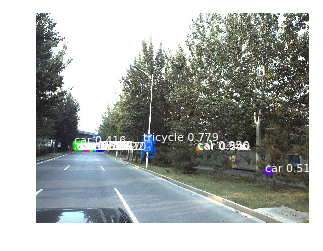

Processing 1 images
image                    shape: (640, 832, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 832, 832, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max:  832.00000  int64
anchors                  shape: (1, 172887, 4)        min:   -0.10892  max:    1.03190  float32


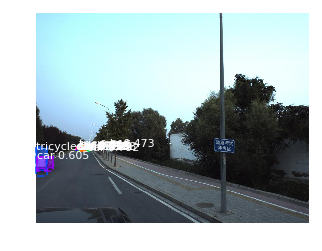

Processing 1 images
image                    shape: (640, 832, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 832, 832, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max:  832.00000  int64
anchors                  shape: (1, 172887, 4)        min:   -0.10892  max:    1.03190  float32


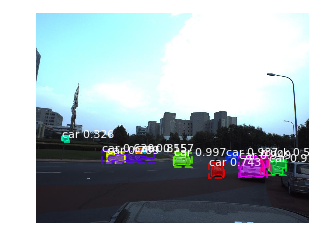

Processing 1 images
image                    shape: (640, 832, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 832, 832, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max:  832.00000  int64
anchors                  shape: (1, 172887, 4)        min:   -0.10892  max:    1.03190  float32


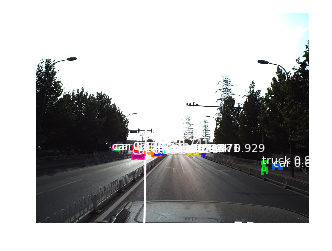

Processing 1 images
image                    shape: (640, 832, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 832, 832, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max:  832.00000  int64
anchors                  shape: (1, 172887, 4)        min:   -0.10892  max:    1.03190  float32


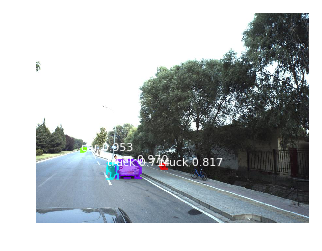

Processing 1 images
image                    shape: (640, 832, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 832, 832, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max:  832.00000  int64
anchors                  shape: (1, 172887, 4)        min:   -0.10892  max:    1.03190  float32


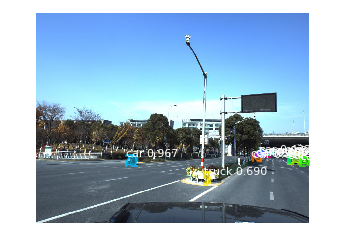

Processing 1 images
image                    shape: (640, 832, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 832, 832, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max:  832.00000  int64
anchors                  shape: (1, 172887, 4)        min:   -0.10892  max:    1.03190  float32


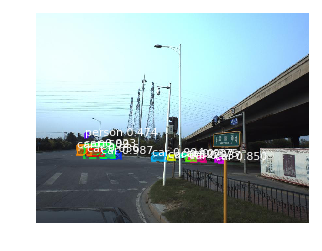

Processing 1 images
image                    shape: (640, 832, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 832, 832, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max:  832.00000  int64
anchors                  shape: (1, 172887, 4)        min:   -0.10892  max:    1.03190  float32


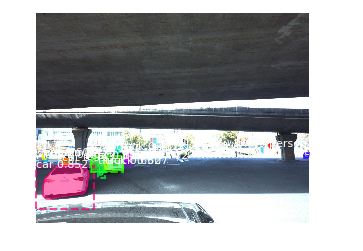

Processing 1 images
image                    shape: (640, 832, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 832, 832, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max:  832.00000  int64
anchors                  shape: (1, 172887, 4)        min:   -0.10892  max:    1.03190  float32


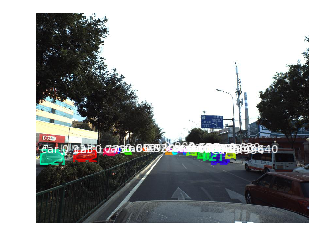

Processing 1 images
image                    shape: (640, 832, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 832, 832, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max:  832.00000  int64
anchors                  shape: (1, 172887, 4)        min:   -0.10892  max:    1.03190  float32


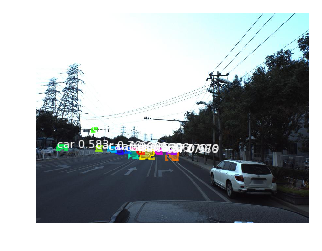

Processing 1 images
image                    shape: (640, 832, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 832, 832, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 20)               min:    0.00000  max:  832.00000  int64
anchors                  shape: (1, 172887, 4)        min:   -0.10892  max:    1.03190  float32


InvalidArgumentError: indices[1] = 18 is not in [0, 17)
	 [[{{node mrcnn_detection/map/while/GatherV2_2}} = GatherV2[Taxis=DT_INT32, Tindices=DT_INT32, Tparams=DT_INT64, _device="/job:localhost/replica:0/task:0/device:CPU:0"](mrcnn_detection/map/while/strided_slice, mrcnn_detection/map/while/non_max_suppression/NonMaxSuppressionV3, mrcnn_detection/map/while/PadV2/paddings/0/0)]]

In [14]:
import skimage
real_test_dir = '/home/ayush/Instance_Segmentation/all/Sample_Dataset/sample_test'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))